# **Preliminary**

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from dateutil.parser import parse
pd.set_option('display.max_rows', None)
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [1081]:
# Reading the data
xls = pd.ExcelFile('Irish Whiskey Worldwide 1990 to 2016.xlsx') # Complete file
main = pd.read_excel(xls, 'Data', skiprows = 6).copy() # Sheet 1 - sales data
reg = pd.read_excel(xls, 'Country_region', skiprows = 9).copy() # Sheet 2 - location info

In [1082]:
main.head()

Category 1   Quality        Country     1990     1991     1992     1993  \
0  Irish Whiskey       NaN            NaN  1535.15  1581.85  1606.75  1700.95   
1  Irish Whiskey  Standard            NaN  1404.85  1438.80  1461.80  1546.89   
2  Irish Whiskey  Standard  United States   243.00   214.00   219.50   225.00   
3  Irish Whiskey  Standard        Ireland   537.50   546.00   513.00   524.50   
4  Irish Whiskey  Standard         France    92.00   118.00   137.00   151.00   

      1994         1995         1996  ...         2007         2008      2009  \
0  1839.35  1933.500001  2124.100000  ...  3860.449999  4235.120000  4237.650   
1  1667.10  1752.670000  1917.075001  ...  3618.329999  3969.984999  3996.035   
2   239.50   249.000000   259.000000  ...   803.000000   975.500000  1099.250   
3   526.00   517.500000   536.350000  ...   473.400000   448.000000   404.400   
4   161.00   181.000000   225.000000  ...   370.250000   370.000000   353.000   

      2010         2011      2012         2013         2014      2015  \
0  4735.37  5446.990001  6022.290  6622.745002  6931.179999  7425.100   
1  4449.60  5125.585001  5676.825  6247.570001  6500.014999  6888.205   
2  1337.60  1652.250000  1989.750  2365.000000  2463.750000  2893.250   
3   404.30   426.100000   484.450   468.800000   413.870000   434.600   
4   380.00   376.000000   365.250   364.000000   364.000000   358.250   

          2016  
0  8250.814895  
1  7536.595000  
2  3337.500000  
3   444.200000  
4   345.250000  

[5 rows x 30 columns]

In [1083]:
# Unpivoting the original data to get all yearly sales compiled
main = main.melt(id_vars = ['Category 1', 'Quality', 'Country'], var_name = 'Year')

In [1084]:
main.shape

(4293, 5)

In [1085]:
main.head()

Category 1   Quality        Country  Year    value
0  Irish Whiskey       NaN            NaN  1990  1535.15
1  Irish Whiskey  Standard            NaN  1990  1404.85
2  Irish Whiskey  Standard  United States  1990   243.00
3  Irish Whiskey  Standard        Ireland  1990   537.50
4  Irish Whiskey  Standard         France  1990    92.00

In [1086]:
main.rename({'Category 1' : 'Category', 'value' : 'Sales'}, axis = 1, inplace = True)

# **Preprocessing**

In [1087]:
main.isna().sum()

Category      54
Quality       81
Country      162
Year           0
Sales       1391
dtype: int64

*Original data is a pivot table. We melted/unpivoted it to be able to use it. It still contains certains rows that gave subtotal and grand totals in the pivot table.
Upon inspection, I found that all such rows had 'Country' null. Hence, removing such records.*

In [1088]:
main = main[~(main['Country'].isnull())]

In [1089]:
main.shape

(4131, 5)

In [1090]:
reg.head()

Country code               Country Region
0           ad               Andorra   EMEA
1           ae  United Arab Emirates   EMEA
2           af           Afghanistan   EMEA
3           ag   Antigua and Barbuda  LATAM
4           ai              Anguilla  LATAM

In [1091]:
# Merging yearly sales data with country codes and region, matched on common country column
df = main.merge(reg, on = 'Country', how = "inner")

In [1092]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1890 non-null   object 
 1   Quality       1890 non-null   object 
 2   Country       1890 non-null   object 
 3   Year          1890 non-null   object 
 4   Sales         1464 non-null   float64
 5   Country code  1890 non-null   object 
 6   Region        1809 non-null   object 
dtypes: float64(1), object(6)
memory usage: 103.5+ KB


In [1093]:
df.head()

Category        Quality  Country  Year  Sales Country code Region
0  Irish Whiskey       Standard  Ireland  1990  537.5           ie   EMEA
1  Irish Whiskey        Premium  Ireland  1990   32.0           ie   EMEA
2  Irish Whiskey  Super Premium  Ireland  1990    NaN           ie   EMEA
3  Irish Whiskey       Standard  Ireland  1991  546.0           ie   EMEA
4  Irish Whiskey        Premium  Ireland  1991   33.0           ie   EMEA

In [1094]:
# Dropping category since it's non-variable, also removing country since goal is to forecast sales for regions over the next 2 years
df.drop(['Category', 'Country'], axis = 1, inplace = True)

In [1095]:
df.isna().sum()

Quality           0
Year              0
Sales           426
Country code      0
Region           81
dtype: int64

In [1096]:
df[df['Region'].isna()]

Quality  Year   Sales Country code Region
324       Standard  1990   21.85           ca    NaN
325        Premium  1990    1.15           ca    NaN
326  Super Premium  1990     NaN           ca    NaN
327       Standard  1991   22.25           ca    NaN
328        Premium  1991    1.25           ca    NaN
329  Super Premium  1991     NaN           ca    NaN
330       Standard  1992   21.00           ca    NaN
331        Premium  1992    1.00           ca    NaN
332  Super Premium  1992     NaN           ca    NaN
333       Standard  1993   20.35           ca    NaN
334        Premium  1993    1.15           ca    NaN
335  Super Premium  1993     NaN           ca    NaN
336       Standard  1994   21.10           ca    NaN
337        Premium  1994    1.90           ca    NaN
338  Super Premium  1994     NaN           ca    NaN
339       Standard  1995   21.25           ca    NaN
340        Premium  1995    2.25           ca    NaN
341  Super Premium  1995     NaN           ca    NaN
342       Standard  1996   23.00           ca    NaN
343        Premium  1996    2.50           ca    NaN
344  Super Premium  1996     NaN           ca    NaN
345       Standard  1997   21.40           ca    NaN
346        Premium  1997    3.10           ca    NaN
347  Super Premium  1997     NaN           ca    NaN
348       Standard  1998   22.10           ca    NaN
349        Premium  1998    3.15           ca    NaN
350  Super Premium  1998     NaN           ca    NaN
351       Standard  1999   23.85           ca    NaN
352        Premium  1999    4.15           ca    NaN
353  Super Premium  1999     NaN           ca    NaN
354       Standard  2000   25.75           ca    NaN
355        Premium  2000    4.75           ca    NaN
356  Super Premium  2000     NaN           ca    NaN
357       Standard  2001   27.50           ca    NaN
358        Premium  2001    5.00           ca    NaN
359  Super Premium  2001     NaN           ca    NaN
360       Standard  2002   30.50           ca    NaN
361        Premium  2002    5.25           ca    NaN
362  Super Premium  2002     NaN           ca    NaN
363       Standard  2003   32.15           ca    NaN
364        Premium  2003    6.10           ca    NaN
365  Super Premium  2003     NaN           ca    NaN
366       Standard  2004   35.00           ca    NaN
367        Premium  2004    6.75           ca    NaN
368  Super Premium  2004     NaN           ca    NaN
369       Standard  2005   38.00           ca    NaN
370        Premium  2005    6.75           ca    NaN
371  Super Premium  2005     NaN           ca    NaN
372       Standard  2006   40.50           ca    NaN
373        Premium  2006    7.25           ca    NaN
374  Super Premium  2006     NaN           ca    NaN
375       Standard  2007   45.10           ca    NaN
376        Premium  2007    7.65           ca    NaN
377  Super Premium  2007    0.25           ca    NaN
378       Standard  2008   50.25           ca    NaN
379        Premium  2008    8.35           ca    NaN
380  Super Premium  2008    0.25           ca    NaN
381       Standard  2009   57.00           ca    NaN
382        Premium  2009    8.75           ca    NaN
383  Super Premium  2009    0.25           ca    NaN
384       Standard  2010   65.75           ca    NaN
385        Premium  2010    9.35           ca    NaN
386  Super Premium  2010    0.35           ca    NaN
387       Standard  2011   80.50           ca    NaN
388        Premium  2011   10.45           ca    NaN
389  Super Premium  2011    0.50           ca    NaN
390       Standard  2012  108.00           ca    NaN
391        Premium  2012   10.60           ca    NaN
392  Super Premium  2012    0.60           ca    NaN
393       Standard  2013  116.00           ca    NaN
394        Premium  2013   10.75           ca    NaN
395  Super Premium  2013    0.70           ca    NaN
396       Standard  2014  140.00           ca    NaN
397        Premium  2014   11.00           ca    NaN
398  Super Premium  2014    0.50    

*Suspect that Country code 'ca' has 'NA' in region corresponding to it (Canada - North America). Verifying*


In [1097]:
len(df[(df.Region.isna()) & (df['Country code'] != 'ca')])

0

*Thus Region is not actually null, but just pandas interpreting 'NA' as null. Hence we must fill in the right values*

In [1098]:
df['Region'] = df.Region.fillna('NA')

In [1099]:
df.isna().sum()

Quality           0
Year              0
Sales           426
Country code      0
Region            0
dtype: int64

In [1100]:
df[df.Sales.isna()].head(3)

Quality  Year  Sales Country code Region
2  Super Premium  1990    NaN           ie   EMEA
5  Super Premium  1991    NaN           ie   EMEA
8  Super Premium  1992    NaN           ie   EMEA

In [1101]:
# Assuming no sales in that particular region for years where no information in data is available(NA)
df.Sales = df.Sales.fillna(0)

In [1102]:
# Grouping data and calculating region-wise, yearly total sales per quality
df_train = df.groupby(['Region', 'Quality', 'Year']).agg({'Sales': 'sum'})
df_train.rename(columns = {'Sales': 'Total Sales'}, inplace = True)

In [1103]:
# Adding a constant to all values, to avoid problem with 0
df_train['Total Sales'] = df_train['Total Sales'] + 1

In [1104]:
df_train.head()

Total Sales
Region Quality Year             
APAC   Premium 1990         3.25
               1991         2.75
               1992         2.75
               1993         3.00
               1994         2.85

In [1105]:
df_new = df_train.reset_index()

In [1106]:
# Creating separate dataframes based on region and quality
dfs = {}

for reg in df_new.Region.unique():
    for qual in df_new.Quality.unique():
        key = f'df_{reg}_{qual}'
        dfs[key] = df_new[(df_new.Region == reg) & (df_new.Quality == qual)]
        dfs[key].drop(['Quality', 'Region'], axis = 1, inplace = True)
        dfs[key].reset_index(drop = True, inplace = True)
        # dfs[key].set_index('Year', inplace = True)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\448739316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[key].drop(['Quality', 'Region'], axis = 1, inplace = True)
C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\448739316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[key].drop(['Quality', 'Region'], axis = 1, inplace = True)
C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\448739316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [1107]:
dfs.keys()

dict_keys(['df_APAC_Premium', 'df_APAC_Standard', 'df_APAC_Super Premium', 'df_EMEA_Premium', 'df_EMEA_Standard', 'df_EMEA_Super Premium', 'df_LATAM_Premium', 'df_LATAM_Standard', 'df_LATAM_Super Premium', 'df_NA_Premium', 'df_NA_Standard', 'df_NA_Super Premium'])

______________________________________

# **Modelling**

In [1108]:
# To plot original data with model forecast
def plot_forecast(series, model, label, steps):

    plt.figure(figsize = (10, 6))
    plt.plot(series, label = 'Actual')
    plt.plot(model.fittedvalues, label = label, color='red')

    # Forecast for the next 'steps' time periods
    forecast_values = model.forecast(steps = steps)
    plt.plot(forecast_values.index, forecast_values.values, color = 'green', label = 'Forecast')

    # Calculate residuals
    residuals = series - model.fittedvalues
    residual_std = np.std(residuals)

    # Calculate prediction interval
    z_score = 1.96  # for 95% prediction interval
    lower_bound = forecast_values - z_score * residual_std
    upper_bound = forecast_values + z_score * residual_std

    # Plot prediction interval
    plt.fill_between(forecast_values.index, lower_bound, upper_bound, color='lightgrey', label='95% Prediction Interval')

    plt.title('EMEAIA: Exports of Goods and Services as % of GDP')
    plt.xlabel('Year')
    plt.ylabel('Exports (% of GDP)')
    plt.legend()
    plt.show()

In [1109]:
# To get rmse
def get_metrics(train_actual, test_actual, model, model_name, dataframe):

    k1 = len(test_actual)

    try:
        forecasts = model.forecast(k1 + 2)
        train_predicted = model.fittedvalues

    except:
        forecasts = model.predict(n_periods = k1 + 2)
        train_predicted, conf_int = model.predict_in_sample(return_conf_int = True, alpha = 0.05)

    test_predicted = forecasts[:k1]
    forecast1 = forecasts[-2]
    forecast2 = forecasts[-1]

    rmse_train = np.sqrt(mean_squared_error(train_actual, train_predicted))
    rmse_test = np.sqrt(mean_squared_error(test_actual, test_predicted))

    dataframe.loc[len(dataframe)] = [model_name, rmse_train, rmse_test, forecast1, forecast2]

    return(dataframe)

In [1110]:
# Perform KPSS test (level stationarity)
def kpss_level(data, lags):
    """
    Perform KPSS test with custom number of lags.
    
    Parameters:
    data : array-like
        The time series data to be tested.
    lags : int
        The number of lags to use in the KPSS test.
        
    Returns:
    tuple
        A tuple containing the test statistic, p-value, and critical values.
    """
    # Perform KPSS test
    kpss_test = kpss(data, nlags=lags)
    p = kpss_test[0]

    return p

In [1111]:
# Perform KPSS test (trend stationarity)
def kpss_trend(data, lags):
    """
    Perform KPSS test with custom number of lags.
    
    Parameters:
    data : array-like
        The time series data to be tested.
    lags : int
        The number of lags to use in the KPSS test.
        
    Returns:
    tuple
        A tuple containing the test statistic, p-value, and critical values.
    """
    # Perform KPSS test
    kpss_test_trend = kpss(data, regression = 'ct', nlags=lags)
    p = kpss_test_trend[0]
    
    return p

## APAC

### *1. Standard*

In [1113]:
df_APAC_std = dfs['df_APAC_Standard']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3235775398.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect = [0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3235775398.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect = [0, 0.03, 1, 0.95])


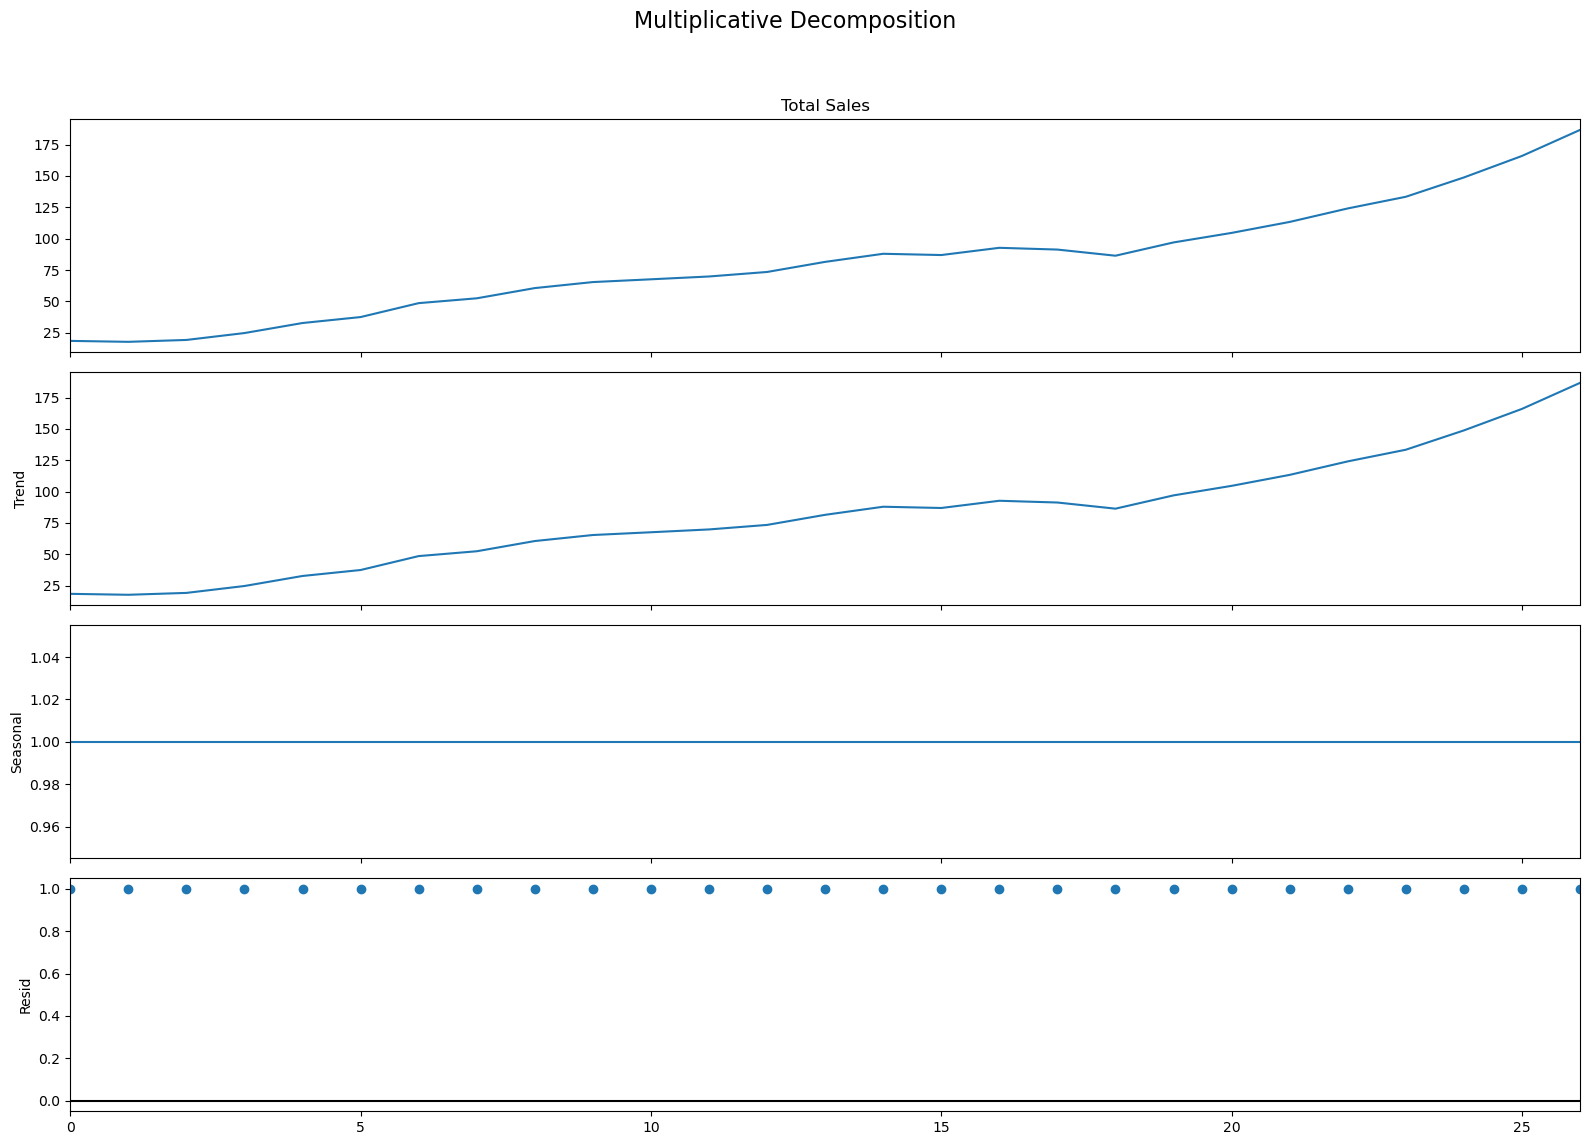

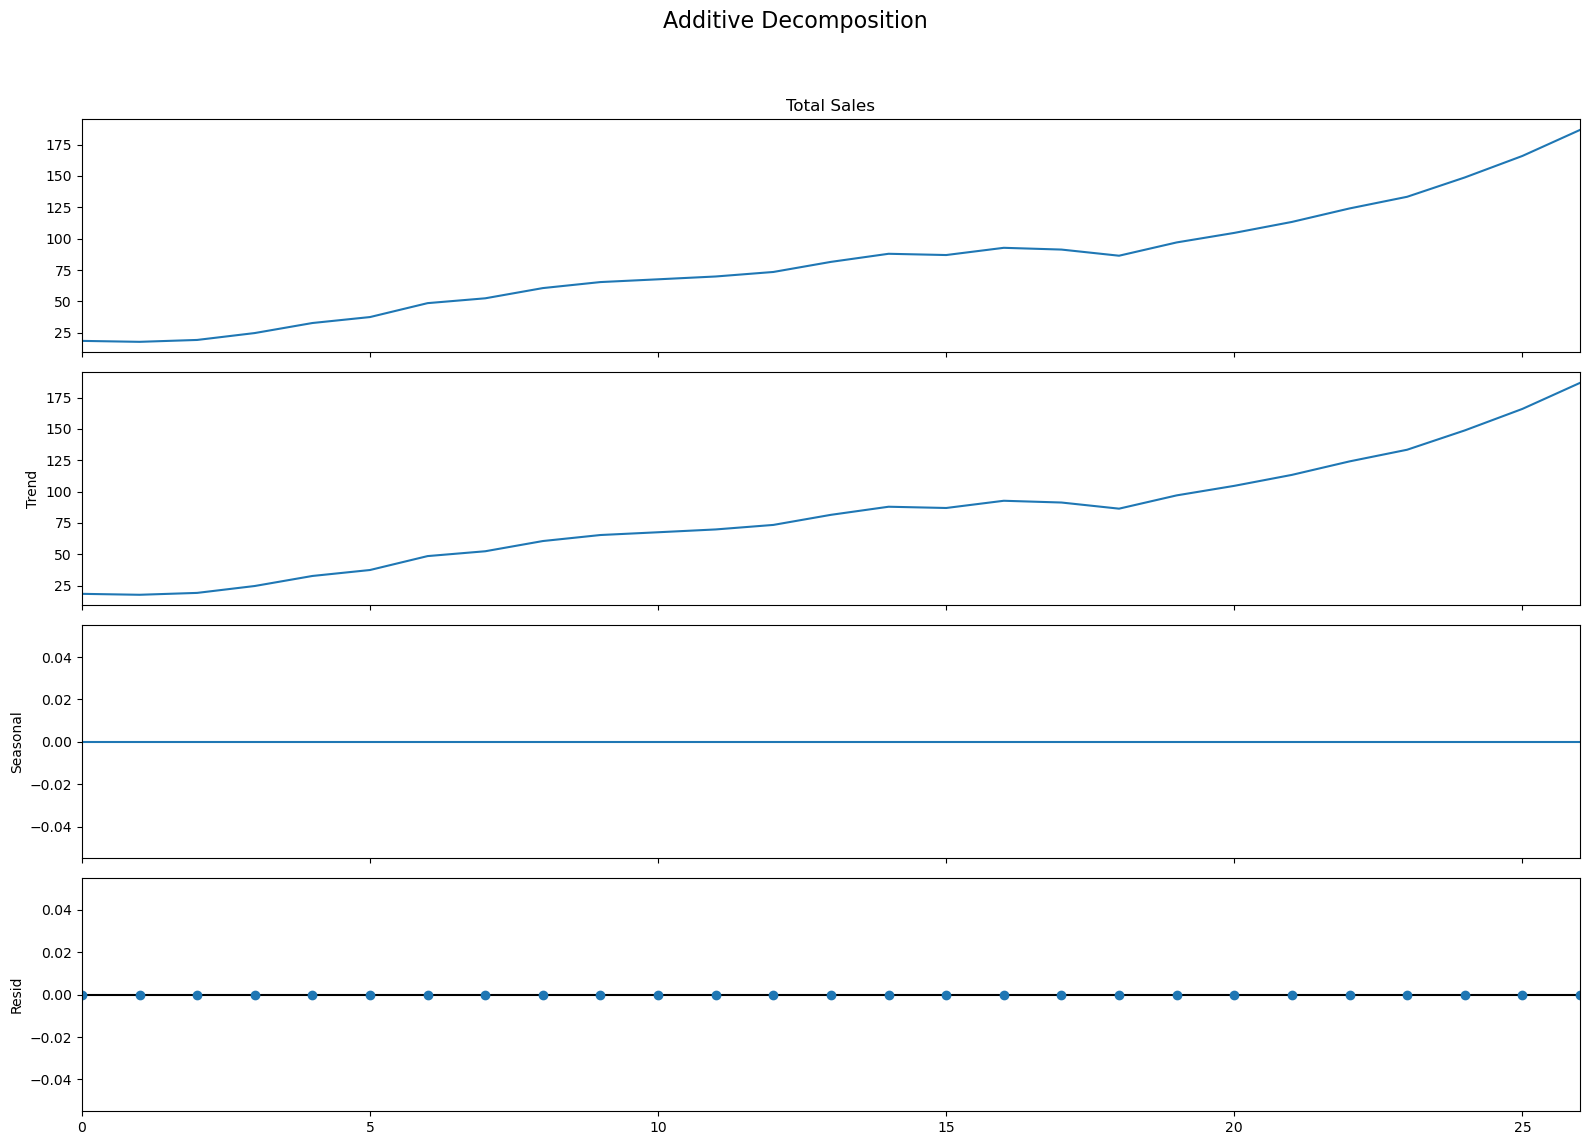

In [1114]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_APAC_std['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_APAC_std['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])

plt.show()

In [1115]:
df_APAC_std['Time'] = np.arange(1, len(df_APAC_std) + 1)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3742803857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_APAC_std['Time'] = np.arange(1, len(df_APAC_std) + 1)


In [1116]:
# Train-test split

k = np.floor(df_APAC_std.shape[0]*.9).astype('int')
df_APAC_std_train = df_APAC_std.iloc[0:k,:]
df_APAC_std_test = df_APAC_std.iloc[k:, :]

In [1117]:
# Trying polynomial regression since graph seems simple
X_apac_std_train_1 = sm.add_constant(df_APAC_std_train['Time']**2)
y_apac_std_train_1 = df_APAC_std_train['Total Sales']

mod_apac_std_lr = sm.OLS(y_apac_std_train_1, X_apac_std_train_1).fit()
print(mod_apac_std_lr.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     203.7
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           1.33e-12
Time:                        23:57:49   Log-Likelihood:                -90.005
No. Observations:                  24   AIC:                             184.0
Df Residuals:                      22   BIC:                             186.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4584      3.336     10.329      0.0

In [1118]:
ser_APAC_std_train = pd.Series(df_APAC_std_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_APAC_std_train), freq = "A"))
ser_APAC_std_test = pd.Series(df_APAC_std_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_APAC_std_test), freq = "A"))

In [1119]:
APAC_STD = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1120]:
# ETS
mod_APAC_std_ets = ETSModel(ser_APAC_std_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_APAC_std_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -78.967
Date:                Sat, 20 Apr 2024   AIC                            169.935
Time:                        23:57:49   BIC                            177.003
Sample:                    12-31-1990   HQIC                           171.810
                         - 12-31-2013   Scale                            0.011
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.0001        nan        nan        nan         nan         nan
smoothing_trend      1e-08        nan        nan        nan         nan         nan
damping_trend       0.9800      

In [1121]:
get_metrics(ser_APAC_std_train, ser_APAC_std_test, mod_APAC_std_ets, 'ETS', APAC_STD)

model  train_rmse  test_rmse        2017        2018
0   ETS    5.971055    45.9589  129.538952  132.696615

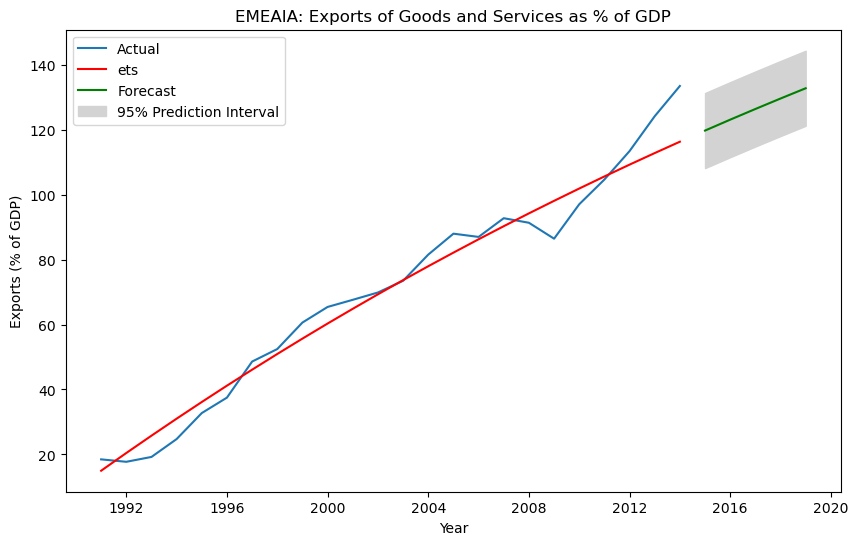

In [1122]:
plot_forecast(ser_APAC_std_train, mod_APAC_std_ets, 'ets', len(ser_APAC_std_test)+2)

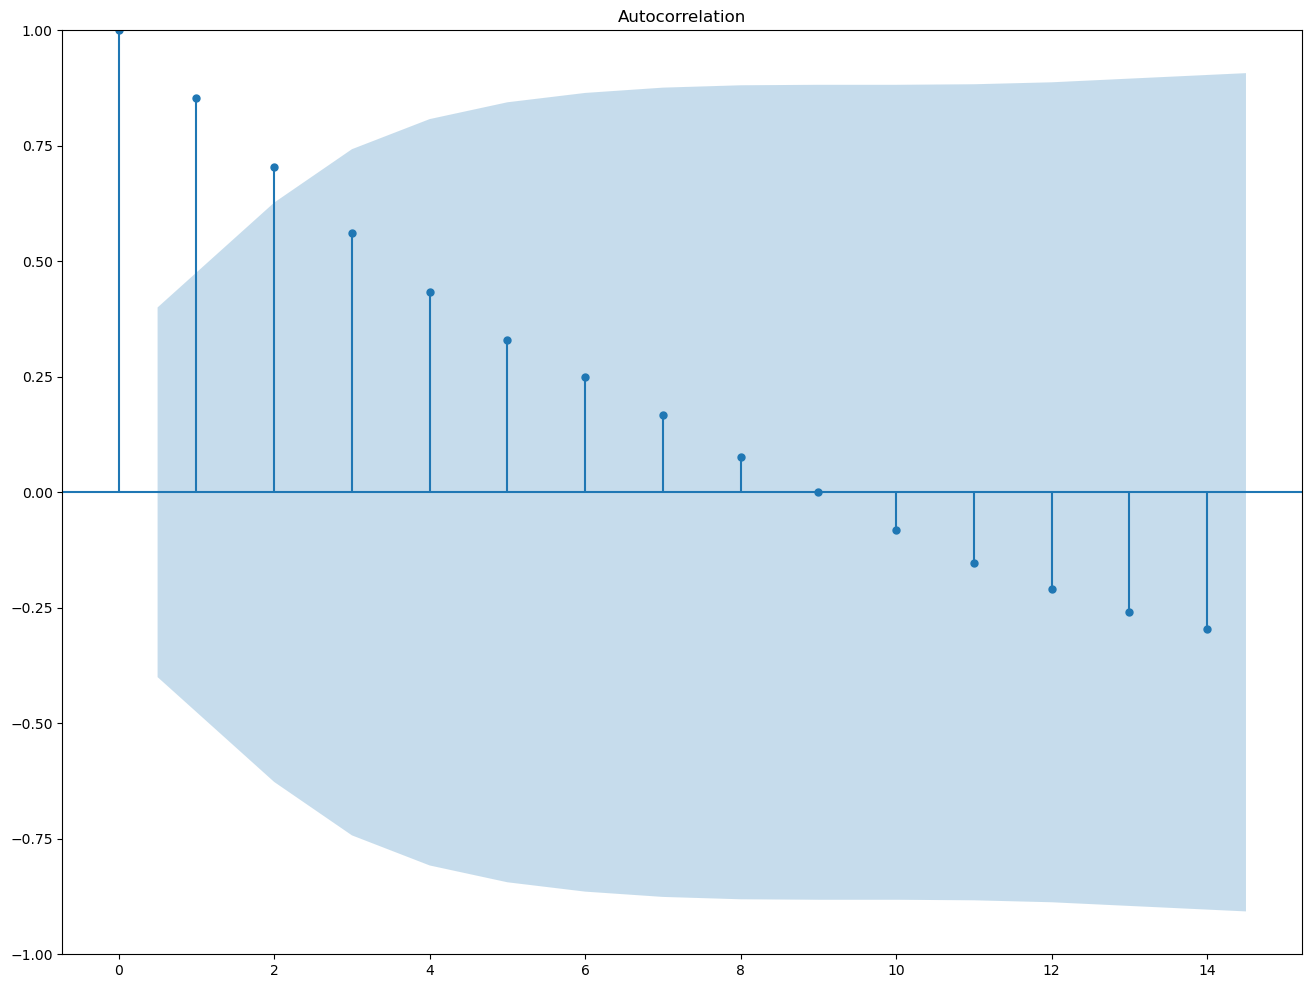

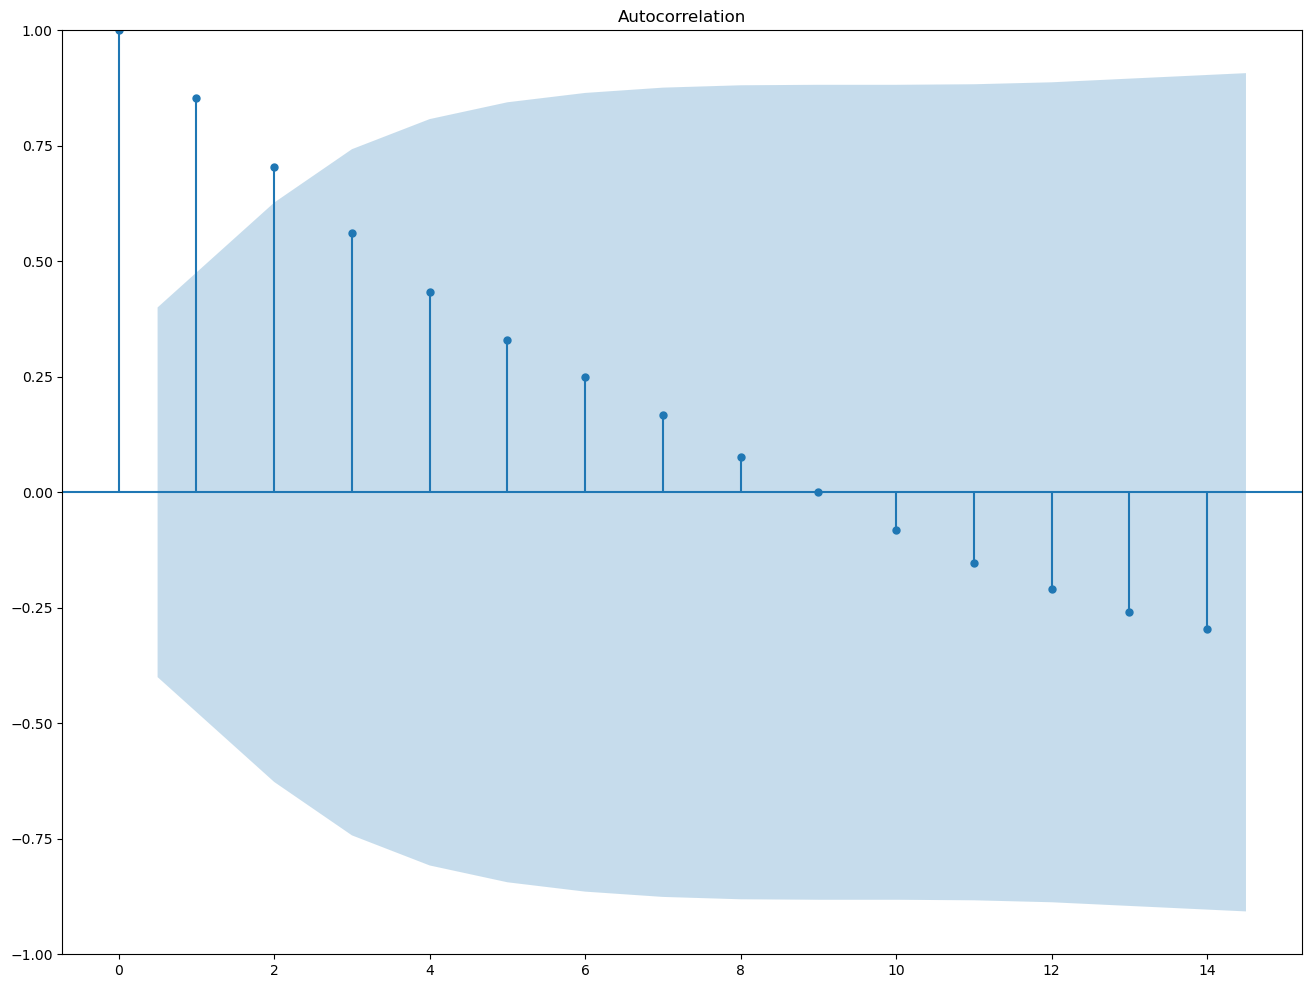

In [1123]:
# Plotting auto correlation plot of lags, shows seasonality
plot_acf(ser_APAC_std_train)

In [1124]:
# AR - Autoregressive model, p is the number of past terms
p = 25
mod_APAC_std_ar = sm.tsa.ARIMA(ser_APAC_std_train, order = (p, 0, 0)).fit()
print(mod_APAC_std_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(25, 0, 0)   Log Likelihood                 -60.208
Date:                Sat, 20 Apr 2024   AIC                            174.416
Time:                        23:57:53   BIC                            206.223
Sample:                    12-31-1990   HQIC                           182.854
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3663      0.009   7625.289      0.000      70.348      70.384
ar.L1          0.9878      0.452      2.187      0.029       0.103       1.873
ar.L2          1.5011      0.449      3.343      0.0

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


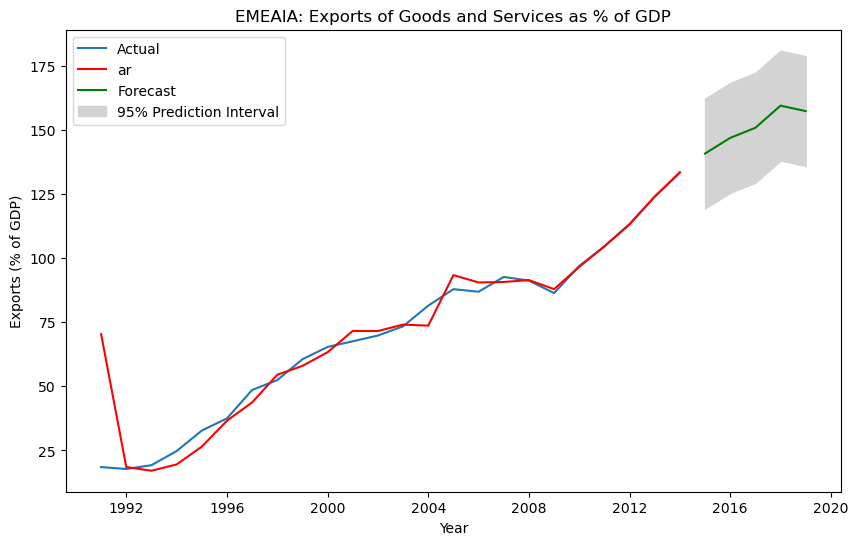

In [1125]:
plot_forecast(ser_APAC_std_train, mod_APAC_std_ar, 'ar', len(ser_APAC_std_test)+2)

In [1126]:
get_metrics(ser_APAC_std_train, ser_APAC_std_test, mod_APAC_std_ar, 'AR', APAC_STD)

model  train_rmse  test_rmse        2017        2018
0   ETS    5.971055  45.958900  129.538952  132.696615
1    AR   11.052920  23.806981  159.580618  157.456527

In [1127]:
# MA - moving average plot where q ia the number of prior error terms
q = 5
mod_APAC_std_ma = sm.tsa.ARIMA(ser_APAC_std_train, order = (0, 0, q)).fit()
print(mod_APAC_std_ma.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -80.515
Date:                Sat, 20 Apr 2024   AIC                            175.029
Time:                        23:57:54   BIC                            183.276
Sample:                    12-31-1990   HQIC                           177.217
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.5323     12.239      5.926      0.000      48.544      96.521
ma.L1          1.7664     29.375      0.060      0.952     -55.808      59.340
ma.L2          2.1896    145.161      0.015      0.9

In [1128]:
get_metrics(ser_APAC_std_train, ser_APAC_std_test, mod_APAC_std_ma, 'MA', APAC_STD)

model  train_rmse  test_rmse        2017        2018
0   ETS    5.971055  45.958900  129.538952  132.696615
1    AR   11.052920  23.806981  159.580618  157.456527
2    MA   12.420003  55.706247   88.745681   76.685592

In [1129]:
# KPSS test for level stationarity, p value > 0.05. Hence H0 is accepted. The data is level stationary
kpss_level(ser_APAC_std_train, 10)

0.3966018656885333

In [1130]:
# KPSS test for trend stationarity, p value > 0.05. Hence H0 is accepted. The data is trend stationary
kpss_trend(ser_APAC_std_train, 10)

0.16103225922406214

*Hence, no differencing needed*

In [1131]:
# ARIMA 
mod_APAC_std_auto_arima = pm.auto_arima(ser_APAC_std_train, stepwise=False, seasonal=True)
mod_APAC_std_auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1132]:
print(mod_APAC_std_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -65.793
Date:                Sat, 20 Apr 2024   AIC                            135.586
Time:                        23:57:56   BIC                            137.857
Sample:                    12-31-1990   HQIC                           136.157
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.9957      0.972      5.140      0.000       3.091       6.901
sigma2        17.8721      6.748      2.649      0.008       4.647      31.097
Ljung-Box (L1) (Q):                   0.97   Jarque-

In [1133]:
get_metrics(ser_APAC_std_train, ser_APAC_std_test, mod_APAC_std_auto_arima, 'ARIMA', APAC_STD)

model  train_rmse  test_rmse        2017        2018
0    ETS    5.971055  45.958900  129.538952  132.696615
1     AR   11.052920  23.806981  159.580618  157.456527
2     MA   12.420003  55.706247   88.745681   76.685592
3  ARIMA    4.972529  26.363071  153.382609  158.378261

In [1134]:
fitted, conf = mod_APAC_std_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

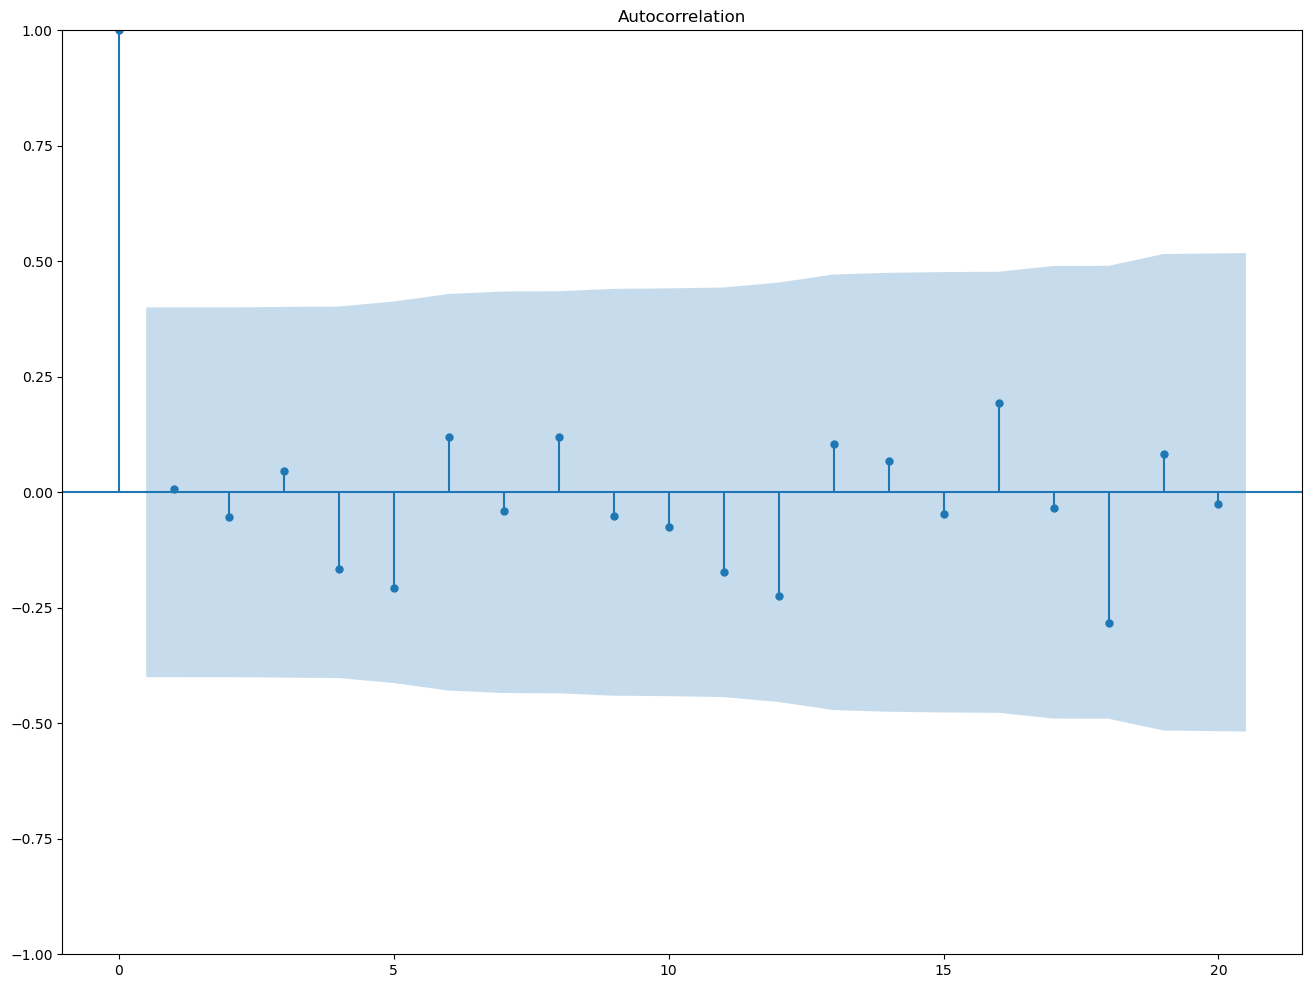

In [1135]:
residuals = ser_APAC_std_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

*Residual ACF plot shows all errors lie within the confidence interval of 0. Hence rest is random noise, which can't be captured. (Ignoring 0 lag which is correlation with itself)*

In [1136]:
APAC_STD

model  train_rmse  test_rmse        2017        2018
0    ETS    5.971055  45.958900  129.538952  132.696615
1     AR   11.052920  23.806981  159.580618  157.456527
2     MA   12.420003  55.706247   88.745681   76.685592
3  ARIMA    4.972529  26.363071  153.382609  158.378261

## --------------------------------------------------------------------------------------

### *2. Premium*

In [1137]:
df_APAC_p = dfs['df_APAC_Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\2105384024.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\2105384024.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


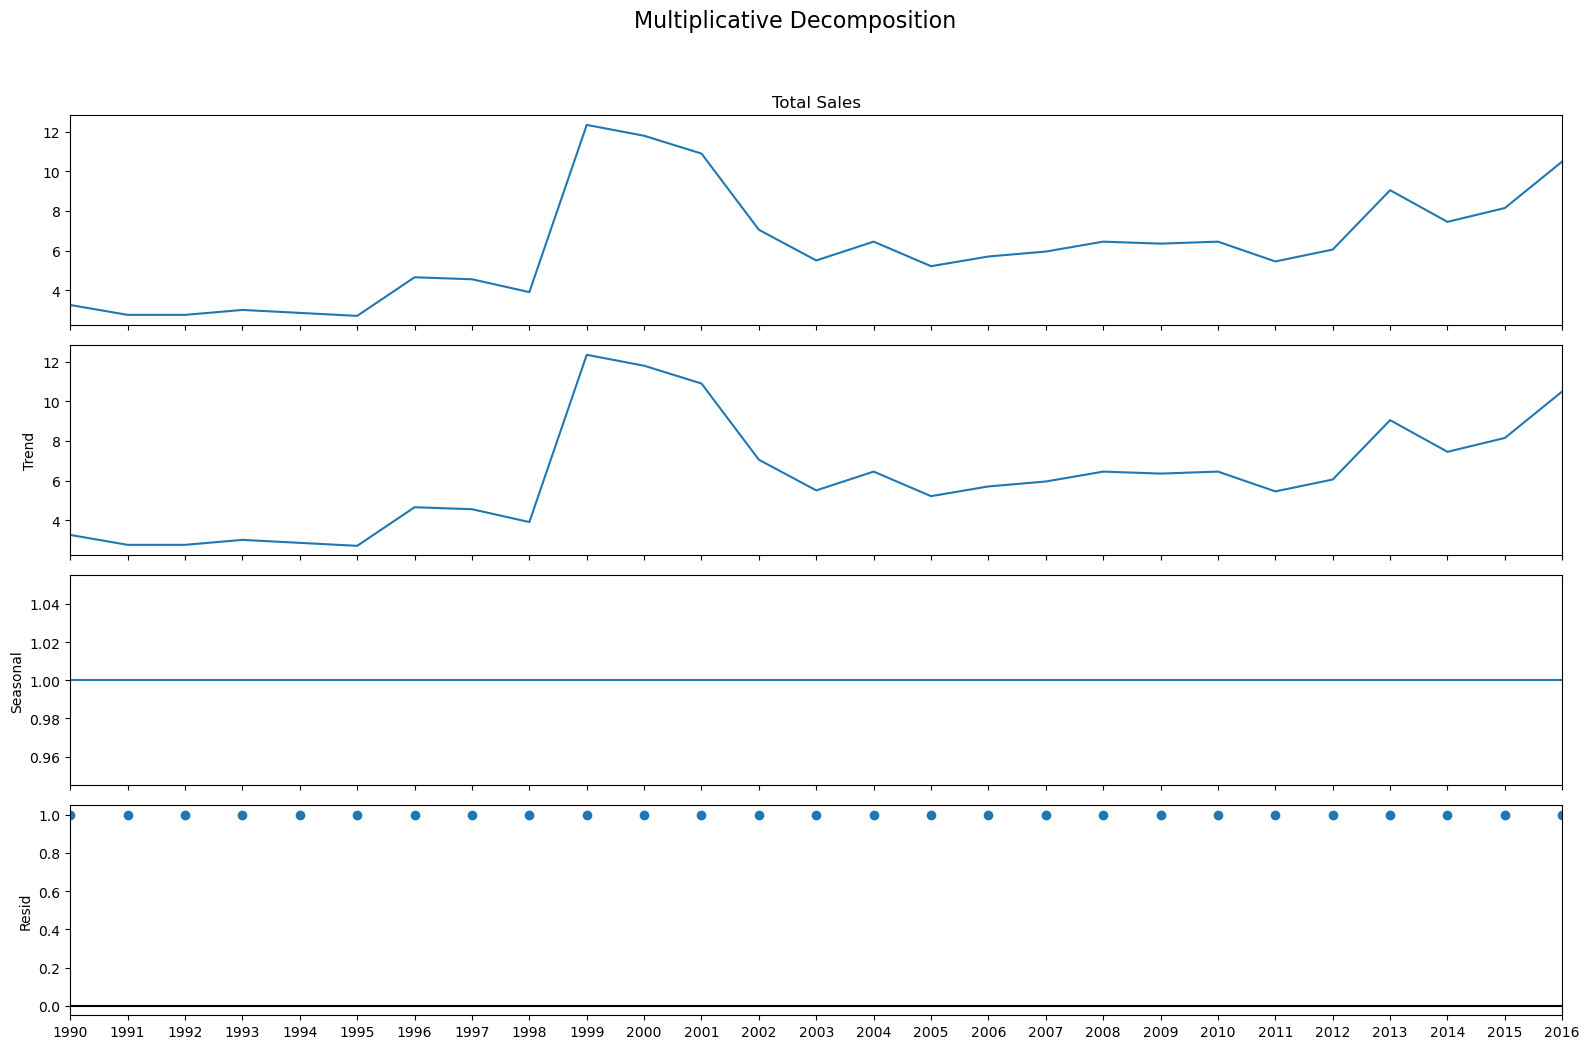

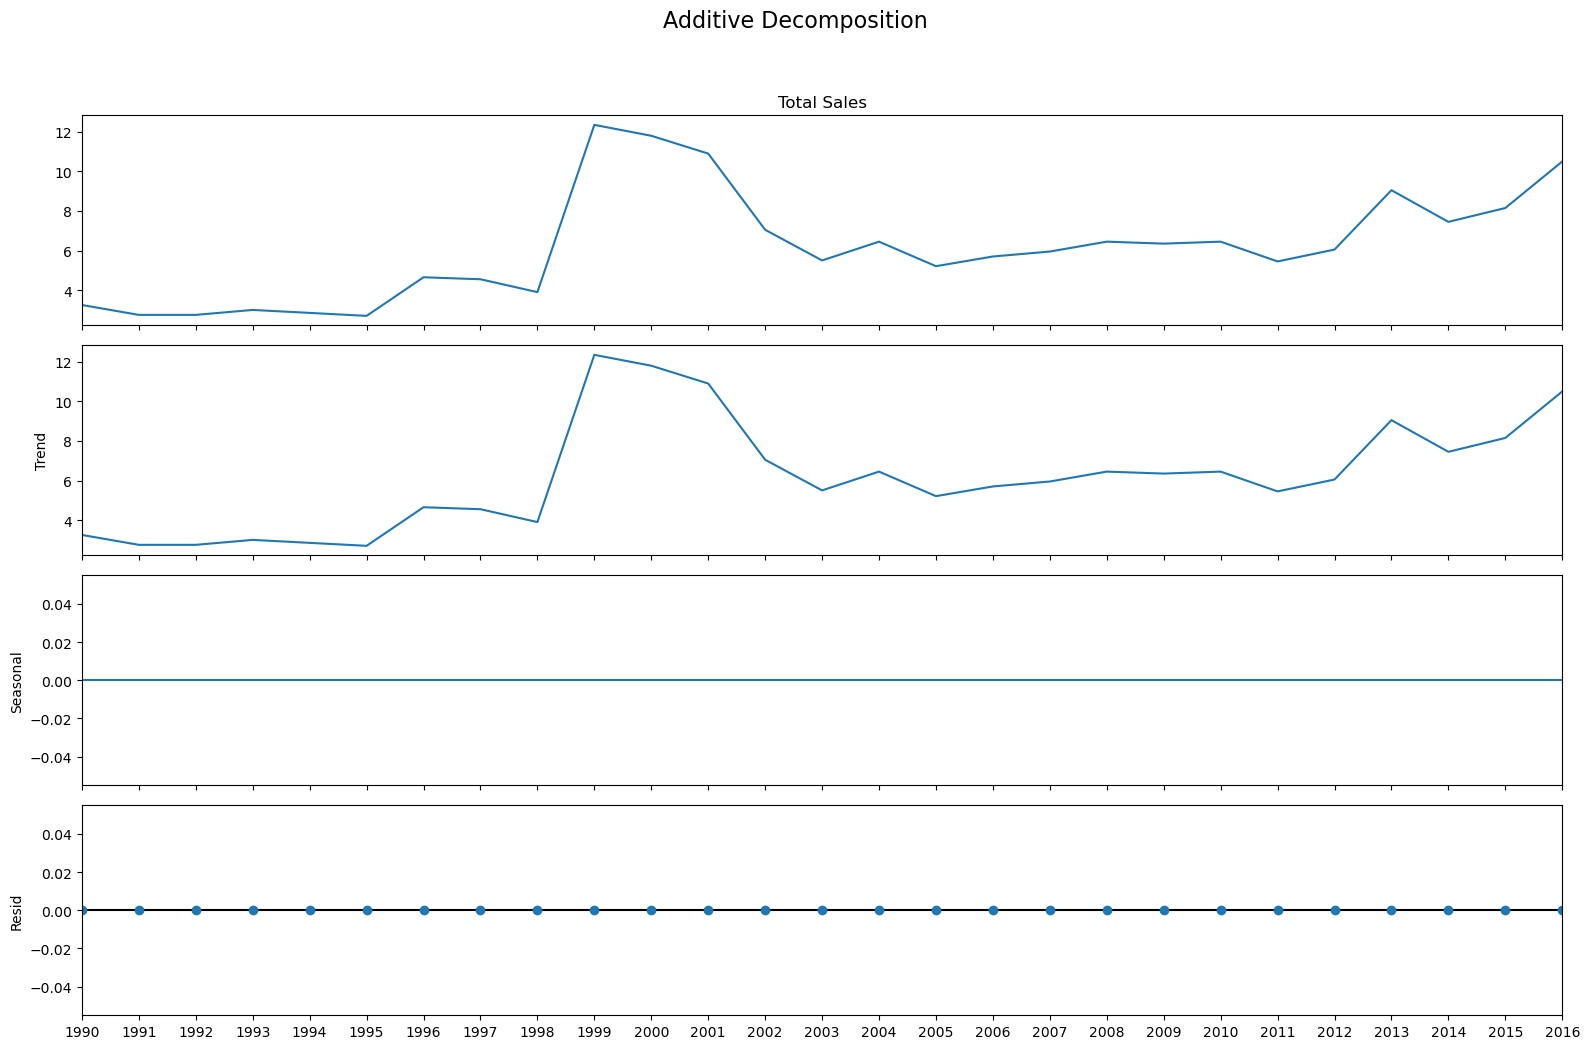

In [1138]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_APAC_p.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_APAC_p.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1139]:
k = np.floor(df_APAC_p.shape[0]*.9).astype('int')
df_APAC_p_train = df_APAC_p.iloc[0:k,:]
df_APAC_p_test = df_APAC_p.iloc[k:, :]

In [1140]:
ser_APAC_p_train = pd.Series(df_APAC_p_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_APAC_p_train), freq = "A"))
ser_APAC_p_test = pd.Series(df_APAC_p_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_APAC_p_test), freq = "A"))

In [1141]:
APAC_P = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1142]:
# ETS
mod_APAC_p_ets = ETSModel(ser_APAC_p_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_APAC_p_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -53.139
Date:                Sat, 20 Apr 2024   AIC                            118.277
Time:                        23:57:59   BIC                            125.346
Sample:                    12-31-1990   HQIC                           120.153
                         - 12-31-2013   Scale                            0.147
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.6005      0.189      3.182      0.001       0.231       0.970
smoothing_trend  6.005e-05        nan        nan        nan         nan         nan
damping_trend       0.9800      

In [1143]:
get_metrics(ser_APAC_p_train, ser_APAC_p_test, mod_APAC_p_ets, 'ETS', APAC_P)

model  train_rmse  test_rmse      2017     2018
0   ETS    2.210737   1.043301  9.426031  9.75111

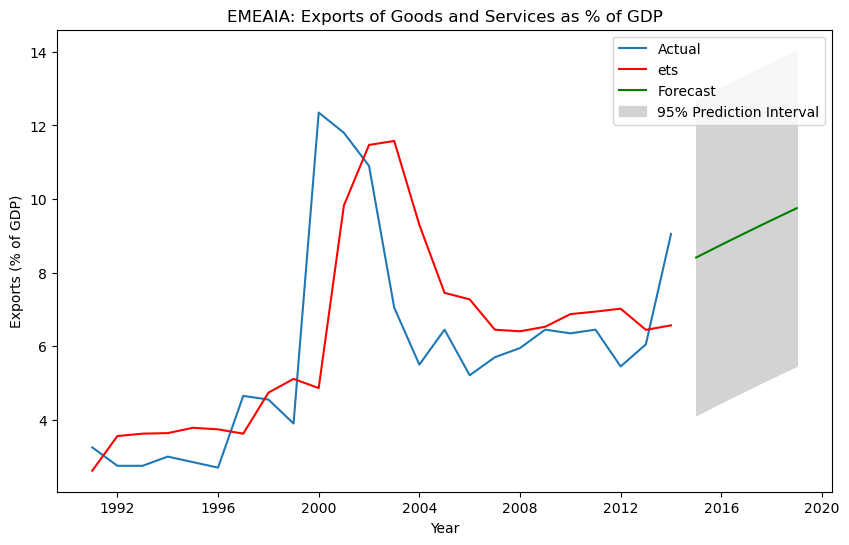

In [1144]:
plot_forecast(ser_APAC_p_train, mod_APAC_p_ets, 'ets', len(ser_APAC_p_test)+2)

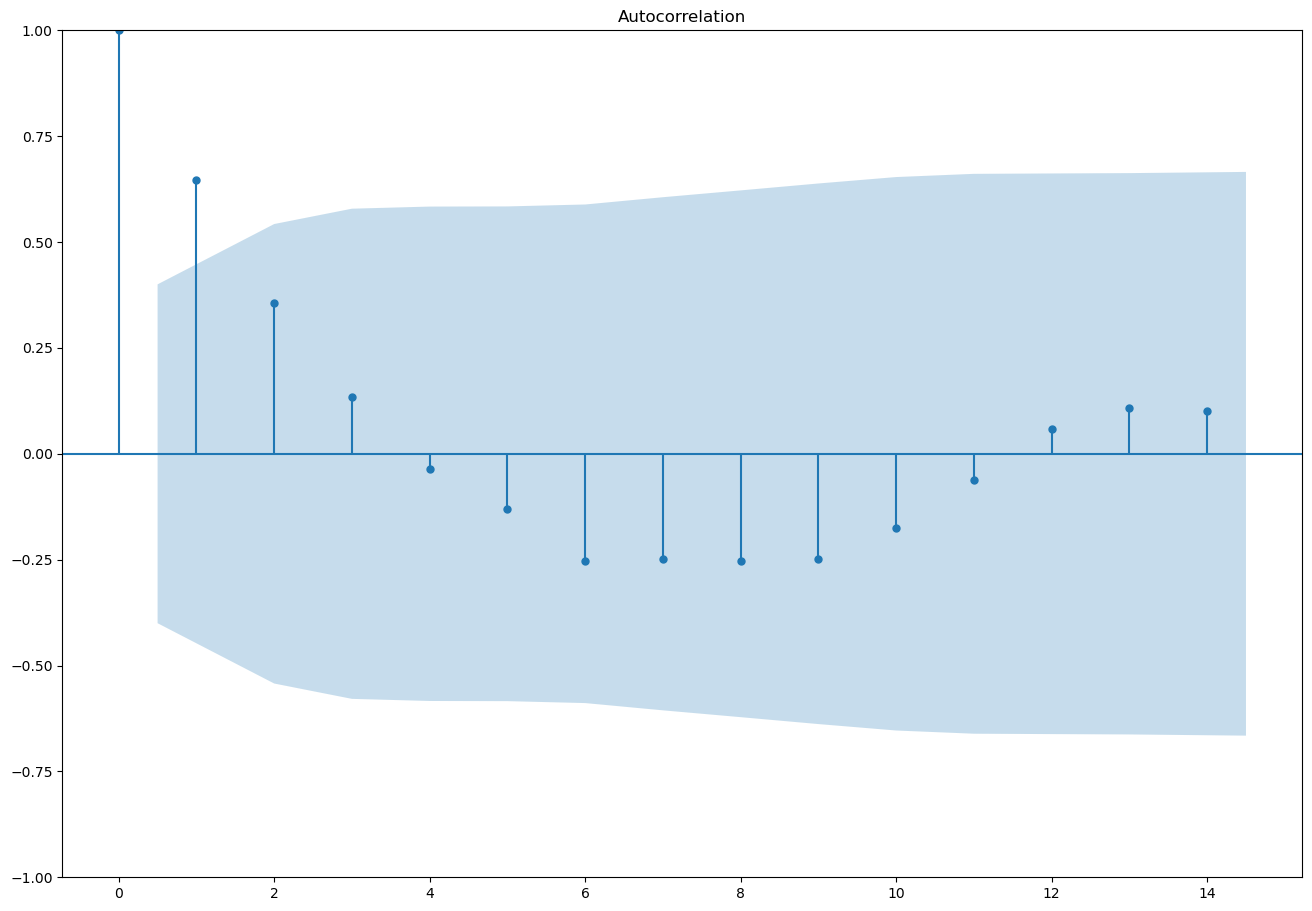

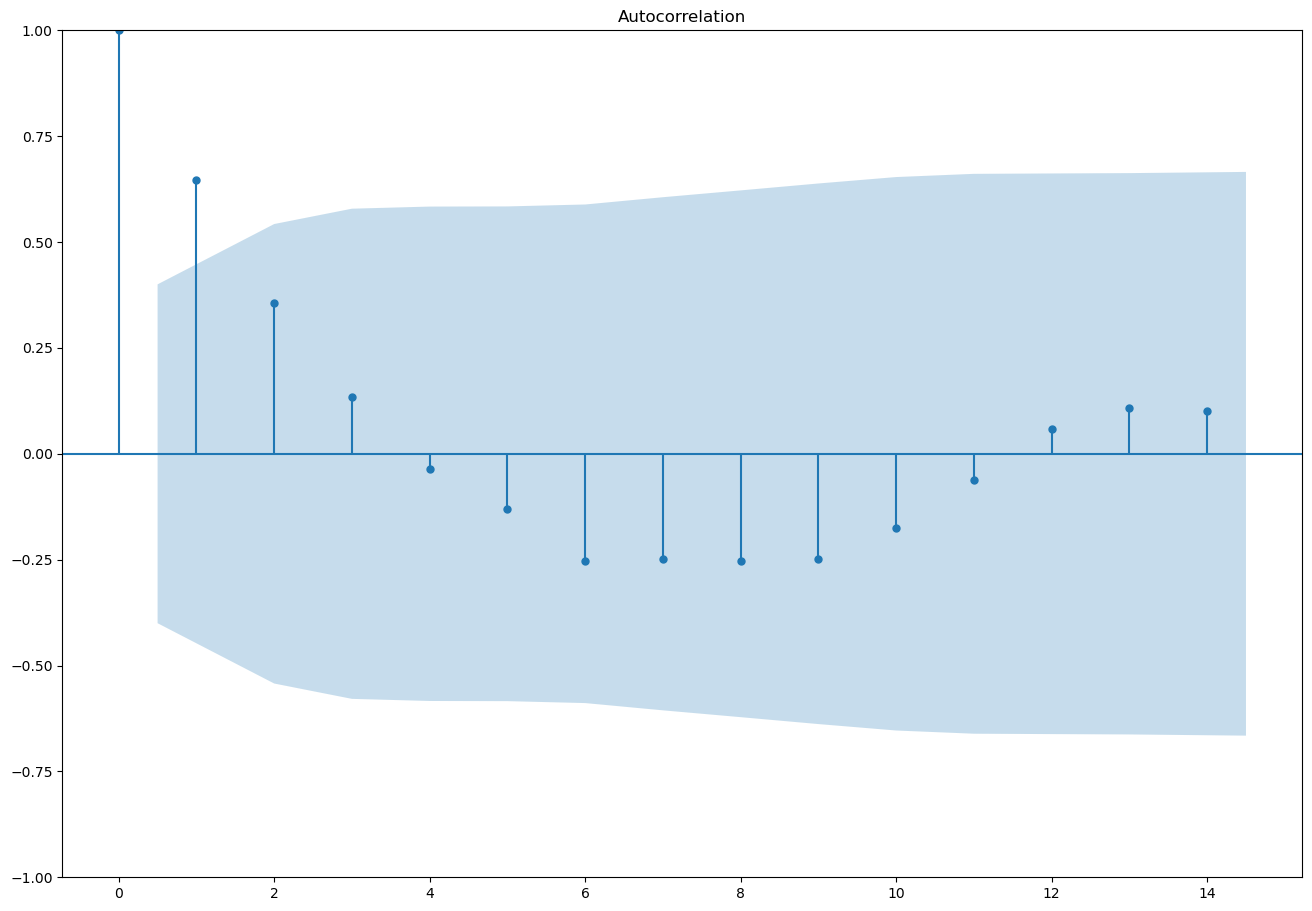

In [1145]:
plot_acf(ser_APAC_p_train)

In [1146]:
p = 10
mod_APAC_p_ar = sm.tsa.ARIMA(ser_APAC_p_train, order = (p, 0, 0)).fit()
print(mod_APAC_p_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 -49.119
Date:                Sat, 20 Apr 2024   AIC                            122.237
Time:                        23:58:00   BIC                            136.374
Sample:                    12-31-1990   HQIC                           125.988
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3565      0.897      7.085      0.000       4.598       8.115
ar.L1          0.6469      0.431      1.500      0.134      -0.198       1.492
ar.L2         -0.1465      0.628     -0.233      0.8

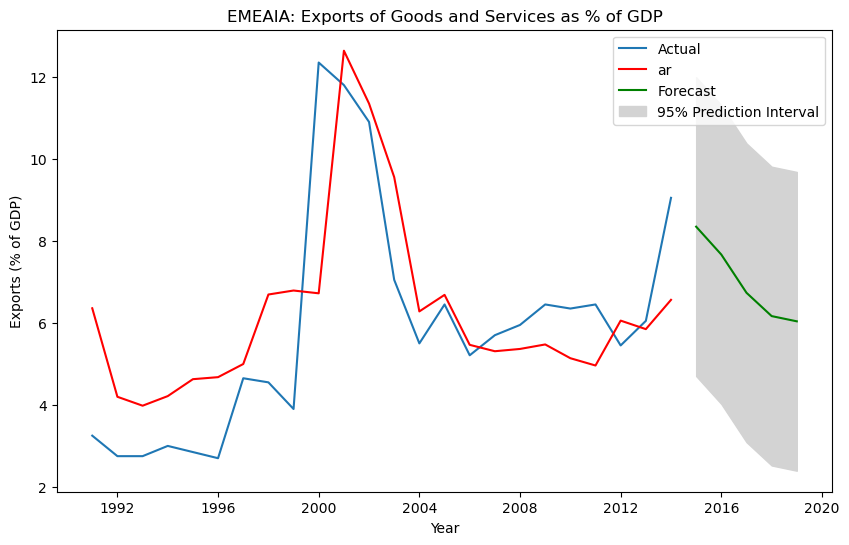

In [1147]:
plot_forecast(ser_APAC_p_train, mod_APAC_p_ar, 'ar', len(ser_APAC_p_test)+2)

In [1148]:
get_metrics(ser_APAC_p_train, ser_APAC_p_test, mod_APAC_p_ar, 'AR', APAC_P)

model  train_rmse  test_rmse      2017     2018
0   ETS    2.210737   1.043301  9.426031  9.75111
1    AR    1.894940   2.252337  6.166048  6.03830

In [1149]:
q = 5
mod_APAC_p_ma = sm.tsa.ARIMA(ser_APAC_p_train, order = (0, 0, q)).fit()
print(mod_APAC_p_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -50.223
Date:                Sat, 20 Apr 2024   AIC                            114.446
Time:                        23:58:01   BIC                            122.692
Sample:                    12-31-1990   HQIC                           116.633
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9954      2.085      2.876      0.004       1.910      10.081
ma.L1          0.8130      0.980      0.830      0.407      -1.107       2.733
ma.L2          0.5401      1.013      0.533      0.5

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [1150]:
get_metrics(ser_APAC_p_train, ser_APAC_p_test, mod_APAC_p_ma, 'MA', APAC_P)

model  train_rmse  test_rmse      2017      2018
0   ETS    2.210737   1.043301  9.426031  9.751110
1    AR    1.894940   2.252337  6.166048  6.038300
2    MA    1.969428   2.221836  6.457532  6.521787

In [1151]:
kpss_level(ser_APAC_p_train, 10)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\491038890.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data, nlags=lags)


0.29762025682206505

In [1152]:
kpss_trend(ser_APAC_p_train, 10)

0.16694135697452955

In [1153]:
ser_APAC_p_train = ser_APAC_p_train.diff().dropna()

In [1154]:
mod_APAC_p_auto_arima = pm.auto_arima(ser_APAC_p_train, stepwise=False, seasoAPACl=True)
mod_APAC_p_auto_arima

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1155]:
mod_APAC_p_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                        SARIMAX   Log Likelihood                 -50.233
Date:                Sat, 20 Apr 2024   AIC                            104.466
Time:                        23:58:03   BIC                            106.737
Sample:                    12-31-1991   HQIC                           105.038
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2522      0.648      0.389      0.697      -1.017       1.522
sigma2         4.6192      0.930      4.966      0.000       2.796       6.442
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                64.28
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             2.16
Prob(H) (two-sided):                  0.35   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1156]:
get_metrics(ser_APAC_p_train, ser_APAC_p_test, mod_APAC_p_auto_arima, 'ARIMA', APAC_P)

model  train_rmse  test_rmse      2017      2018
0    ETS    2.210737   1.043301  9.426031  9.751110
1     AR    1.894940   2.252337  6.166048  6.038300
2     MA    1.969428   2.221836  6.457532  6.521787
3  ARIMA    2.149242   8.547949  0.252174  0.252174

In [1157]:
fitted, conf = mod_APAC_p_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

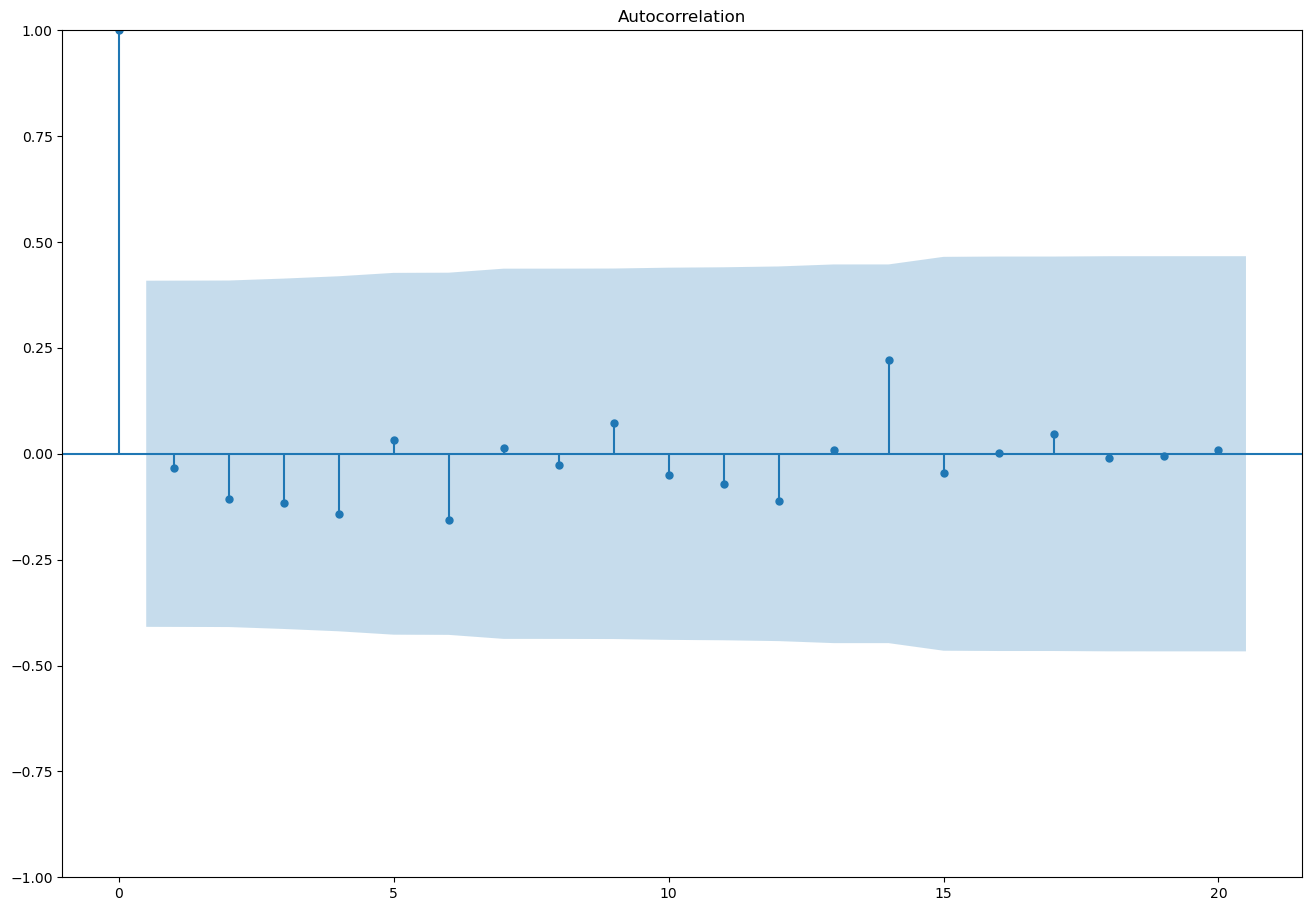

In [1158]:
residuals = ser_APAC_p_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

## --------------------------------------------------------------------------------------------------------

### *3. Super Premium*

In [1159]:
df_APAC_sp = dfs['df_NA_Super Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\318435198.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\318435198.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


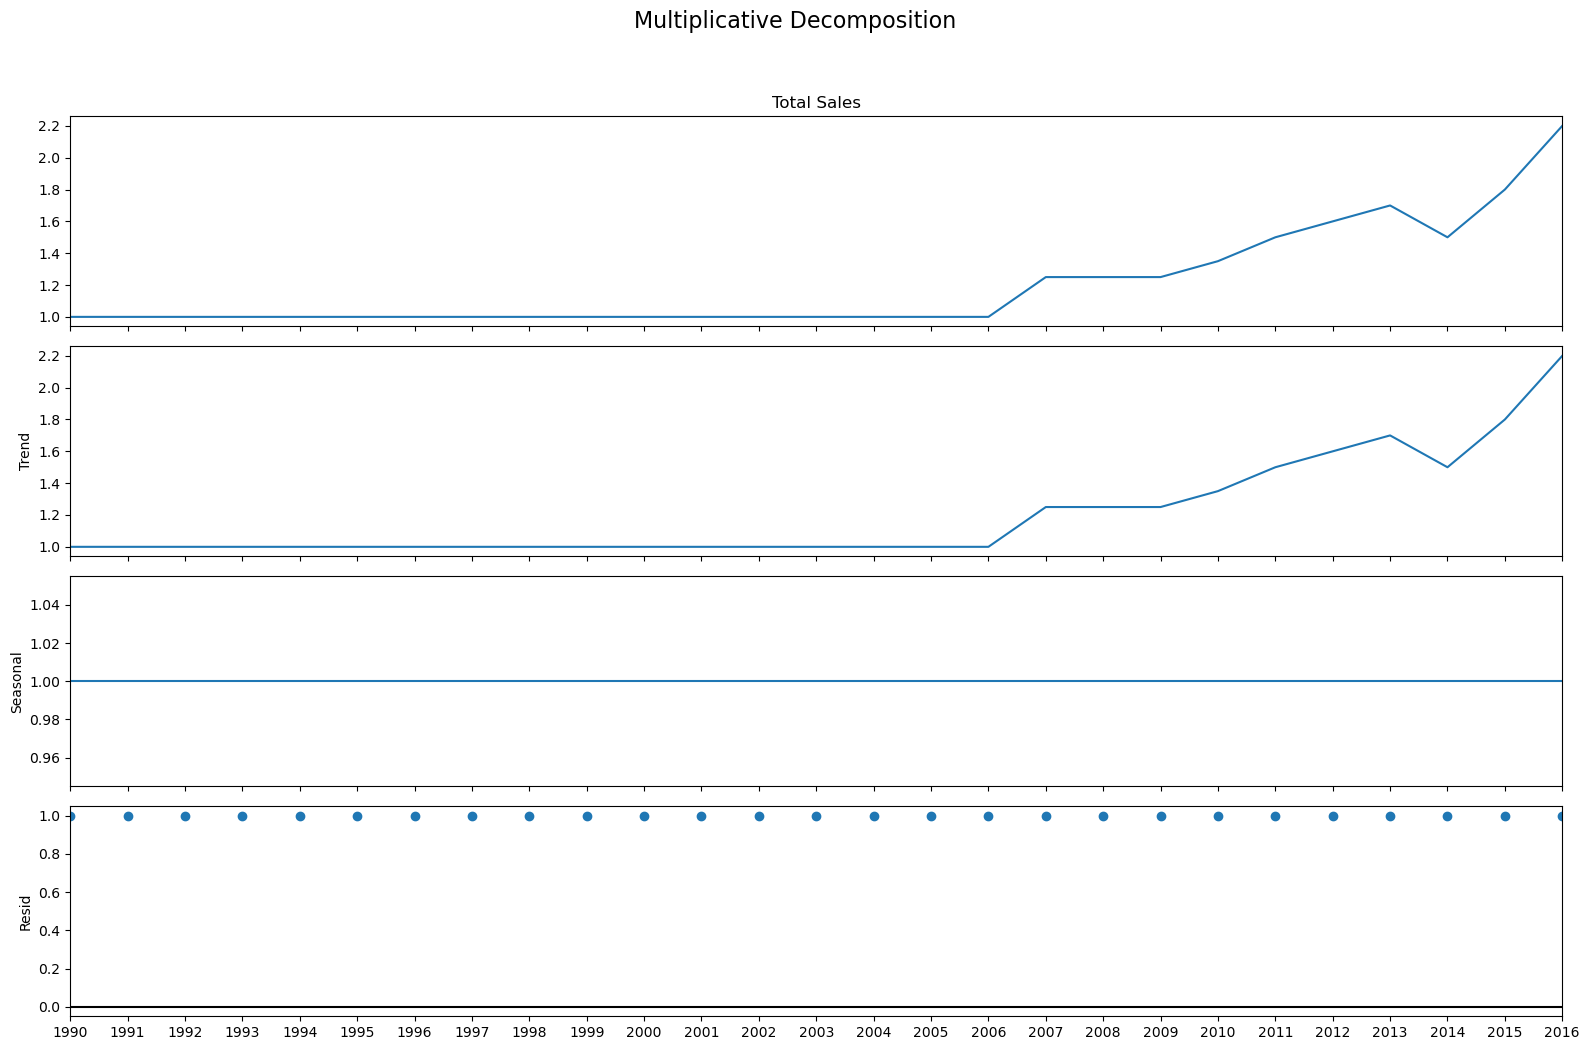

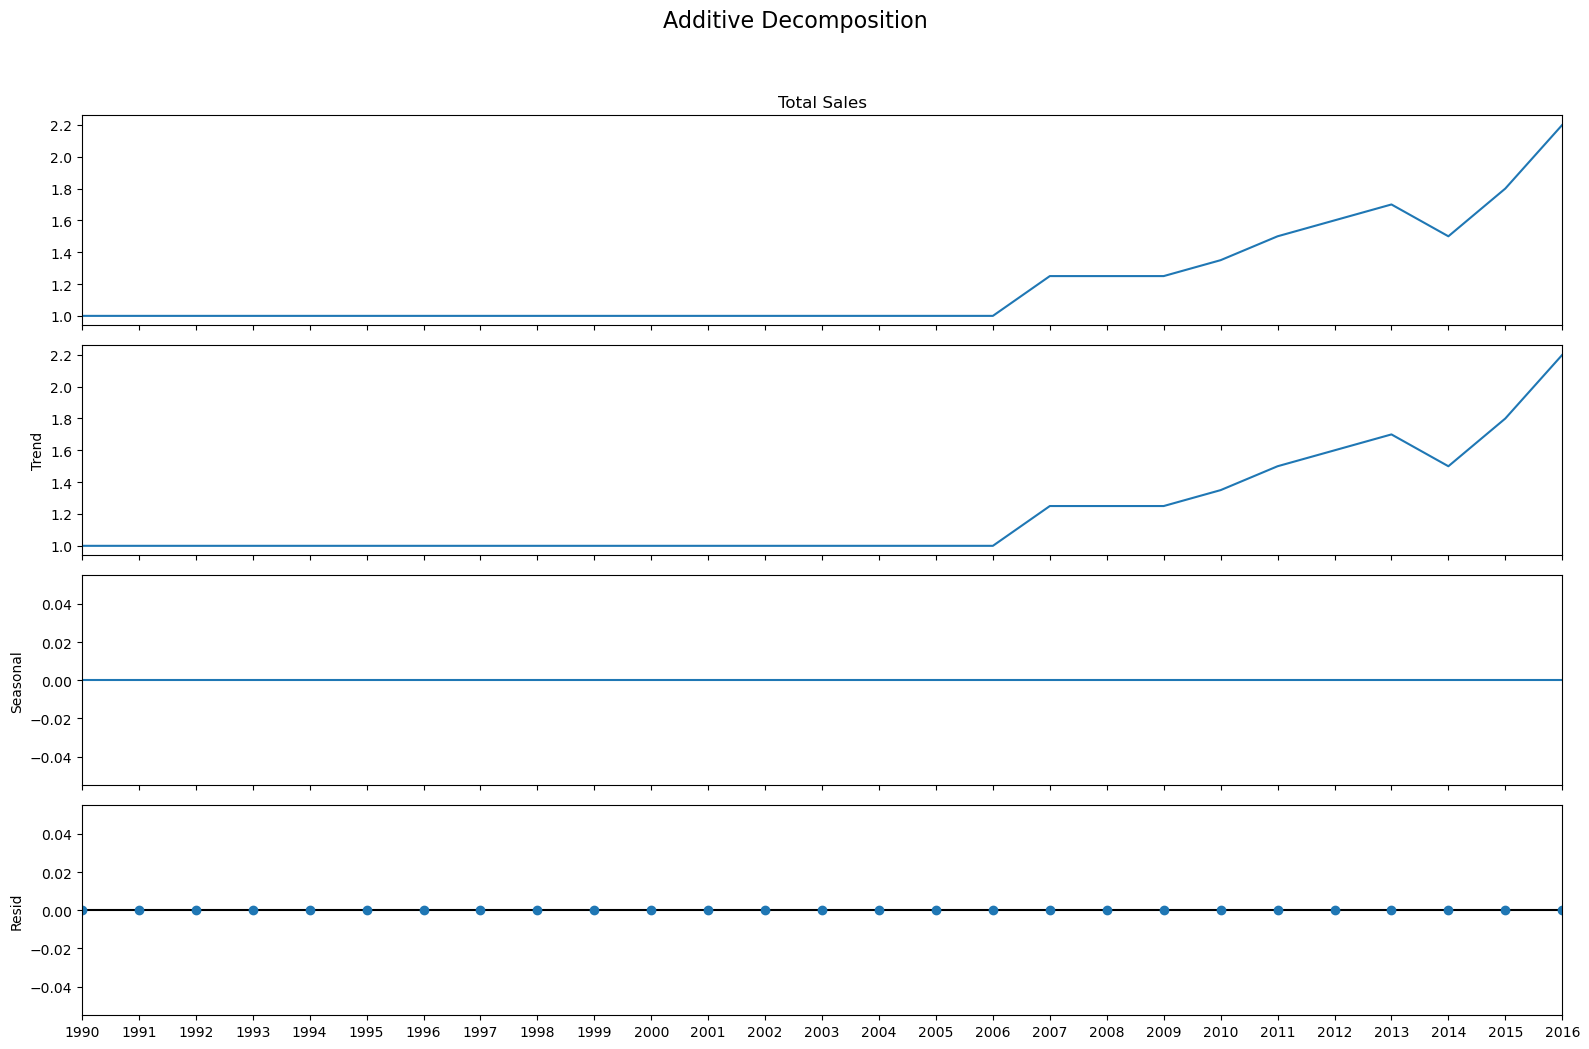

In [1160]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_APAC_sp.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_APAC_sp.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1161]:
k = np.floor(df_APAC_sp.shape[0]*.9).astype('int')
df_APAC_sp_train = df_APAC_sp.iloc[0:k,:]
df_APAC_sp_test = df_APAC_sp.iloc[k:, :]

In [1162]:
ser_APAC_sp_train = pd.Series(df_APAC_sp_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_APAC_sp_train), freq = "A"))
ser_APAC_sp_test = pd.Series(df_APAC_sp_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_APAC_sp_test), freq = "A"))

In [1163]:
APAC_SP = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1164]:
# ETS
mod_APAC_sp_ets = ETSModel(ser_APAC_sp_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_APAC_sp_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                  33.716
Date:                Sat, 20 Apr 2024   AIC                            -55.432
Time:                        23:58:06   BIC                            -48.364
Sample:                    12-31-1990   HQIC                           -53.557
                         - 12-31-2013   Scale                            0.003
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4711      0.399      1.181      0.238      -0.311       1.253
smoothing_trend     0.3176      0.226      1.408      0.159      -0.124       0.760
damping_trend       0.9800      

In [1165]:
get_metrics(ser_APAC_sp_train, ser_APAC_sp_test, mod_APAC_sp_ets, 'ETS', APAC_SP)

model  train_rmse  test_rmse      2017      2018
0   ETS    0.057336   0.212811  2.114902  2.216181

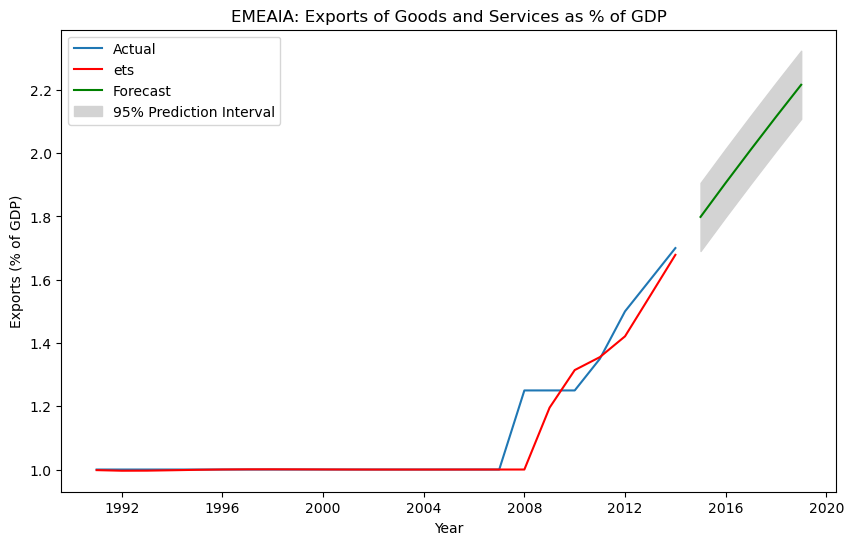

In [1166]:
plot_forecast(ser_APAC_sp_train, mod_APAC_sp_ets, 'ets', len(ser_APAC_sp_test)+2)

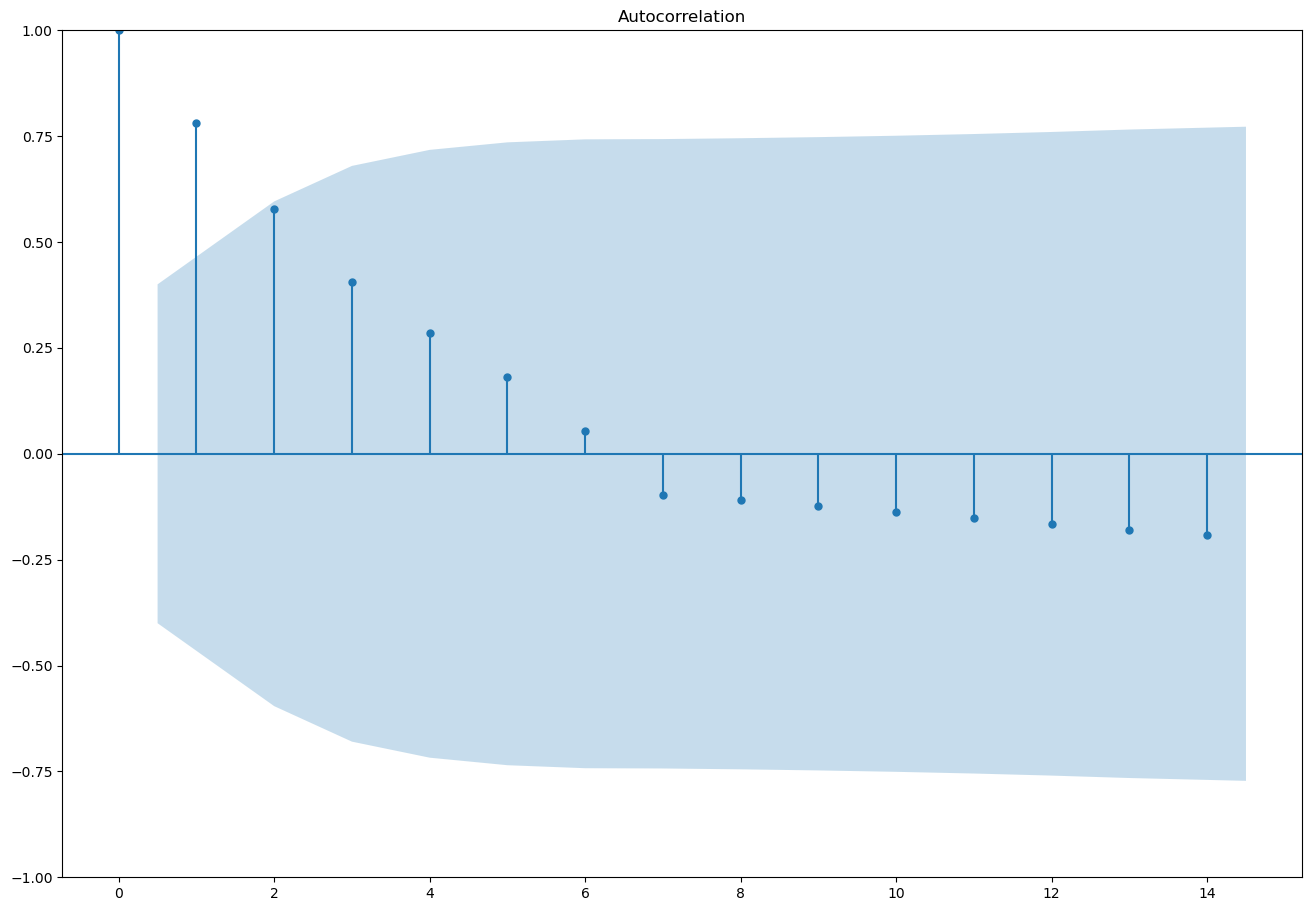

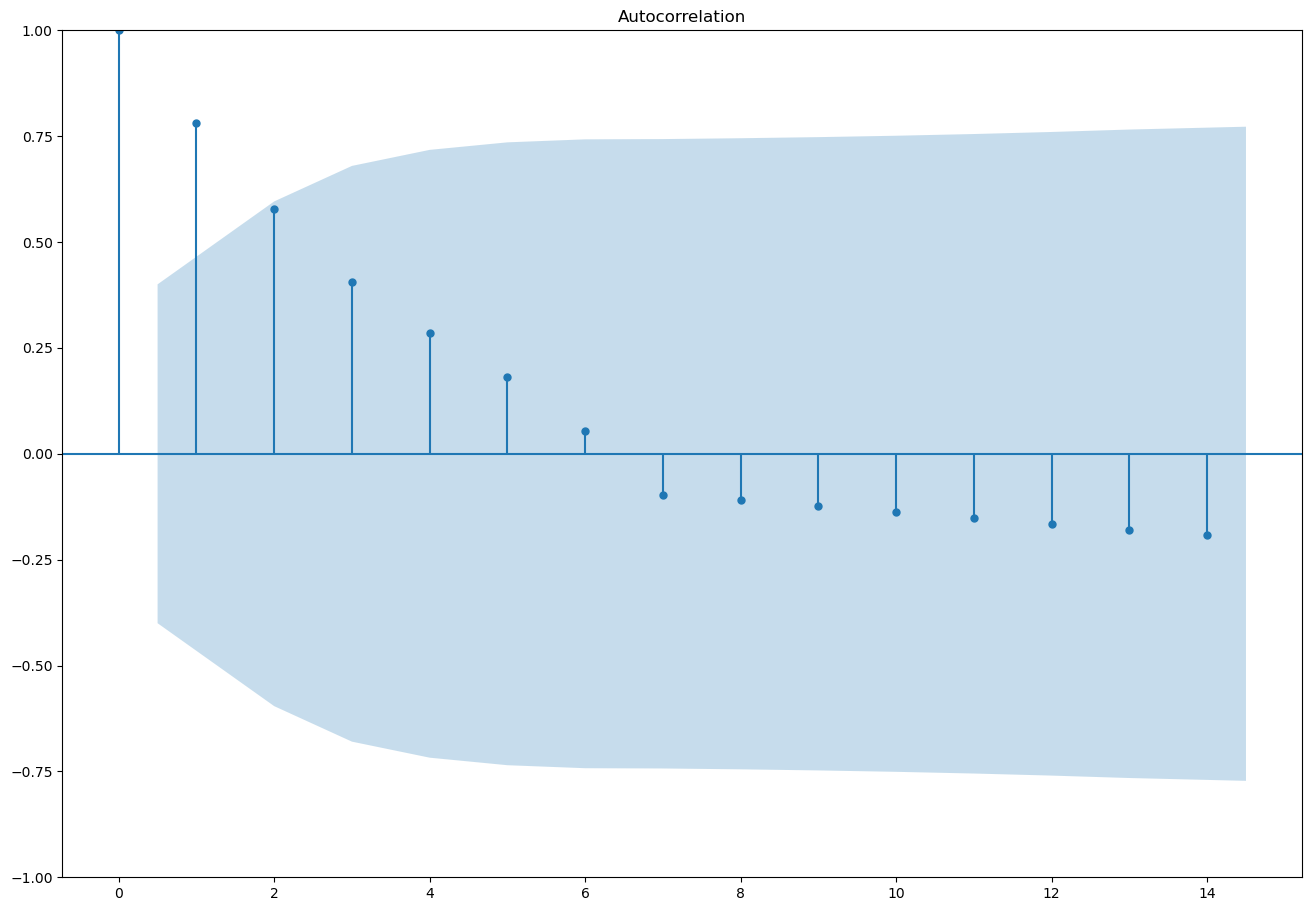

In [1167]:
plot_acf(ser_APAC_sp_train)

In [1168]:
p = 10
mod_APAC_sp_ar = sm.tsa.ARIMA(ser_APAC_sp_train, order = (p, 0, 0)).fit()
print(mod_APAC_sp_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                  33.545
Date:                Sat, 20 Apr 2024   AIC                            -43.091
Time:                        23:58:07   BIC                            -28.954
Sample:                    12-31-1990   HQIC                           -39.340
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3397      1.215      1.102      0.270      -1.042       3.722
ar.L1          0.9550      4.955      0.193      0.847      -8.757      10.667
ar.L2          0.0366      5.273      0.007      0.9

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


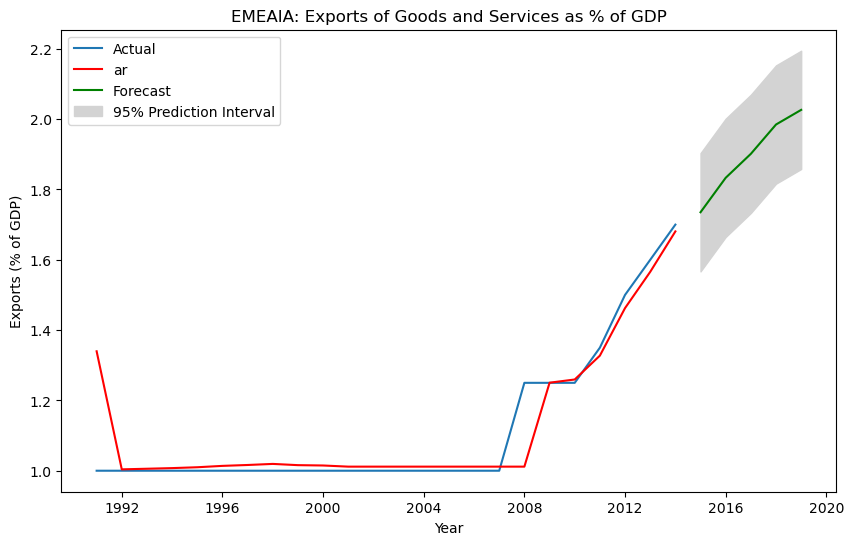

In [1169]:
plot_forecast(ser_APAC_sp_train, mod_APAC_sp_ar, 'ar', len(ser_APAC_sp_test)+2)

In [1170]:
get_metrics(ser_APAC_sp_train, ser_APAC_sp_test, mod_APAC_sp_ar, 'AR', APAC_SP)

model  train_rmse  test_rmse      2017      2018
0   ETS    0.057336   0.212811  2.114902  2.216181
1    AR    0.086178   0.220275  1.984760  2.026408

In [1171]:
q = 5
mod_APAC_sp_ma = sm.tsa.ARIMA(ser_APAC_sp_train, order = (0, 0, q)).fit()
print(mod_APAC_sp_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                  27.079
Date:                Sat, 20 Apr 2024   AIC                            -40.158
Time:                        23:58:08   BIC                            -31.911
Sample:                    12-31-1990   HQIC                           -37.970
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1593      0.290      3.994      0.000       0.590       1.728
ma.L1          1.4389      0.403      3.566      0.000       0.648       2.230
ma.L2          1.4677      1.534      0.957      0.3

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [1172]:
get_metrics(ser_APAC_sp_train, ser_APAC_sp_test, mod_APAC_sp_ma, 'MA', APAC_SP)

model  train_rmse  test_rmse      2017      2018
0   ETS    0.057336   0.212811  2.114902  2.216181
1    AR    0.086178   0.220275  1.984760  2.026408
2    MA    0.079745   0.513242  1.244936  1.177789

In [1173]:
kpss_level(ser_APAC_sp_train, 10)

0.3540779756903515

In [1174]:
kpss_trend(ser_APAC_sp_train, 10)

0.1590725981053224

In [1175]:
ser_APAC_sp_train = ser_APAC_sp_train.diff().dropna()

In [1176]:
mod_APAC_sp_auto_arima = pm.auto_arima(ser_APAC_sp_train, stepwise=False, seasoAPACl=True)
mod_APAC_sp_auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1177]:
mod_APAC_sp_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  31.486
Date:                Sat, 20 Apr 2024   AIC                            -56.972
Time:                        23:58:11   BIC                            -53.699
Sample:                    12-31-1991   HQIC                           -56.201
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.003      1.806      0.071      -0.000       0.011
ma.L1         -0.9891      3.240     -0.305      0.760      -7.339       5.361
sigma2         0.0029      0.010      0.295      0.768      -0.017       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                69.49
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):              43.35   Skew:                             2.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1178]:
get_metrics(ser_APAC_sp_train, ser_APAC_sp_test, mod_APAC_sp_auto_arima, 'ARIMA', APAC_SP)

model  train_rmse  test_rmse      2017      2018
0    ETS    0.057336   0.212811  2.114902  2.216181
1     AR    0.086178   0.220275  1.984760  2.026408
2     MA    0.079745   0.513242  1.244936  1.177789
3  ARIMA    0.054410   1.755042  0.112021  0.117457

In [1179]:
fitted, conf = mod_ACAP_sp_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

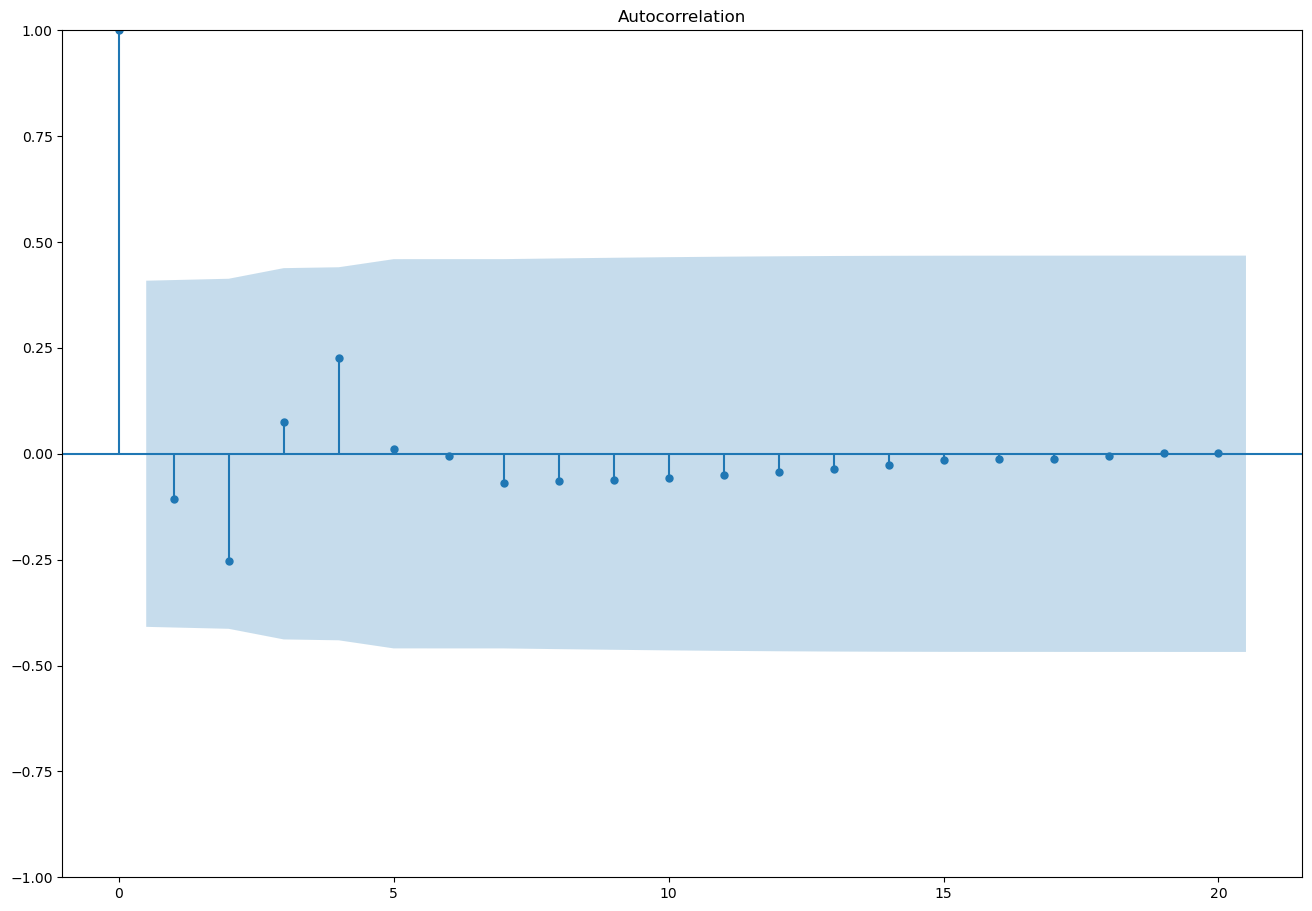

In [1180]:
residuals = ser_ACAP_sp_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

## --------------------------------------------------------------------------------------

### EMEA

### *1. Standard*

In [1181]:
df_EMEA_std = dfs['df_EMEA_Standard']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\1075410103.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\1075410103.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


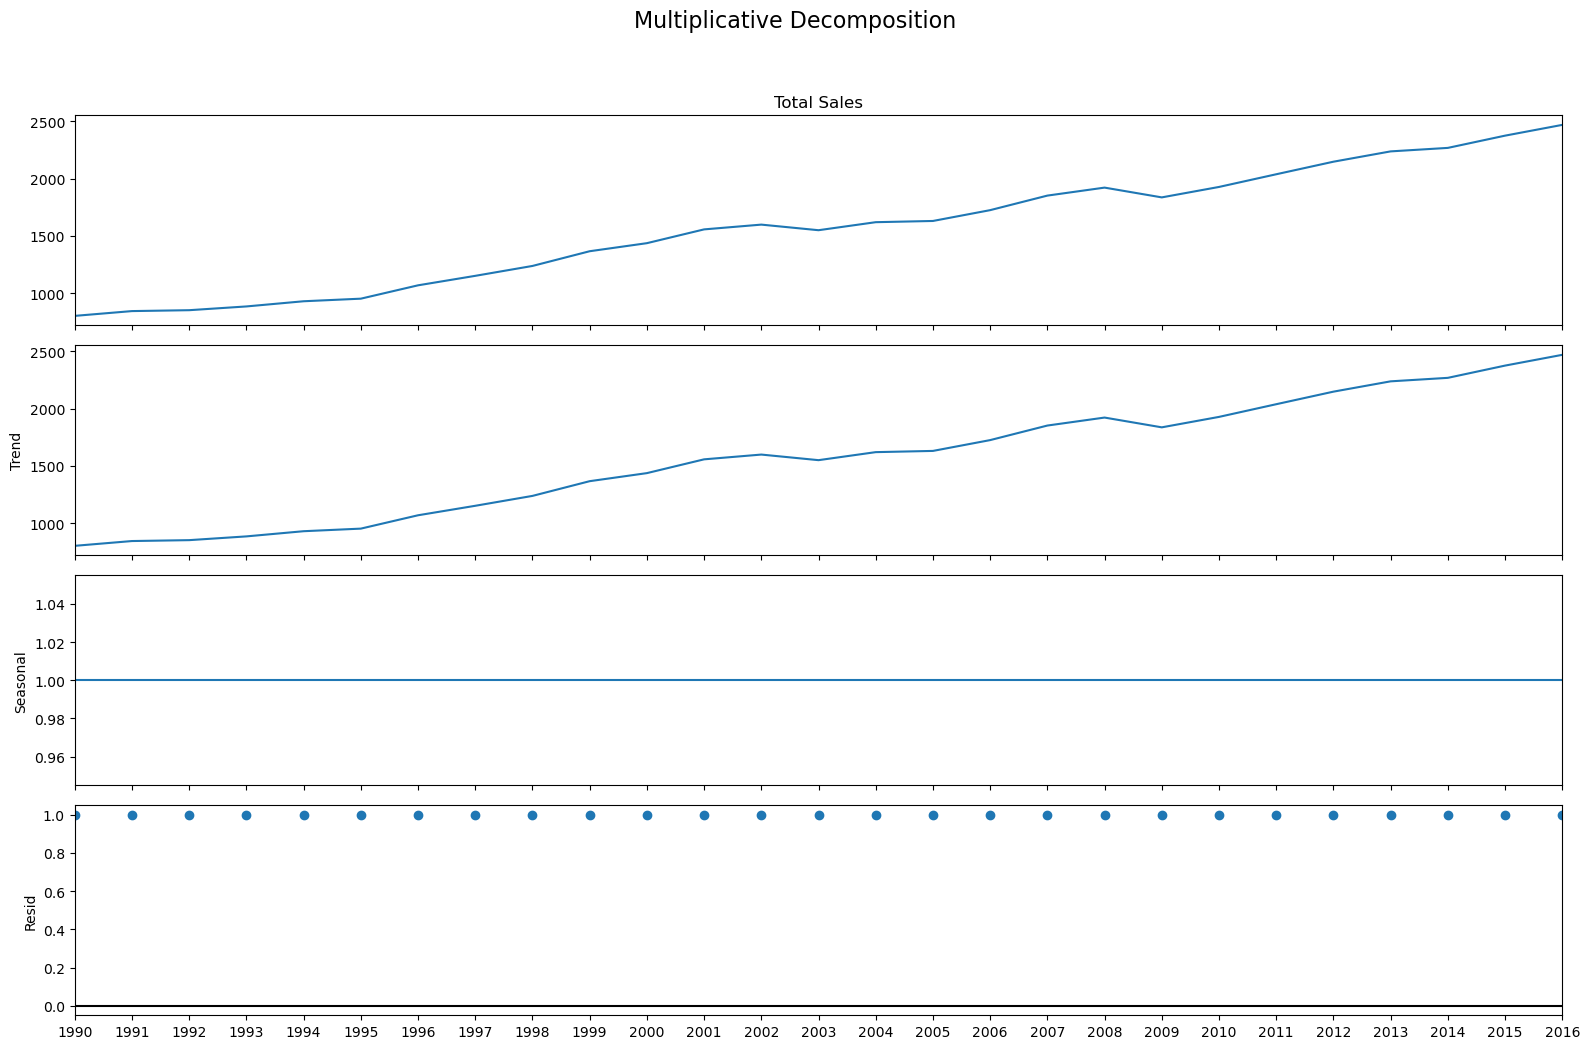

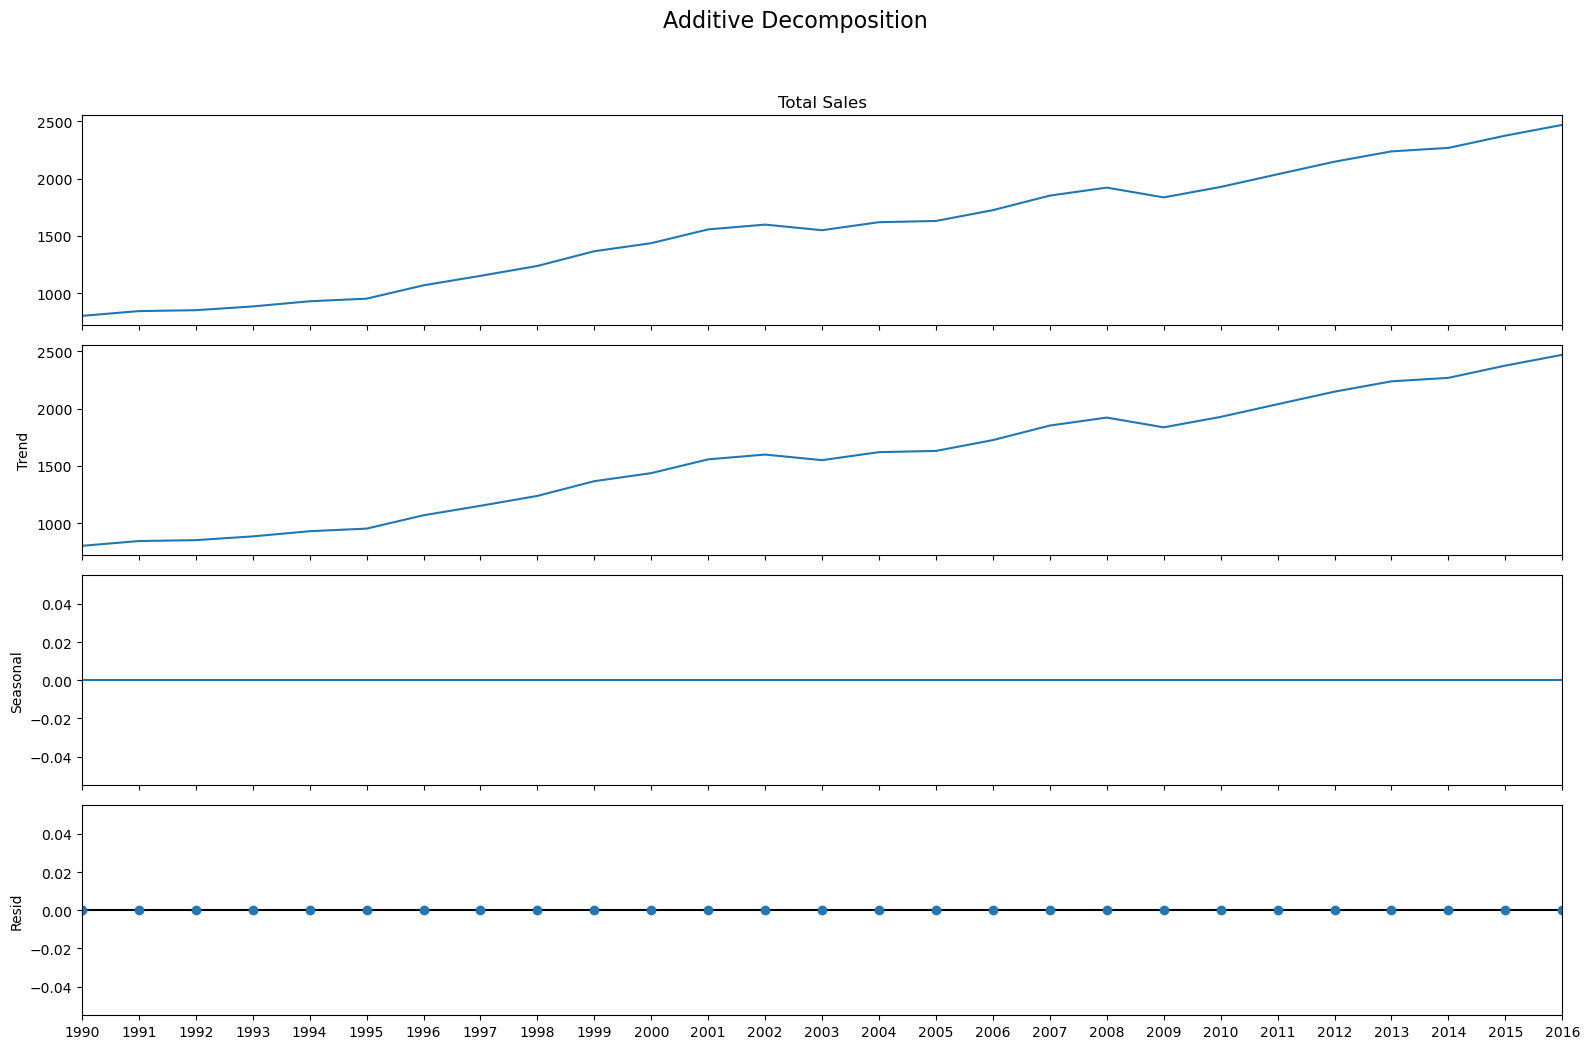

In [1182]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_EMEA_std.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_EMEA_std.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1183]:
k = np.floor(df_EMEA_std.shape[0]*.9).astype('int')
df_EMEA_std_train = df_EMEA_std.iloc[0:k,:]
df_EMEA_std_test = df_EMEA_std.iloc[k:, :]

In [1184]:
ser_EMEA_std_train = pd.Series(df_EMEA_std_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_EMEA_std_train), freq = "A"))
ser_EMEA_std_test = pd.Series(df_EMEA_std_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_EMEA_std_test), freq = "A"))

In [1185]:
EMEA_STD = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1186]:
# ETS
mod_EMEA_std_ets = ETSModel(ser_EMEA_std_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_EMEA_std_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                -128.339
Date:                Sat, 20 Apr 2024   AIC                            268.678
Time:                        23:58:14   BIC                            275.747
Sample:                    12-31-1990   HQIC                           270.554
                         - 12-31-2013   Scale                            0.001
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.228      4.385      0.000       0.553       1.447
smoothing_trend  9.999e-05        nan        nan        nan         nan         nan
damping_trend       0.9800      

In [1187]:
get_metrics(ser_EMEA_std_train, ser_EMEA_std_test, mod_EMEA_std_ets, 'ETS', EMEA_STD)

model  train_rmse  test_rmse        2017         2018
0   ETS   55.296849   74.05939  2393.98378  2430.872574

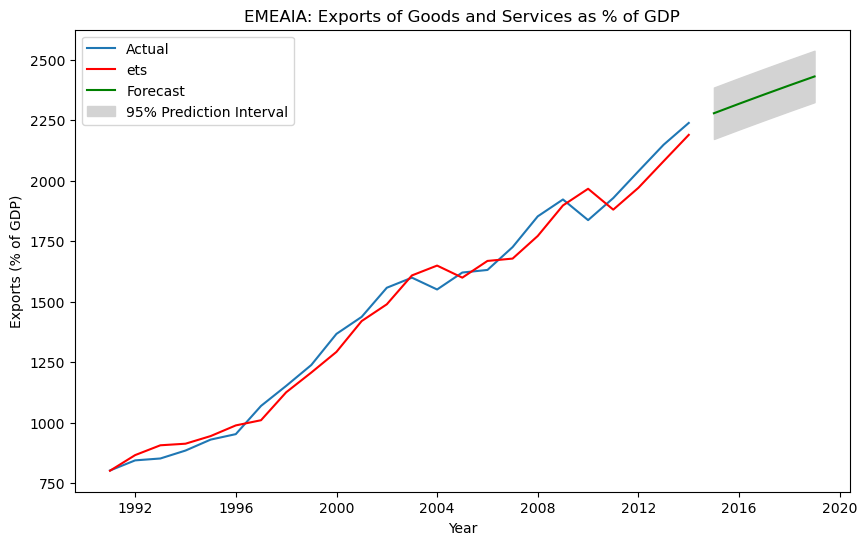

In [1188]:
plot_forecast(ser_EMEA_std_train, mod_EMEA_std_ets, 'ets', len(ser_EMEA_std_test)+2)

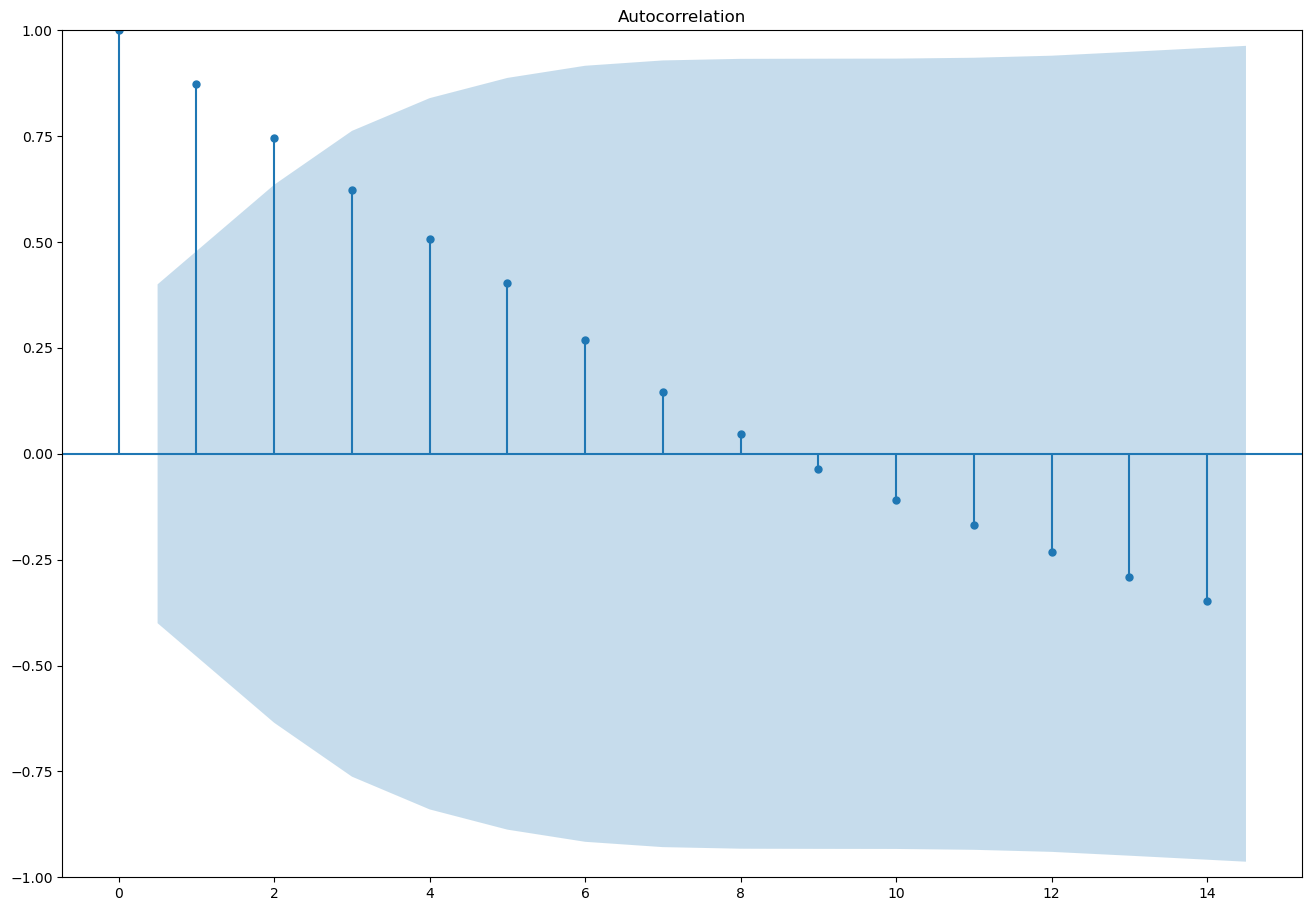

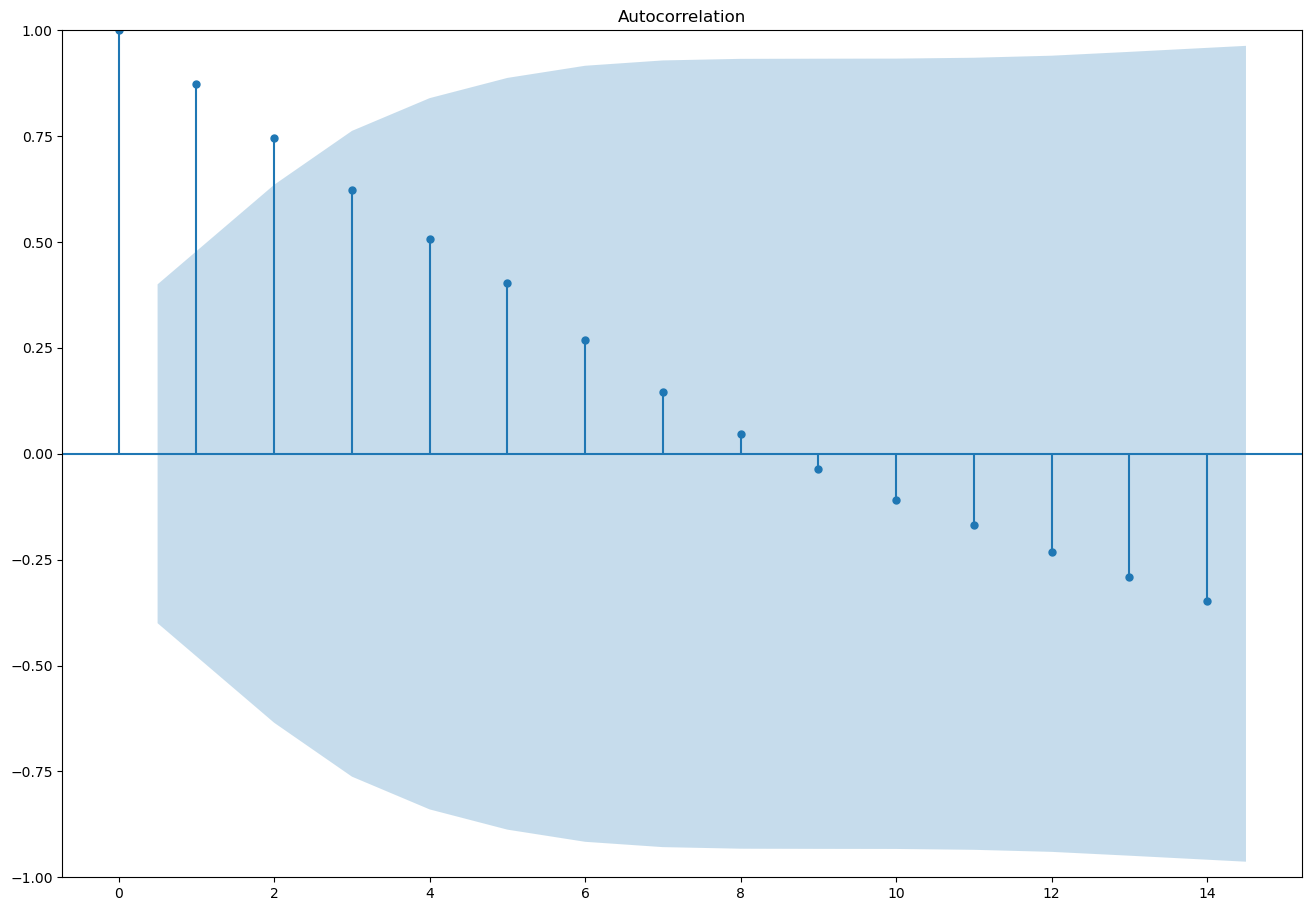

In [1189]:
plot_acf(ser_EMEA_std_train)

In [1190]:
p = 10
mod_EMEA_std_ar = sm.tsa.ARIMA(ser_EMEA_std_train, order = (p, 0, 0)).fit()
print(mod_EMEA_std_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                -133.149
Date:                Sat, 20 Apr 2024   AIC                            290.298
Time:                        23:58:15   BIC                            304.435
Sample:                    12-31-1990   HQIC                           294.049
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1465.8286    437.603      3.350      0.001     608.142    2323.515
ar.L1          1.2826      0.266      4.822      0.000       0.761       1.804
ar.L2         -0.2475      0.318     -0.778      0.4

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


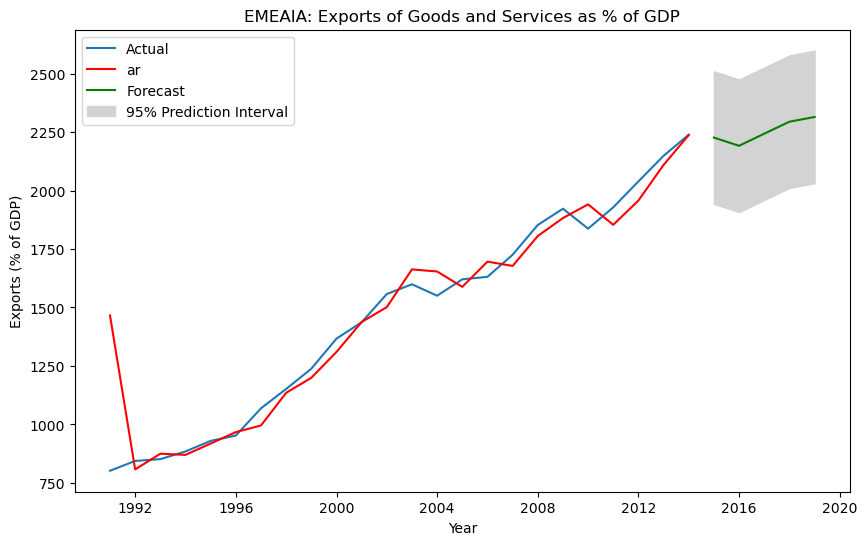

In [1191]:
plot_forecast(ser_EMEA_std_train, mod_EMEA_std_ar, 'ar', len(ser_EMEA_std_test)+2)

In [1192]:
get_metrics(ser_EMEA_std_train, ser_EMEA_std_test, mod_EMEA_std_ar, 'AR', EMEA_STD)

model  train_rmse   test_rmse         2017         2018
0   ETS   55.296849   74.059390  2393.983780  2430.872574
1    AR  145.358913  170.927847  2294.239647  2314.428915

In [1193]:
q = 5
mod_EMEA_std_ma = sm.tsa.ARIMA(ser_EMEA_std_train, order = (0, 0, q)).fit()
print(mod_EMEA_std_ma.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                -143.595
Date:                Sat, 20 Apr 2024   AIC                            301.190
Time:                        23:58:16   BIC                            309.437
Sample:                    12-31-1990   HQIC                           303.378
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1466.4252    129.071     11.361      0.000    1213.450    1719.401
ma.L1          1.6952     44.564      0.038      0.970     -85.649      89.039
ma.L2          2.1788      5.949      0.366      0.7

In [1194]:
get_metrics(ser_EMEA_std_train, ser_EMEA_std_test, mod_EMEA_std_ma, 'MA', EMEA_STD)

model  train_rmse   test_rmse         2017         2018
0   ETS   55.296849   74.059390  2393.983780  2430.872574
1    AR  145.358913  170.927847  2294.239647  2314.428915
2    MA  157.383974  532.969438  1545.940158  1483.050569

In [1195]:
kpss_level(ser_EMEA_std_train, 10)

0.38598384061973307

In [1196]:
kpss_trend(ser_EMEA_std_train, 10)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\432952205.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_trend = kpss(data, regression = 'ct', nlags=lags)


0.21954125696757087

In [1197]:
ser_EMEA_std_train = ser_EMEA_std_train.diff().dropna()

In [1198]:
mod_EMEA_std_auto_arima = pm.auto_arima(ser_EMEA_std_train, stepwise=False, seasoEMEAl=True)
mod_EMEA_std_auto_arima

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1199]:
print(mod_EMEA_std_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:                        SARIMAX   Log Likelihood                -124.322
Date:                Sat, 20 Apr 2024   AIC                            252.644
Time:                        23:58:19   BIC                            254.915
Sample:                    12-31-1991   HQIC                           253.215
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     62.4609     14.611      4.275      0.000      33.824      91.098
sigma2      2900.7116    953.642      3.042      0.002    1031.608    4769.815
Ljung-Box (L1) (Q):                   0.24   Jarque-

In [1200]:
get_metrics(ser_EMEA_std_train, ser_EMEA_std_test, mod_EMEA_std_auto_arima, 'ARIMA', EMEA_STD)

model  train_rmse    test_rmse         2017         2018
0    ETS   55.296849    74.059390  2393.983780  2430.872574
1     AR  145.358913   170.927847  2294.239647  2314.428915
2     MA  157.383974   532.969438  1545.940158  1483.050569
3  ARIMA   53.858254  2310.885007    62.460870    62.460870

In [1201]:
fitted, conf = mod_EMEA_std_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

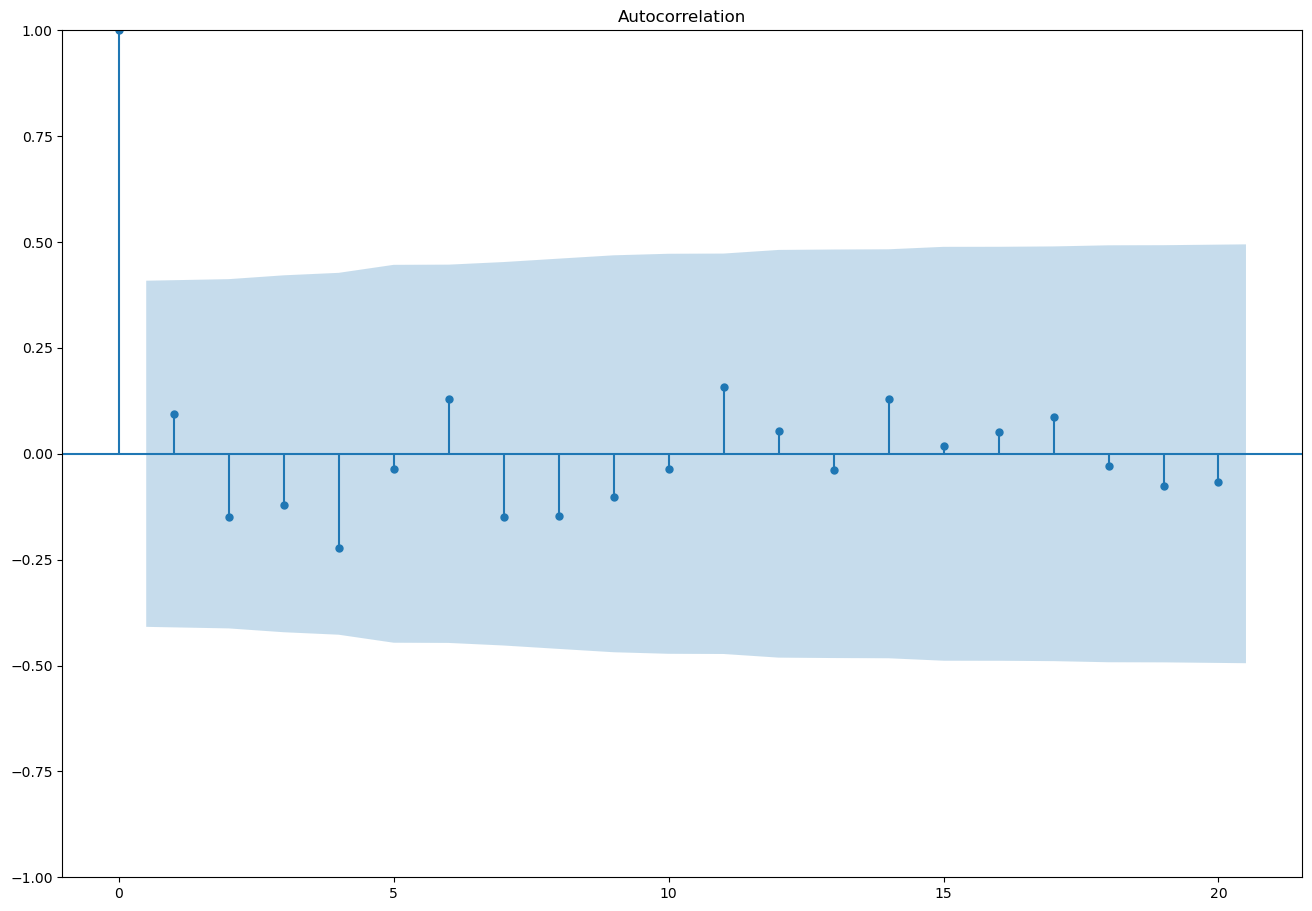

In [1202]:
residuals = ser_EMEA_std_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

## --------------------------------------------------------------------------------------

### *2. Premium*

In [1203]:
df_EMEA_p = dfs['df_EMEA_Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\4116266244.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\4116266244.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


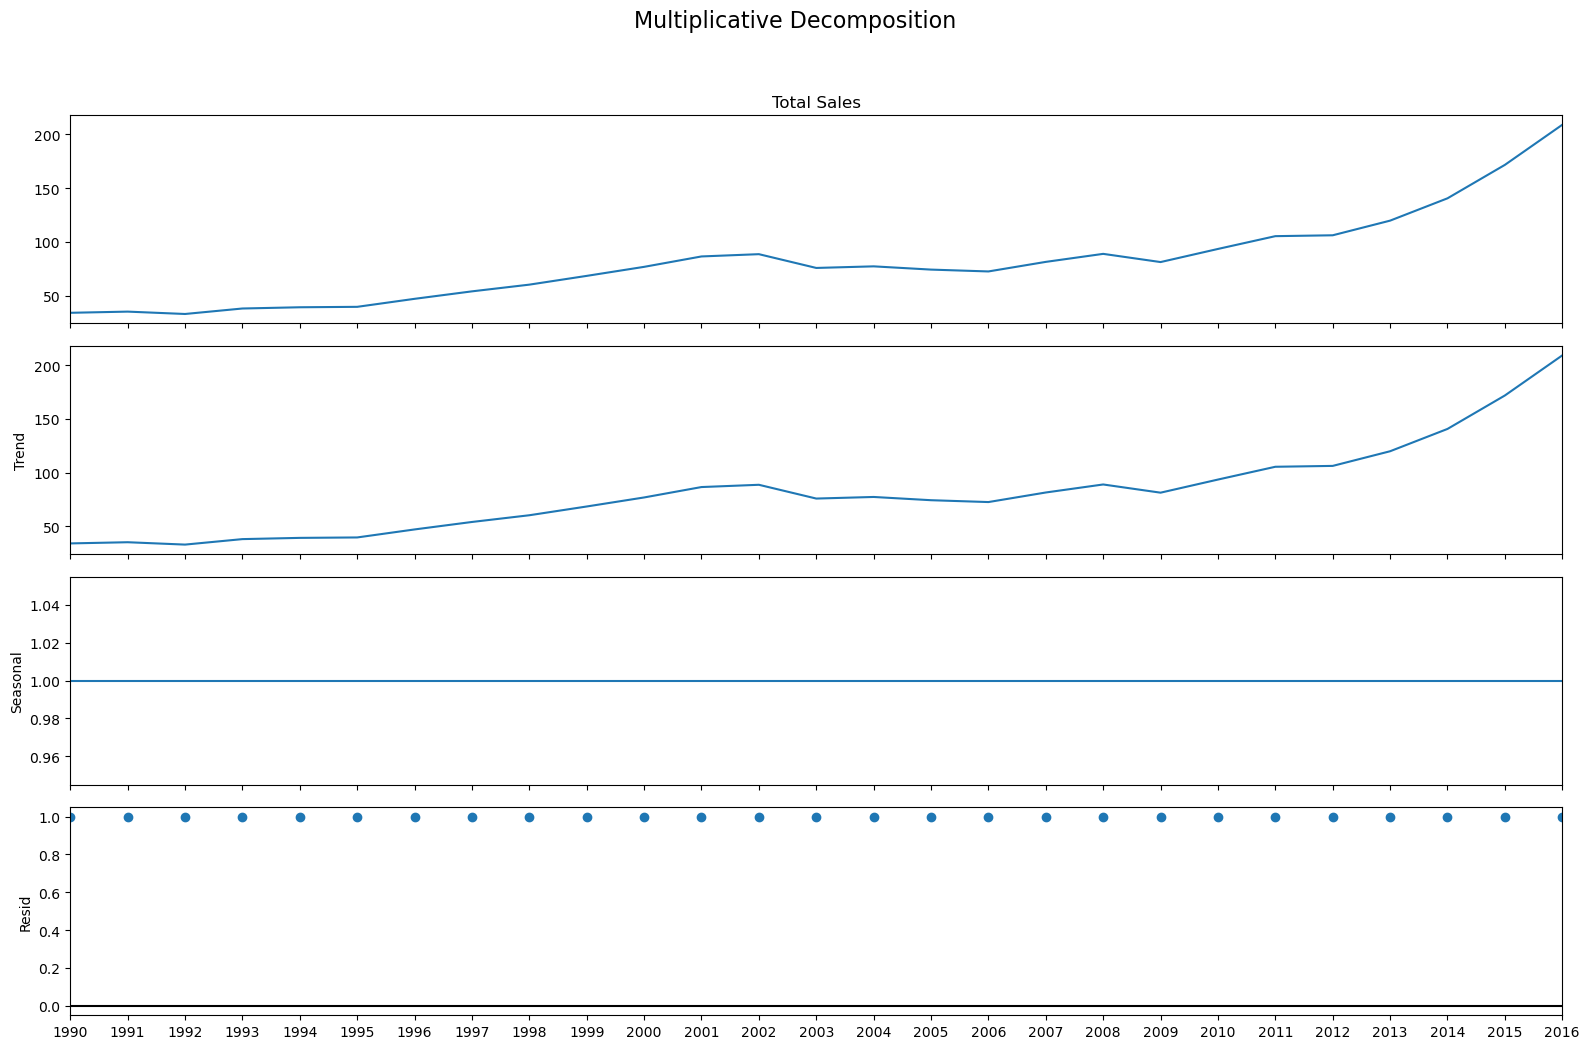

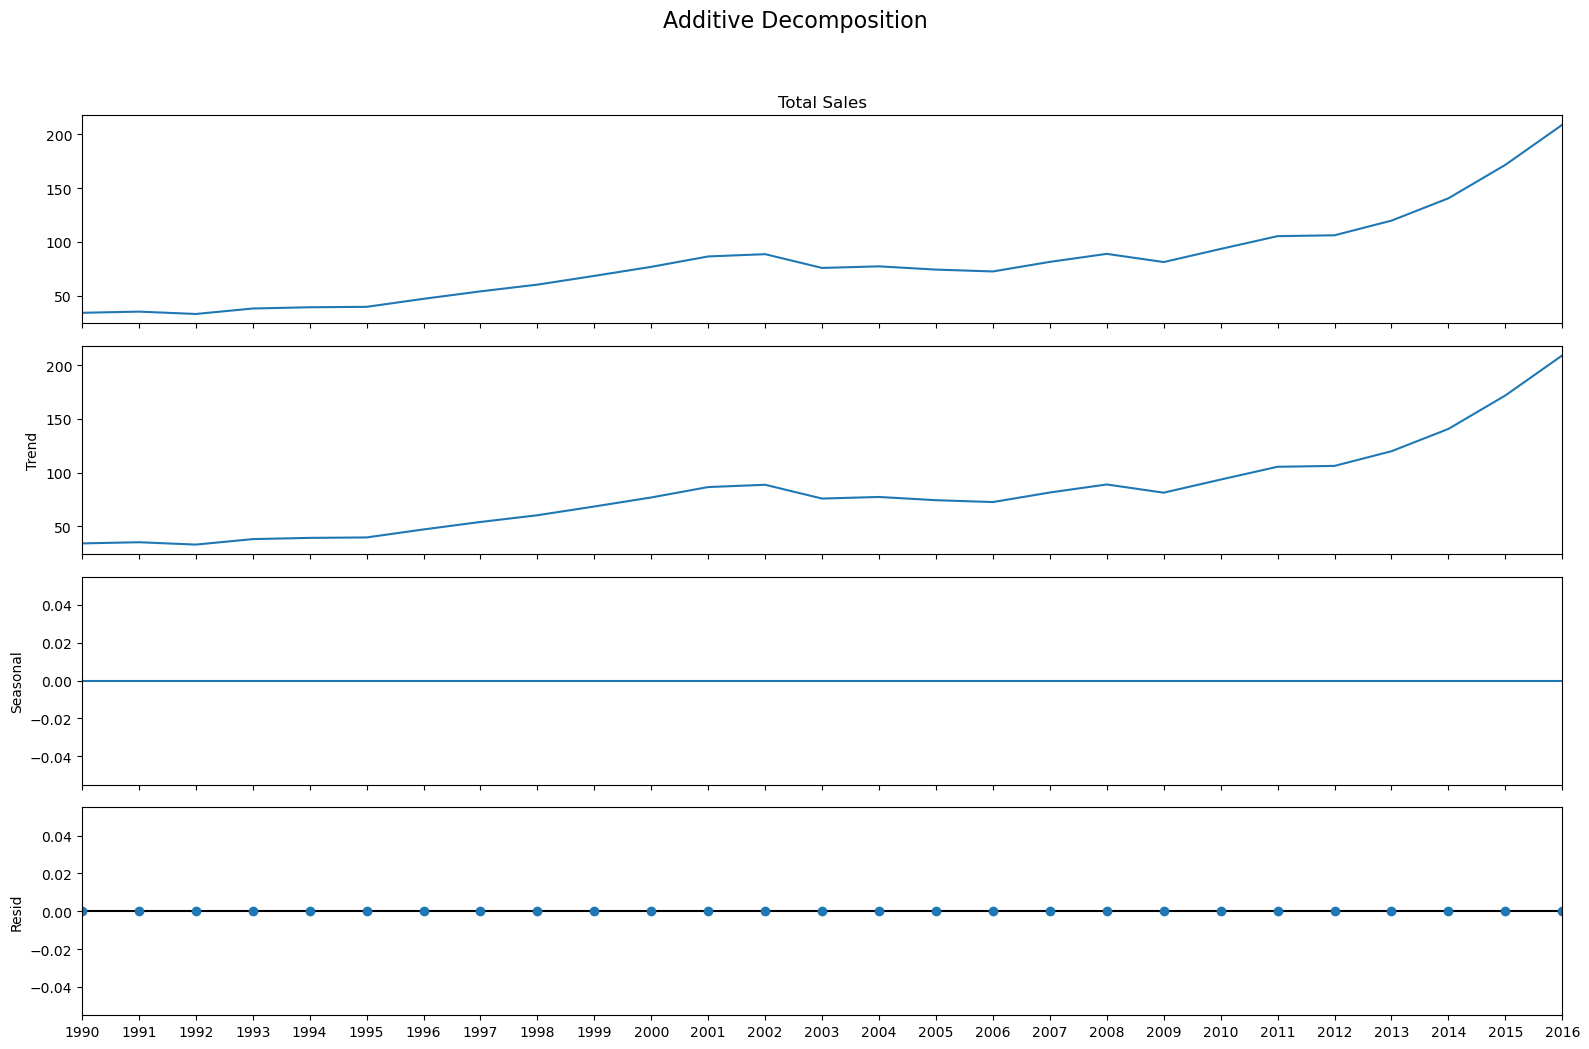

In [1204]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_EMEA_p.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_EMEA_p.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1205]:
k = np.floor(df_EMEA_p.shape[0]*.9).astype('int')
df_EMEA_p_train = df_EMEA_p.iloc[0:k,:]
df_EMEA_p_test = df_EMEA_p.iloc[k:, :]

In [1206]:
ser_EMEA_p_train = pd.Series(df_EMEA_p_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_EMEA_p_train), freq = "A"))
ser_EMEA_p_test = pd.Series(df_EMEA_p_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_EMEA_p_test), freq = "A"))

In [1207]:
EMEA_P = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1208]:
# ETS
mod_EMEA_p_ets = ETSModel(ser_EMEA_p_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_EMEA_p_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -74.671
Date:                Sat, 20 Apr 2024   AIC                            161.343
Time:                        23:58:22   BIC                            168.411
Sample:                    12-31-1990   HQIC                           163.218
                         - 12-31-2013   Scale                            0.007
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.211      4.736      0.000       0.586       1.414
smoothing_trend  9.999e-05        nan        nan        nan         nan         nan
damping_trend       0.9800      

In [1209]:
get_metrics(ser_EMEA_p_train, ser_EMEA_p_test, mod_EMEA_p_ets, 'ETS', EMEA_P)

model  train_rmse  test_rmse        2017        2018
0   ETS    6.388284  56.026519  128.505548  130.564979

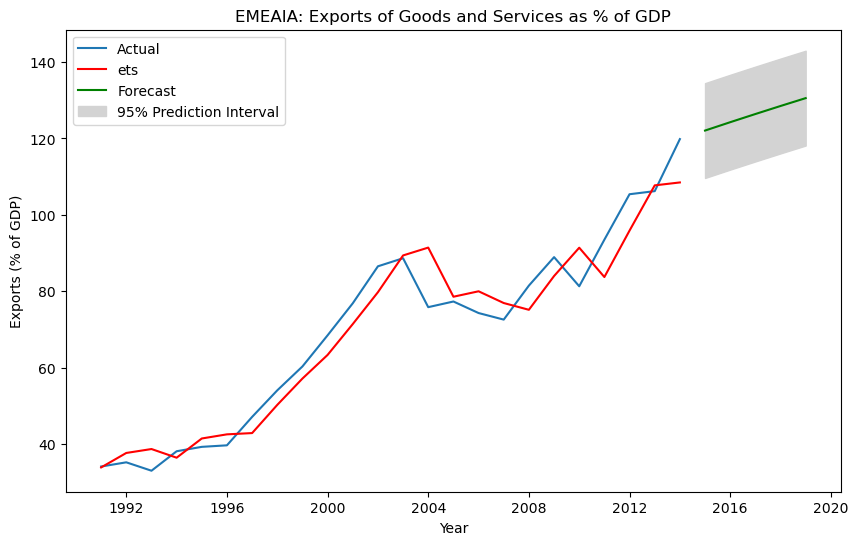

In [1210]:
plot_forecast(ser_EMEA_p_train, mod_EMEA_p_ets, 'ets', len(ser_EMEA_p_test)+2)

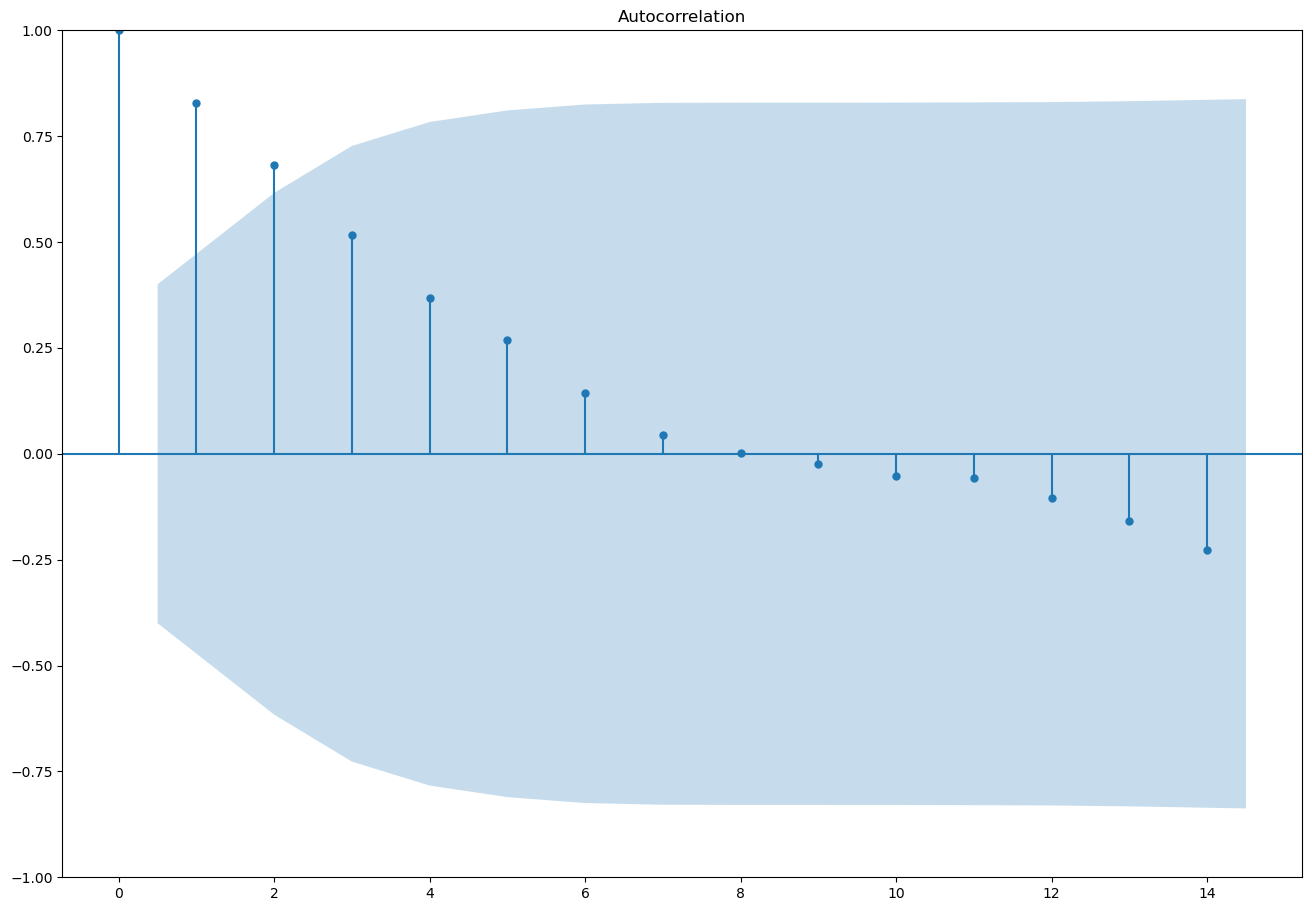

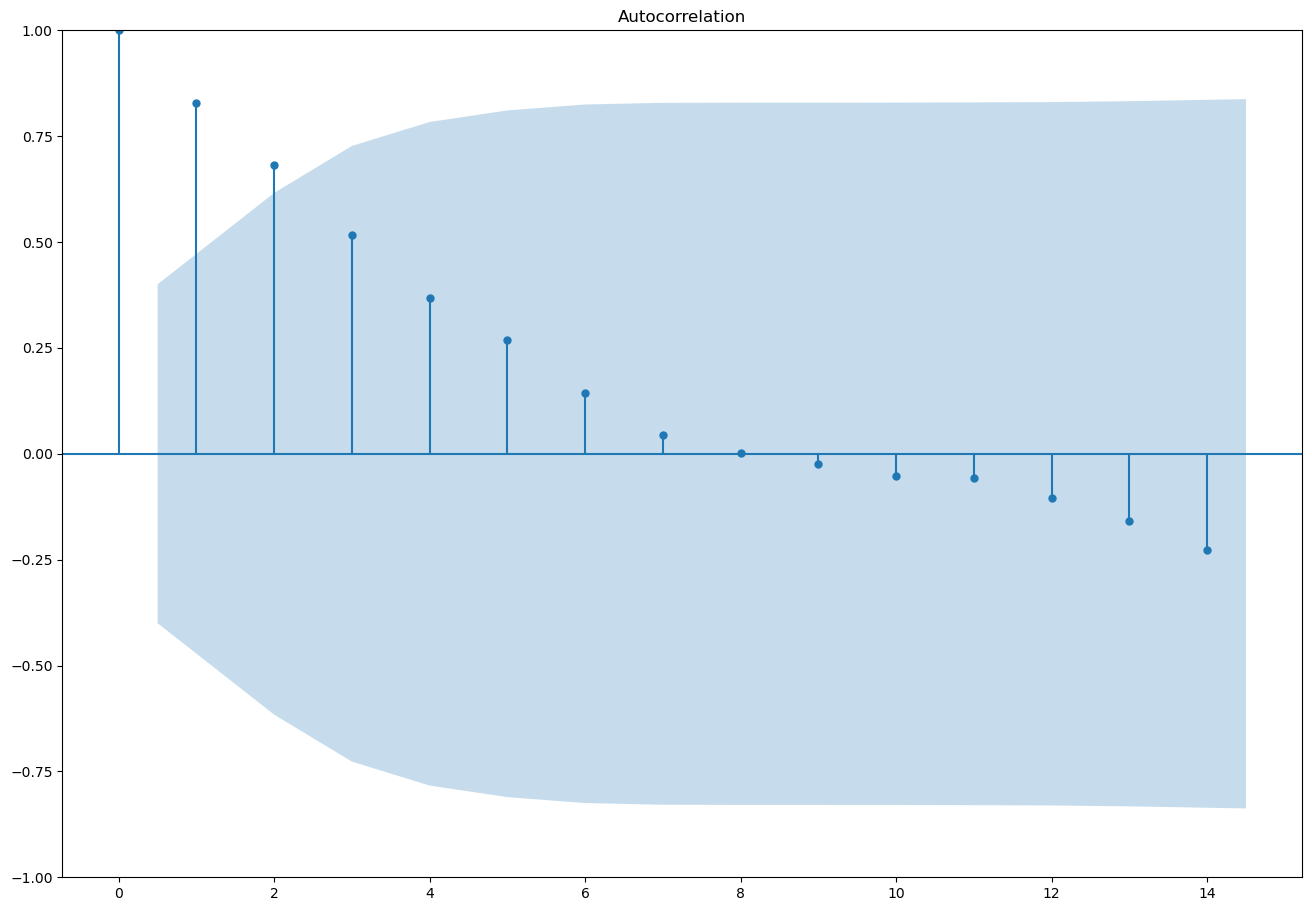

In [1211]:
plot_acf(ser_EMEA_p_train)

In [1212]:
p = 10
mod_EMEA_p_ar = sm.tsa.ARIMA(ser_EMEA_p_train, order = (p, 0, 0)).fit()
print(mod_EMEA_p_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 -77.489
Date:                Sat, 20 Apr 2024   AIC                            178.978
Time:                        23:58:23   BIC                            193.115
Sample:                    12-31-1990   HQIC                           182.728
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.0435     37.276      2.121      0.034       5.985     152.103
ar.L1          1.4735      0.278      5.300      0.000       0.929       2.018
ar.L2         -0.5443      0.506     -1.076      0.2

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


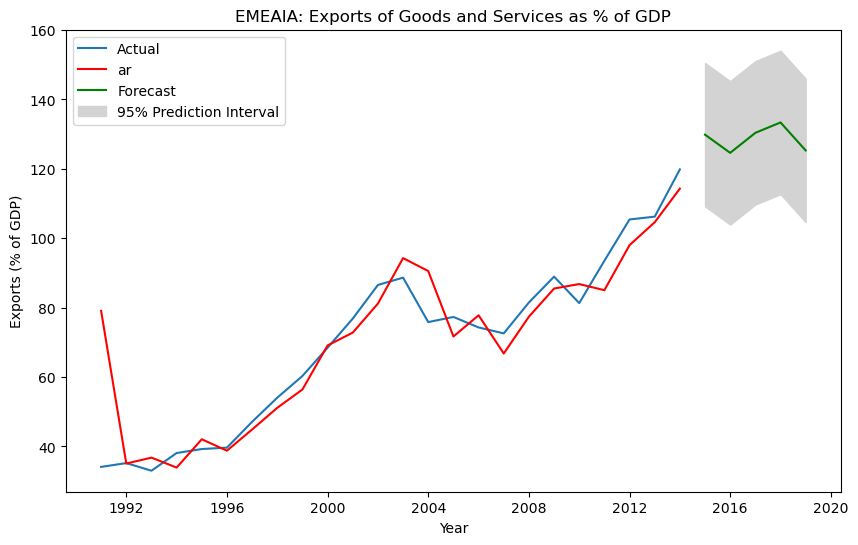

In [1213]:
plot_forecast(ser_EMEA_p_train, mod_EMEA_p_ar, 'ar', len(ser_EMEA_p_test)+2)

In [1214]:
get_metrics(ser_EMEA_p_train, ser_EMEA_p_test, mod_EMEA_p_ar, 'AR', EMEA_P)

model  train_rmse  test_rmse        2017        2018
0   ETS    6.388284  56.026519  128.505548  130.564979
1    AR   10.565415  53.287167  133.359004  125.288917

In [1215]:
q = 5
mod_EMEA_p_ma = sm.tsa.ARIMA(ser_EMEA_p_train, order = (0, 0, q)).fit()
print(mod_EMEA_p_ma.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -83.531
Date:                Sat, 20 Apr 2024   AIC                            181.063
Time:                        23:58:24   BIC                            189.309
Sample:                    12-31-1990   HQIC                           183.251
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.3688      9.422      7.575      0.000      52.902      89.835
ma.L1          1.4181      1.090      1.301      0.193      -0.718       3.554
ma.L2          1.5950      6.739      0.237      0.8

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1216]:
get_metrics(ser_EMEA_p_train, ser_EMEA_p_test, mod_EMEA_p_ma, 'MA', EMEA_P)

model  train_rmse  test_rmse        2017        2018
0   ETS    6.388284  56.026519  128.505548  130.564979
1    AR   10.565415  53.287167  133.359004  125.288917
2    MA   10.212099  81.244376   80.266865   74.148351

In [1217]:
kpss_level(ser_EMEA_p_train, 10)

0.4000017569738975

In [1218]:
kpss_trend(ser_EMEA_p_train, 10)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\432952205.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_trend = kpss(data, regression = 'ct', nlags=lags)


0.21613527164430718

In [1219]:
ser_EMEA_p_train = ser_EMEA_p_train.diff().dropna()

In [1220]:
mod_EMEA_p_auto_arima = pm.auto_arima(ser_EMEA_p_train, stepwise=False, seasonal=True)
mod_EMEA_p_auto_arima

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1221]:
mod_EMEA_p_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                        SARIMAX   Log Likelihood                 -75.308
Date:                Sat, 20 Apr 2024   AIC                            154.616
Time:                        23:58:27   BIC                            156.887
Sample:                    12-31-1991   HQIC                           155.187
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7278      1.498      2.488      0.013       0.791       6.664
sigma2        40.8804     13.271      3.080      0.002      14.869      66.892
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.67
Prob(Q):                              0.76   Prob(JB):                         0.43
Heteroskedasticity (H):               4.82   Skew:                            -0.66
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1222]:
get_metrics(ser_EMEA_p_train, ser_EMEA_p_test, mod_EMEA_p_auto_arima, 'ARIMA', EMEA_P)

model  train_rmse   test_rmse        2017        2018
0    ETS    6.388284   56.026519  128.505548  130.564979
1     AR   10.565415   53.287167  133.359004  125.288917
2     MA   10.212099   81.244376   80.266865   74.148351
3  ARIMA    6.393781  172.325920    3.727826    3.727826

In [1223]:
fitted, conf = mod_EMEA_p_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

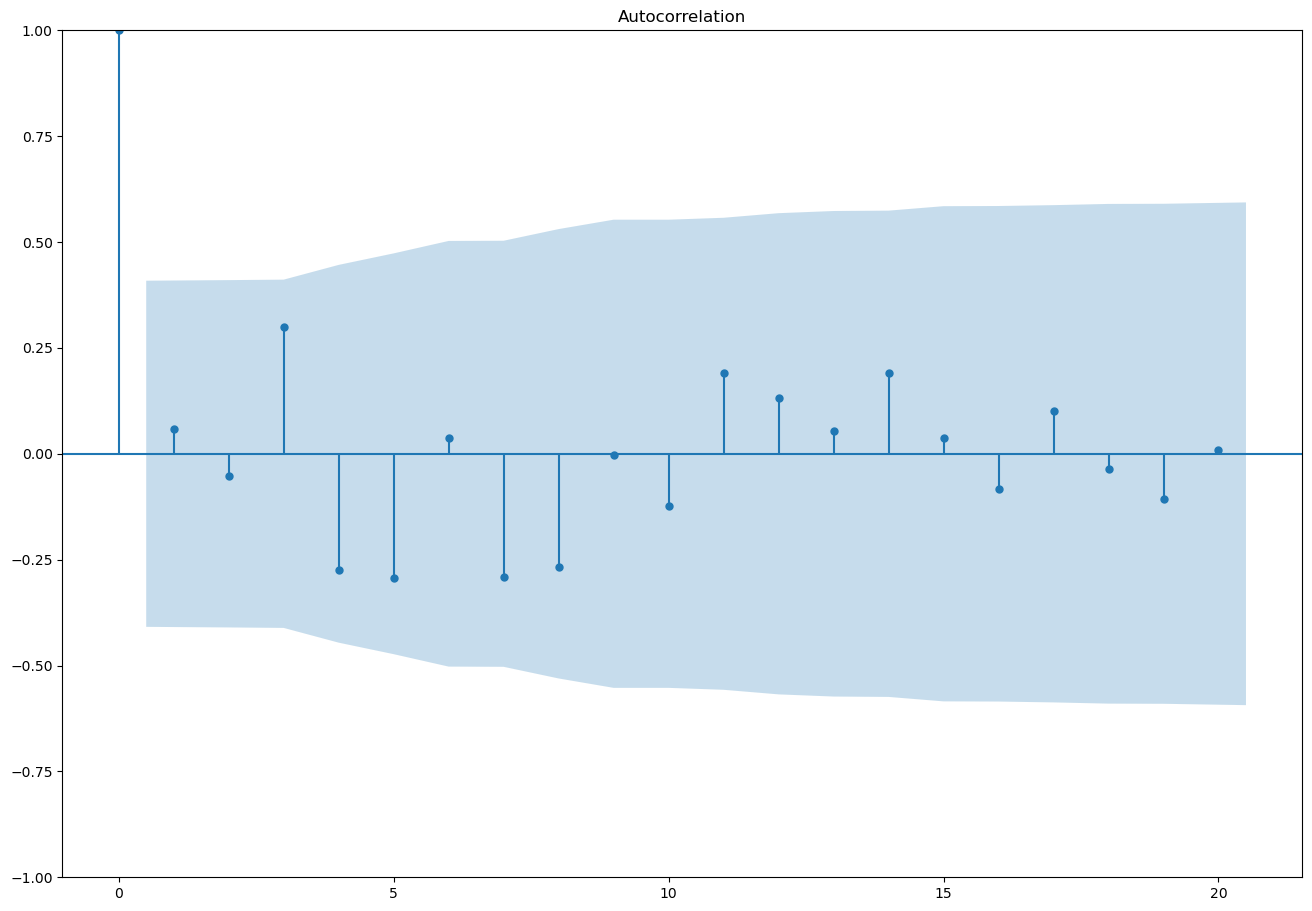

In [1224]:
residuals = ser_EMEA_p_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

### 3. Super Premium

In [1225]:
df_EMEA_sp = dfs['df_EMEA_Super Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3851751727.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3851751727.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


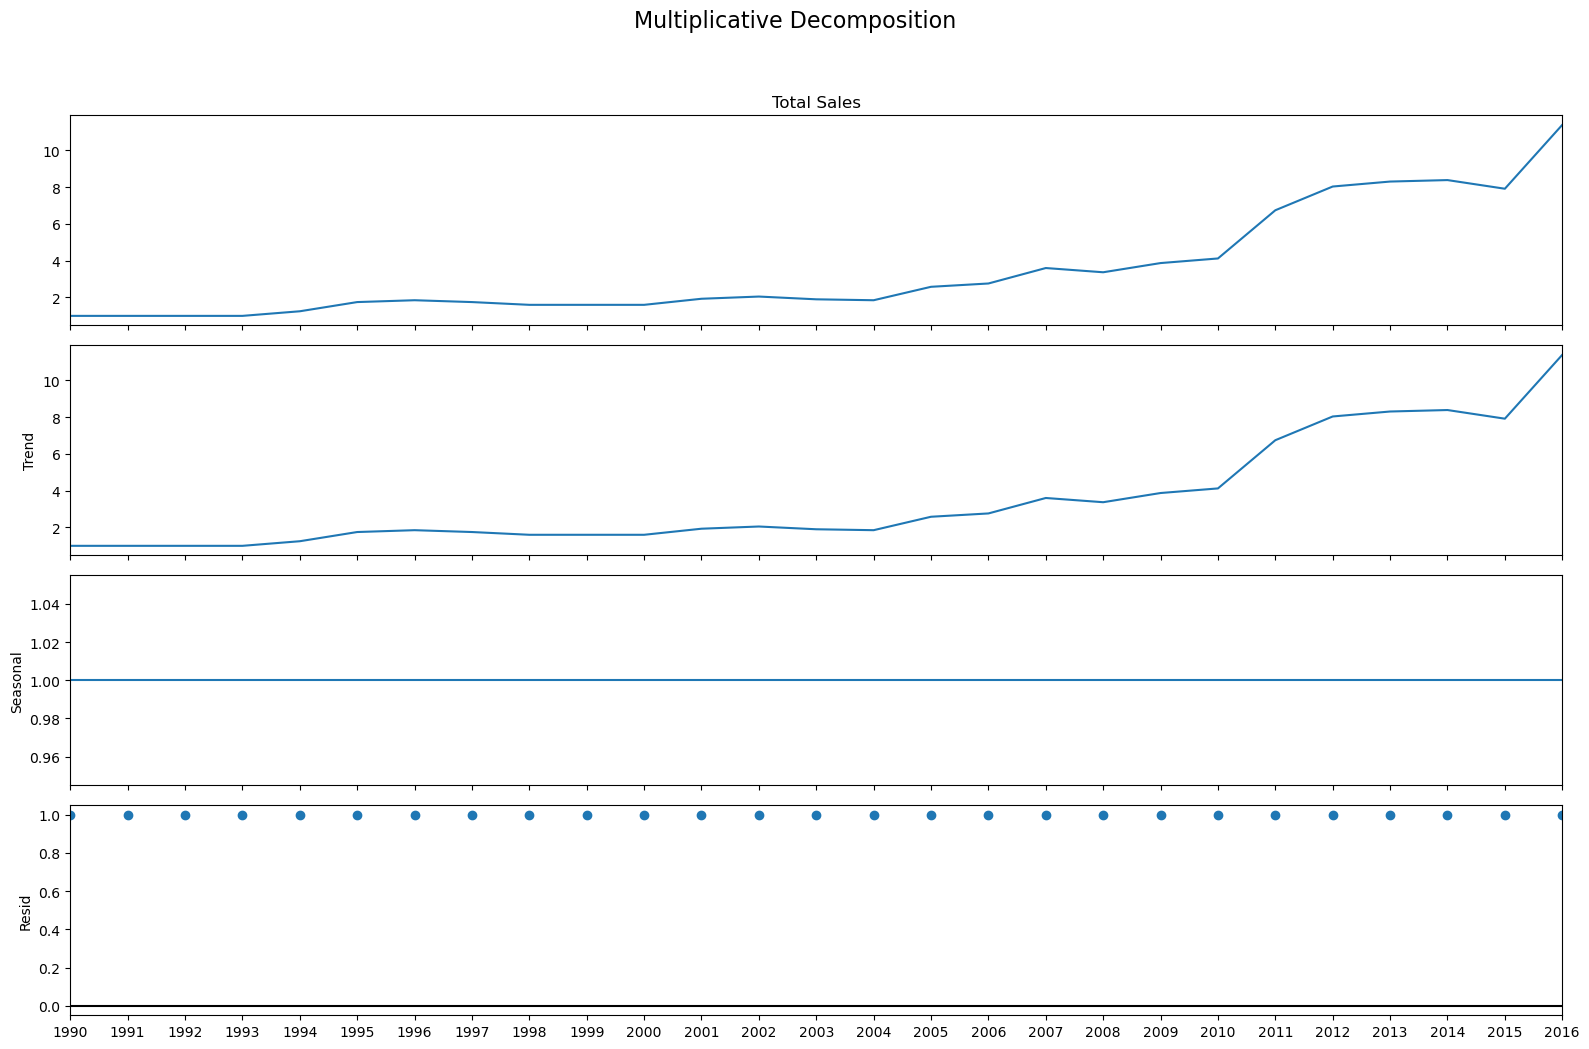

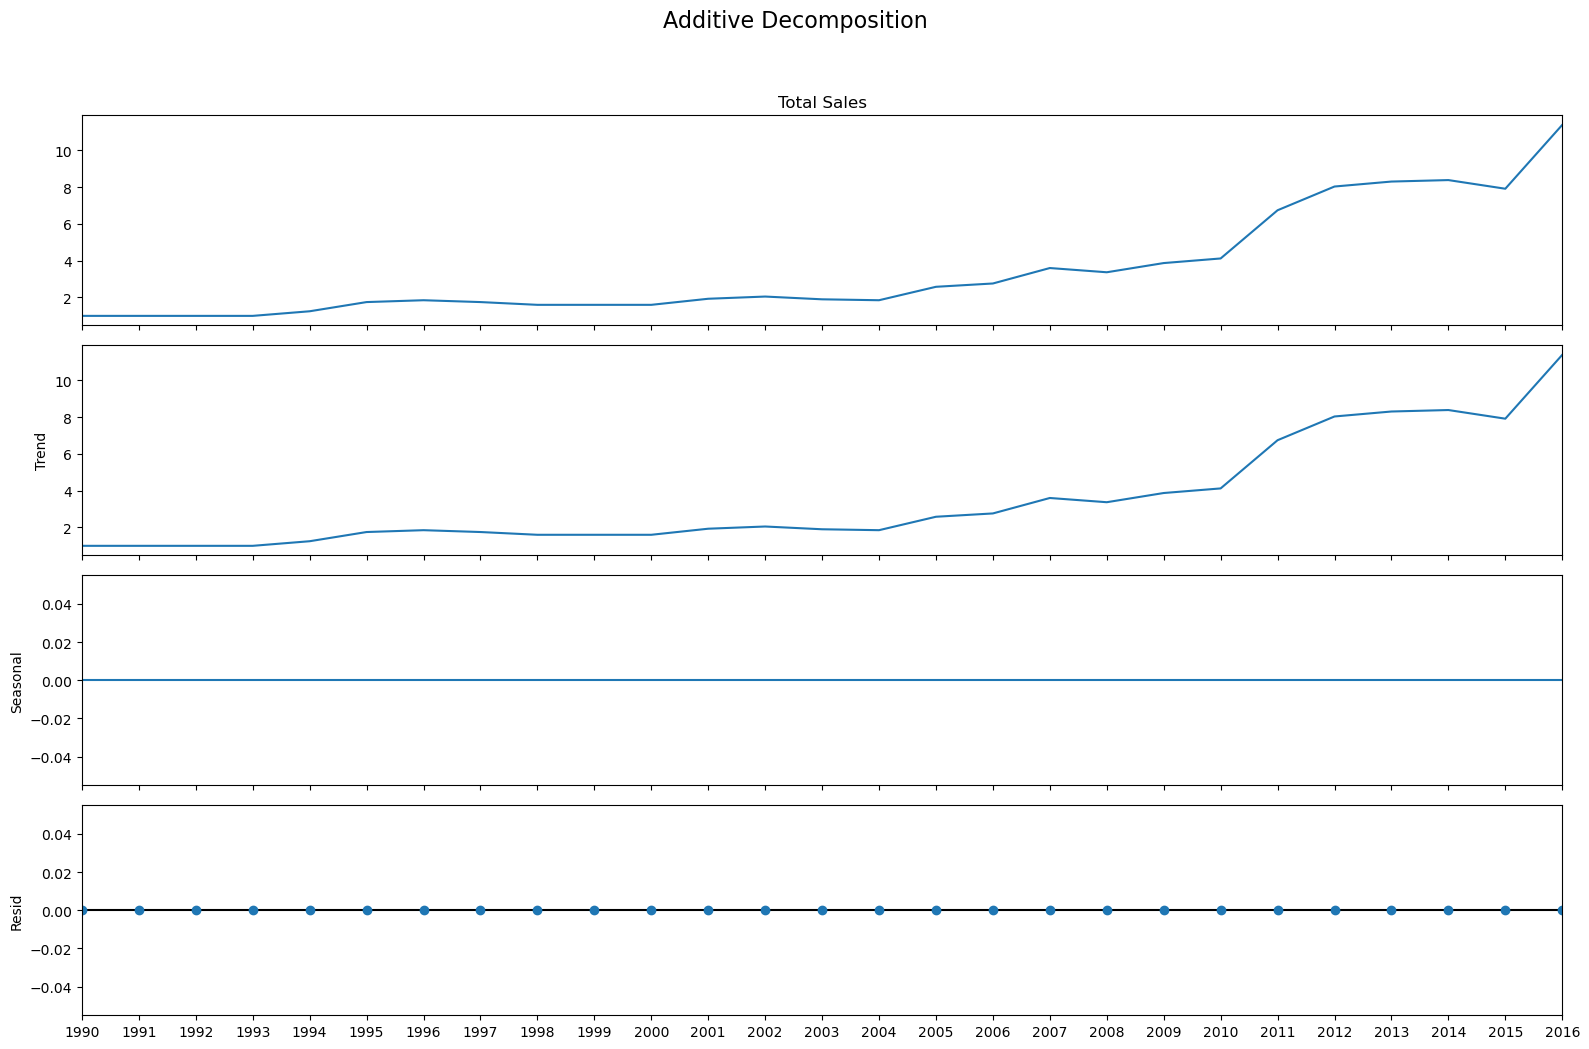

In [1226]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_EMEA_sp.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_EMEA_sp.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1227]:
k = np.floor(df_EMEA_sp.shape[0]*.9).astype('int')
df_EMEA_sp_train = df_EMEA_sp.iloc[0:k,:]
df_EMEA_sp_test = df_EMEA_sp.iloc[k:, :]

In [1228]:
ser_EMEA_sp_train = pd.Series(df_EMEA_sp_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_EMEA_sp_train), freq = "A"))
ser_EMEA_sp_test = pd.Series(df_EMEA_sp_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_EMEA_sp_test), freq = "A"))

In [1229]:
EMEA_SP = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1230]:
# ETS
mod_EMEA_sp_ets = ETSModel(ser_EMEA_sp_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_EMEA_sp_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -11.193
Date:                Sat, 20 Apr 2024   AIC                             34.386
Time:                        23:58:30   BIC                             41.454
Sample:                    12-31-1990   HQIC                            36.261
                         - 12-31-2013   Scale                            0.032
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.258      3.877      0.000       0.494       1.505
smoothing_trend     0.1811      0.130      1.391      0.164      -0.074       0.436
damping_trend       0.9800      

In [1231]:
get_metrics(ser_EMEA_sp_train, ser_EMEA_sp_test, mod_EMEA_sp_ets, 'ETS', EMEA_SP)

model  train_rmse  test_rmse       2017       2018
0   ETS    0.584312   1.225188  10.822956  11.422466

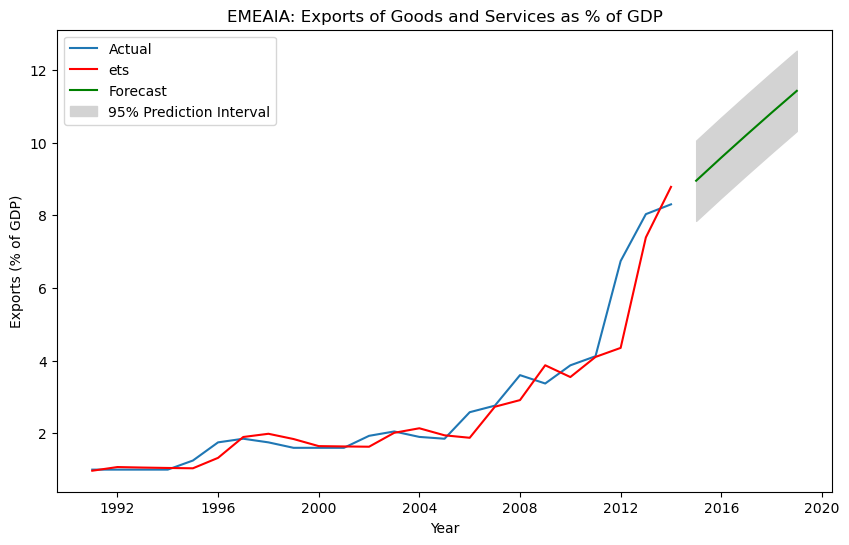

In [1232]:
plot_forecast(ser_EMEA_sp_train, mod_EMEA_sp_ets, 'ets', len(ser_EMEA_sp_test)+2)

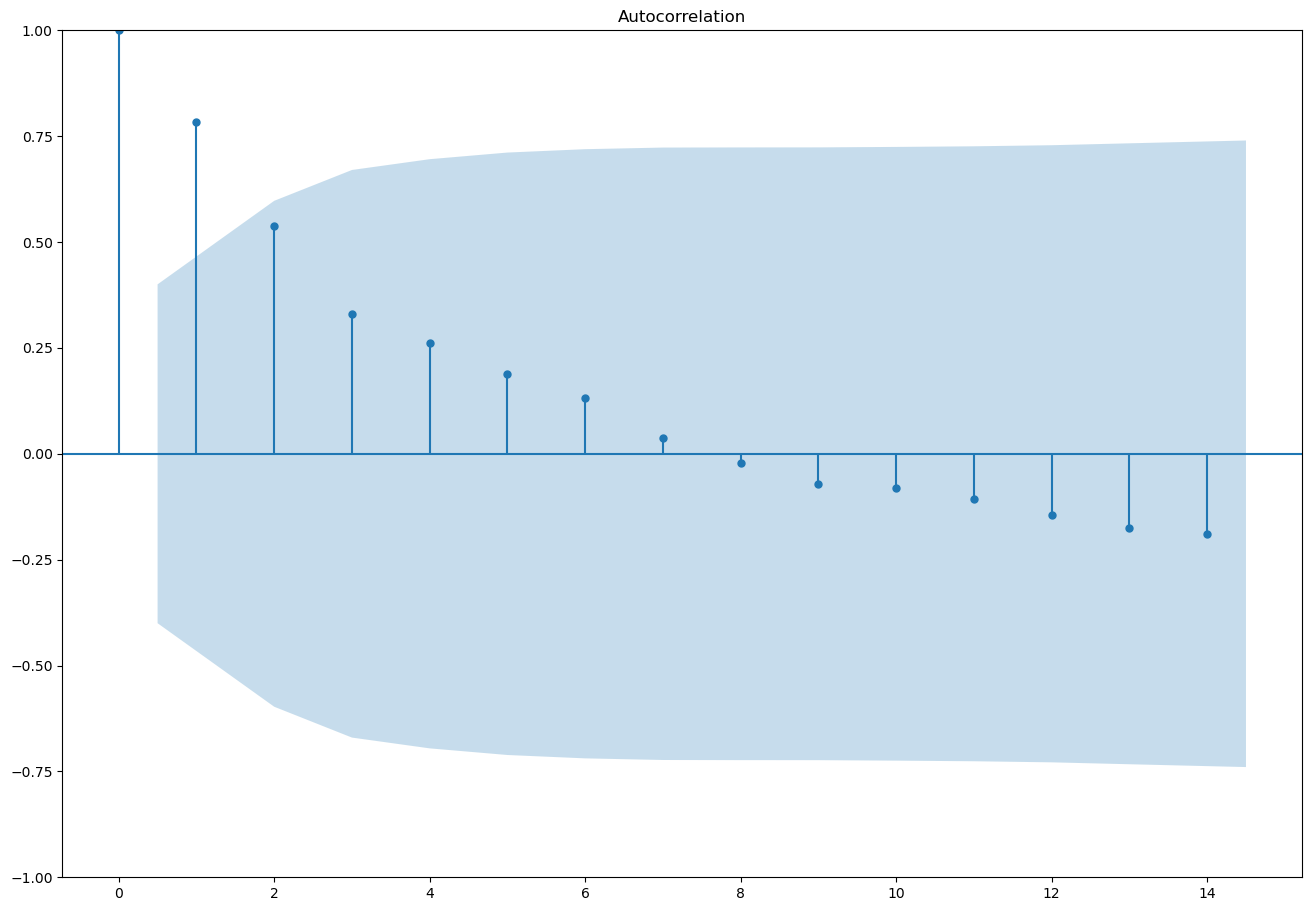

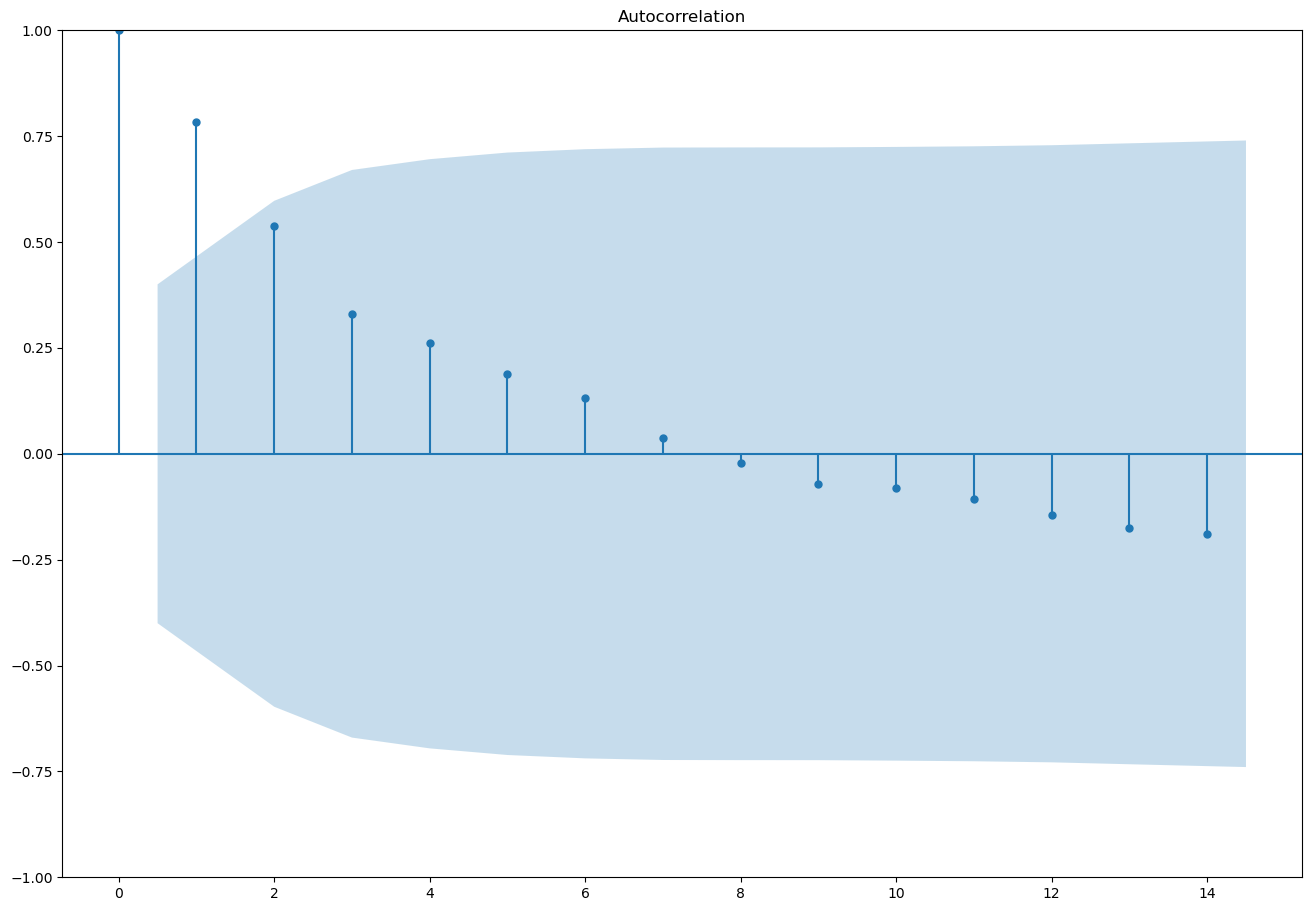

In [1233]:
plot_acf(ser_EMEA_sp_train)

In [1234]:
p = 10
mod_EMEA_sp_ar = sm.tsa.ARIMA(ser_EMEA_sp_train, order = (p, 0, 0)).fit()
print(mod_EMEA_sp_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 -18.289
Date:                Sat, 20 Apr 2024   AIC                             60.578
Time:                        23:58:31   BIC                             74.714
Sample:                    12-31-1990   HQIC                            64.328
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9278      2.987      1.315      0.189      -1.926       9.782
ar.L1          1.6066      0.459      3.504      0.000       0.708       2.505
ar.L2         -0.7368      0.769     -0.958      0.3

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


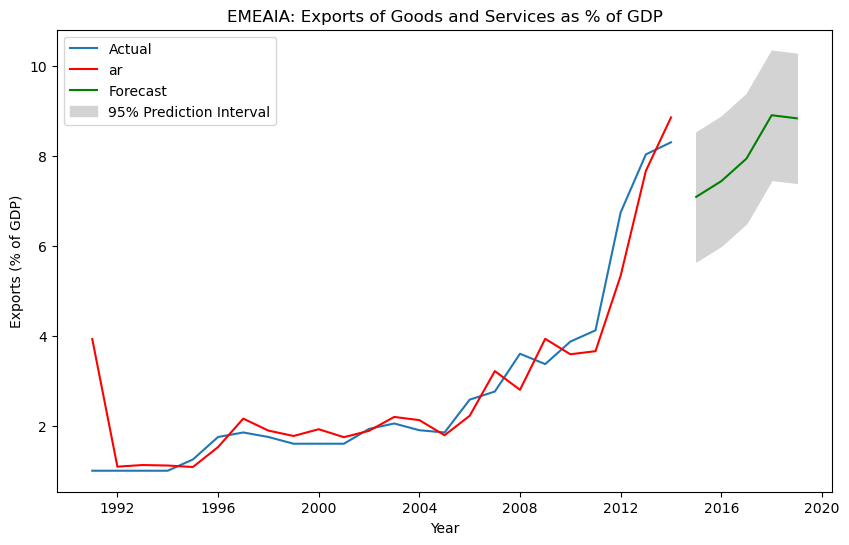

In [1235]:
plot_forecast(ser_EMEA_sp_train, mod_EMEA_sp_ar, 'ar', len(ser_EMEA_sp_test)+2)

In [1236]:
get_metrics(ser_EMEA_sp_train, ser_EMEA_sp_test, mod_EMEA_sp_ar, 'AR', EMEA_SP)

model  train_rmse  test_rmse       2017       2018
0   ETS    0.584312   1.225188  10.822956  11.422466
1    AR    0.737018   2.140511   8.900997   8.832572

In [1237]:
q = 5
mod_EMEA_sp_ma = sm.tsa.ARIMA(ser_EMEA_sp_train, order = (0, 0, q)).fit()
print(mod_EMEA_sp_ma.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -20.045
Date:                Sat, 20 Apr 2024   AIC                             54.089
Time:                        23:58:32   BIC                             62.336
Sample:                    12-31-1990   HQIC                            56.277
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7631      1.290      2.142      0.032       0.235       5.291
ma.L1          1.8503   1139.822      0.002      0.999   -2232.159    2235.860
ma.L2          2.6446   2095.738      0.001      0.9

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1238]:
get_metrics(ser_EMEA_sp_train, ser_EMEA_sp_test, mod_EMEA_sp_ma, 'MA', EMEA_SP)

model  train_rmse  test_rmse       2017       2018
0   ETS    0.584312   1.225188  10.822956  11.422466
1    AR    0.737018   2.140511   8.900997   8.832572
2    MA    0.601896   5.699975   2.240598   2.645886

In [1239]:
kpss_level(ser_EMEA_sp_train, 10)

0.38491872546823125

In [1240]:
kpss_trend(ser_EMEA_sp_train, 10)

0.1606617209603688

In [1241]:
ser_EMEA_sp_train = ser_EMEA_sp_train.diff().dropna()

In [1242]:
mod_EMEA_sp_auto_arima = pm.auto_arima(ser_EMEA_sp_train, stepwise=False, seasonal=True)
mod_EMEA_sp_auto_arima

ARIMA(order=(4, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1243]:
mod_EMEA_sp_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(4, 0, 0)   Log Likelihood                 -16.678
Date:                Sat, 20 Apr 2024   AIC                             45.356
Time:                        23:58:35   BIC                             52.169
Sample:                    12-31-1991   HQIC                            47.069
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1699      0.222      0.767      0.443      -0.264       0.604
ar.L1          0.4828      0.296      1.631      0.103      -0.097       1.063
ar.L2         -0.0437      0.191     -0.229      0.819      -0.419       0.331
ar.L3         -0.5964      0.606     -0.984      0.325      -1.784       0.592
ar.L4          0.5875      0.393      1.496      0.135      -0.182       1.357
sigma2         0.2222      0.091      2.439      0.015       0.044       0.401
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                40.17
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              14.77   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1244]:
get_metrics(ser_EMEA_sp_train, ser_EMEA_sp_test, mod_EMEA_sp_auto_arima, 'ARIMA', EMEA_SP)

model  train_rmse  test_rmse       2017       2018
0    ETS    0.584312   1.225188  10.822956  11.422466
1     AR    0.737018   2.140511   8.900997   8.832572
2     MA    0.601896   5.699975   2.240598   2.645886
3  ARIMA    0.477014   9.239287   1.490831  -0.058232

In [1245]:
fitted, conf = mod_LATAM_std_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

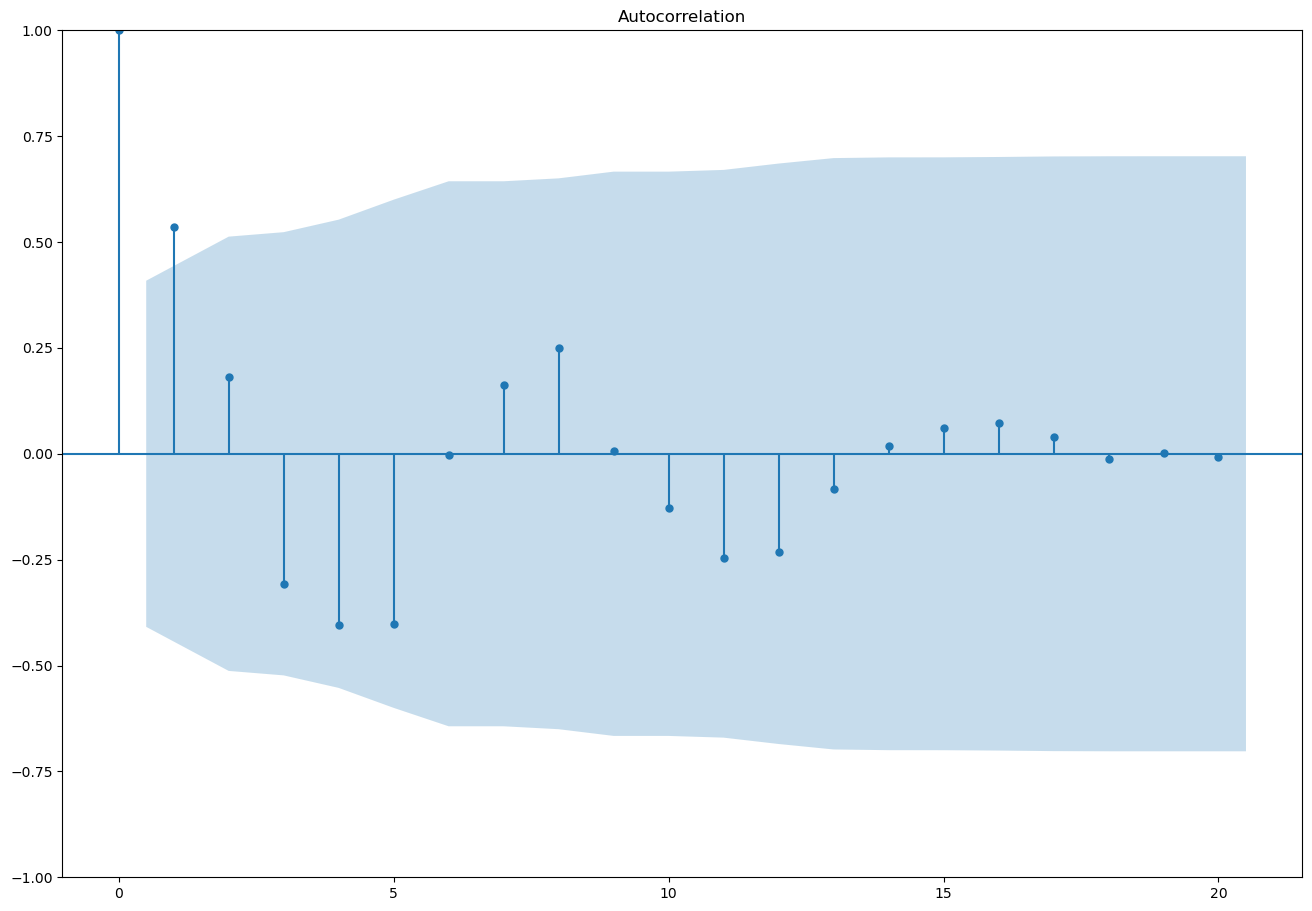

In [1246]:
residuals = ser_EMEA_sp_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

### LATAM

### *1. Standard*

In [1247]:
df_LATAM_std = dfs['df_LATAM_Standard']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\1675139174.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\1675139174.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


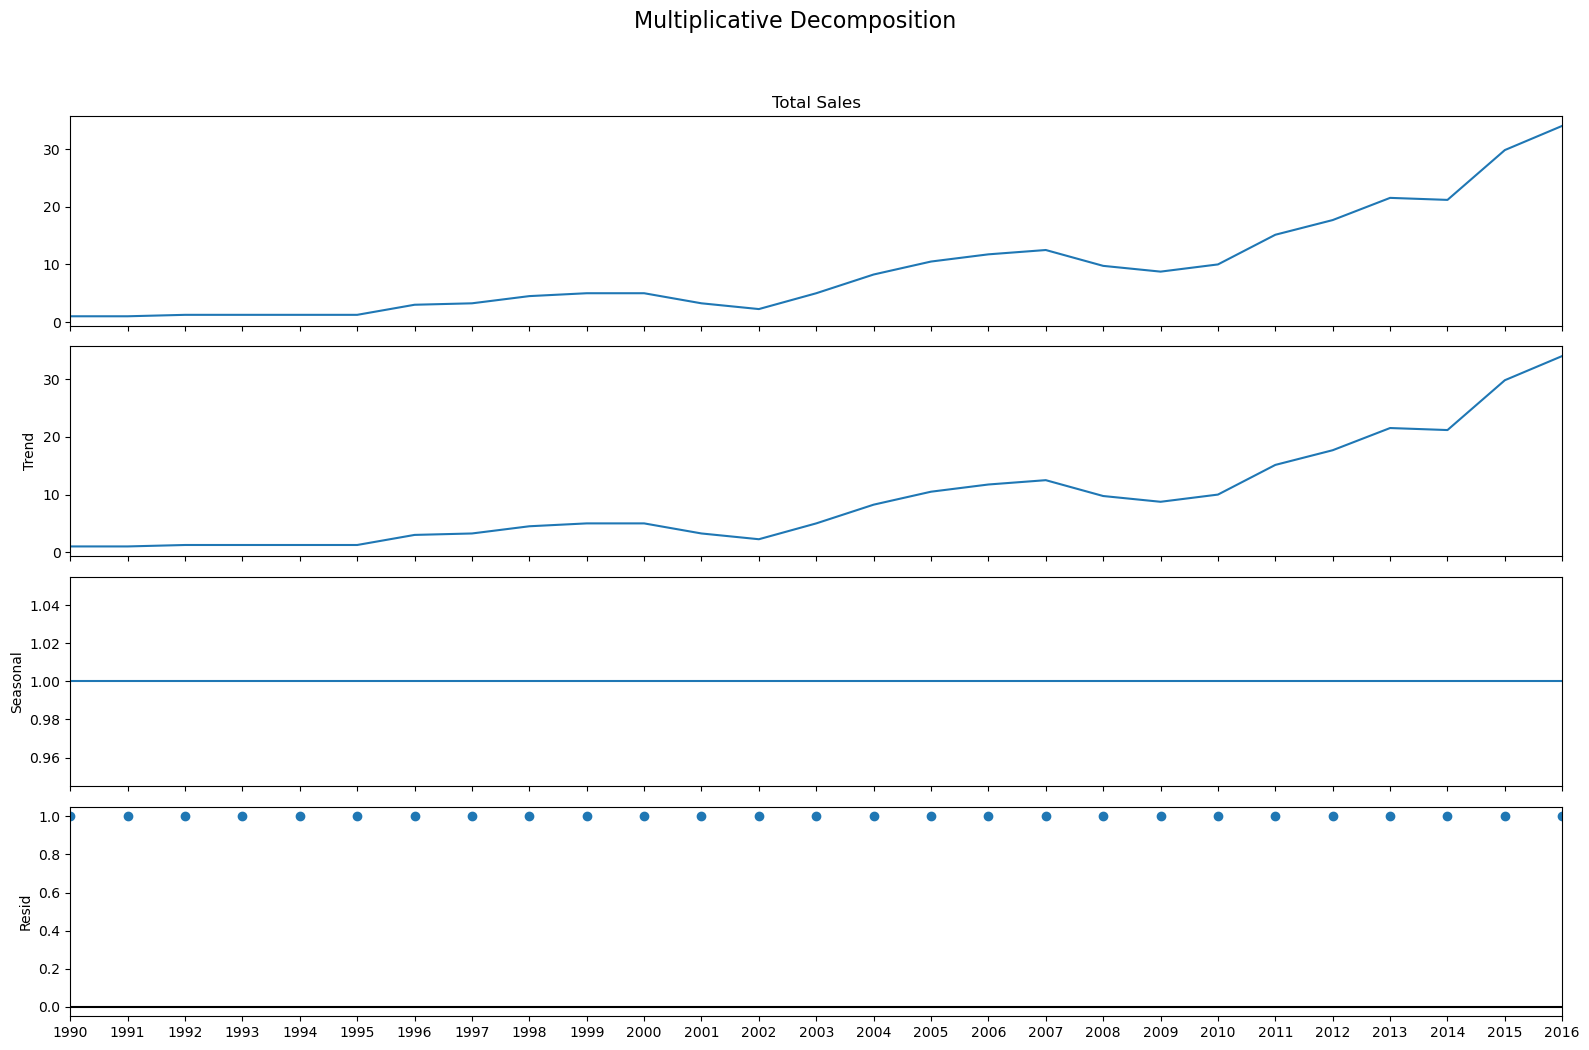

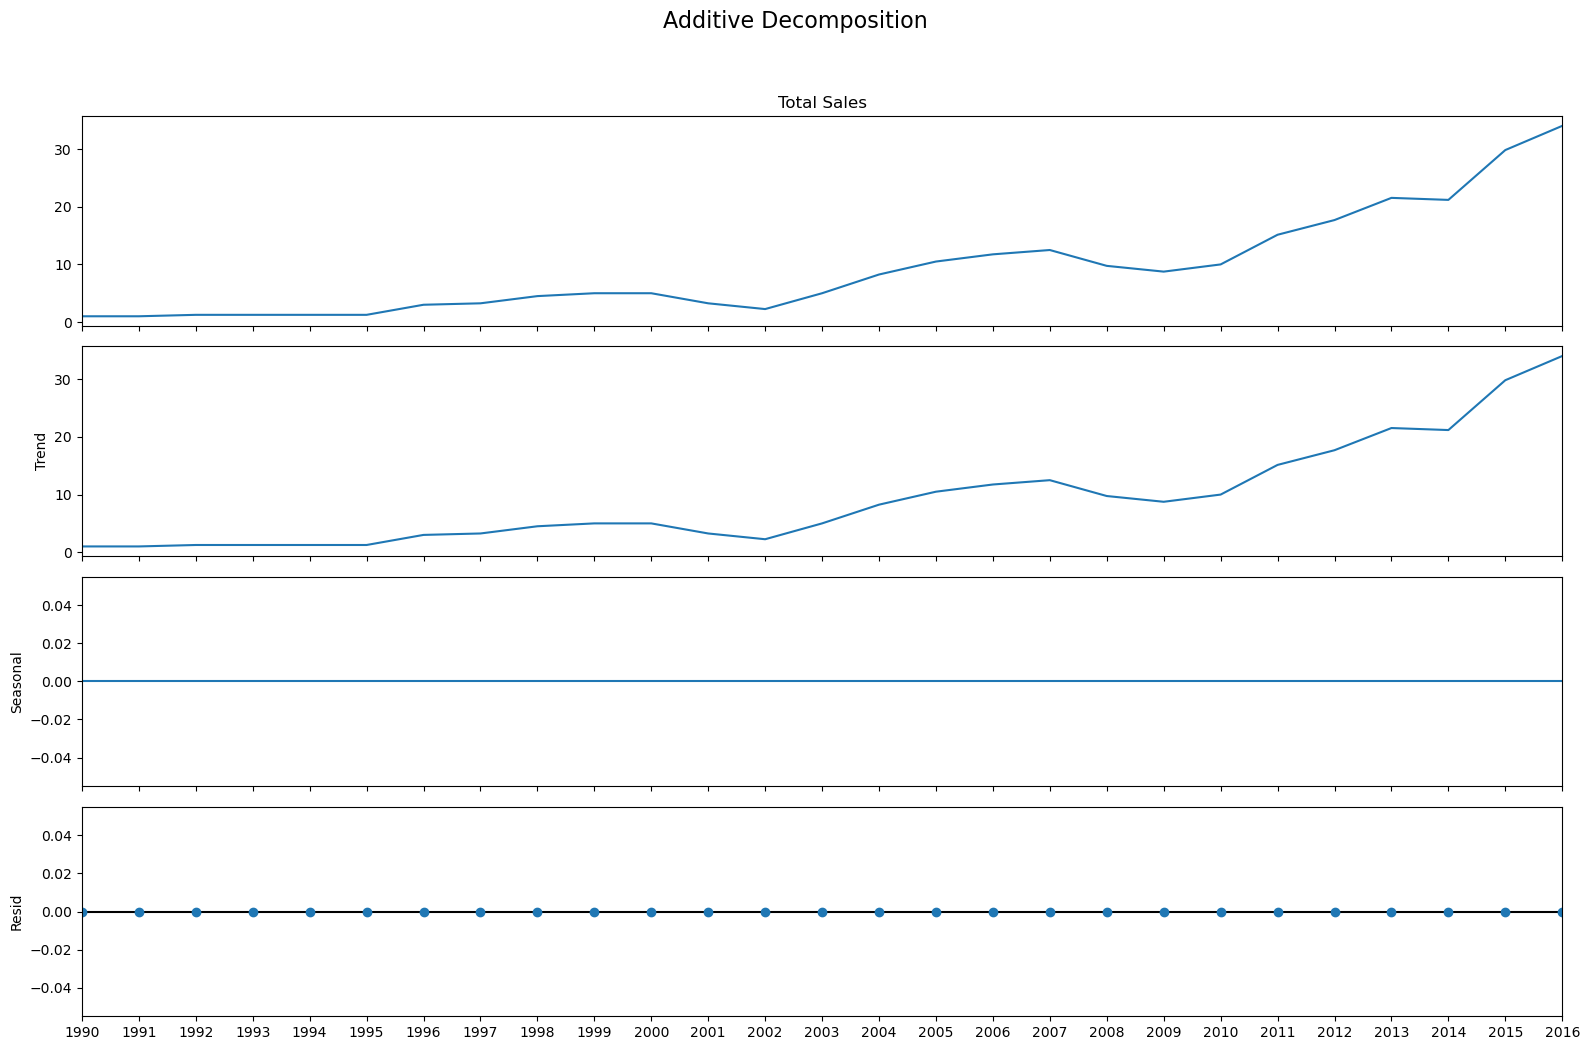

In [1248]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_LATAM_std.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_LATAM_std.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1249]:
k = np.floor(df_LATAM_std.shape[0]*.9).astype('int')
df_LATAM_std_train = df_LATAM_std.iloc[0:k,:]
df_LATAM_std_test = df_LATAM_std.iloc[k:, :]

In [1250]:
ser_LATAM_std_train = pd.Series(df_LATAM_std_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_LATAM_std_train), freq = "A"))
ser_LATAM_std_test = pd.Series(df_LATAM_std_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_LATAM_std_test), freq = "A"))

In [1251]:
LATAM_STD = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1252]:
# ETS
mod_LATAM_std_ets = ETSModel(ser_LATAM_std_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_LATAM_std_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -44.468
Date:                Sat, 20 Apr 2024   AIC                            100.937
Time:                        23:58:38   BIC                            108.005
Sample:                    12-31-1990   HQIC                           102.812
                         - 12-31-2013   Scale                            0.116
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.7685      0.346      2.221      0.026       0.090       1.447
smoothing_trend  7.685e-05      0.085      0.001      0.999      -0.166       0.166
damping_trend       0.9800      

In [1253]:
get_metrics(ser_LATAM_std_train, ser_LATAM_std_test, mod_LATAM_std_ets, 'ETS', LATAM_STD)

model  train_rmse  test_rmse       2017      2018
0   ETS    2.089847   8.890629  21.647239  21.90958

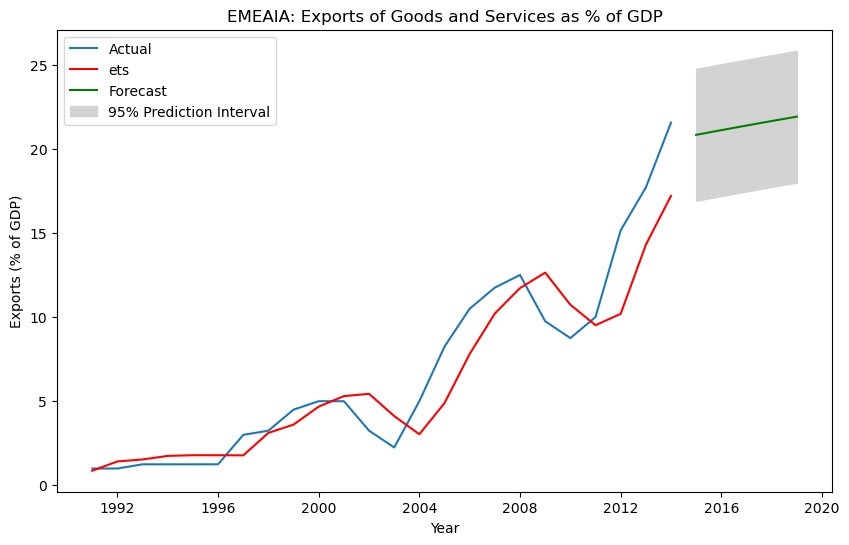

In [1254]:
plot_forecast(ser_LATAM_std_train, mod_LATAM_std_ets, 'ets', len(ser_LATAM_std_test)+2)

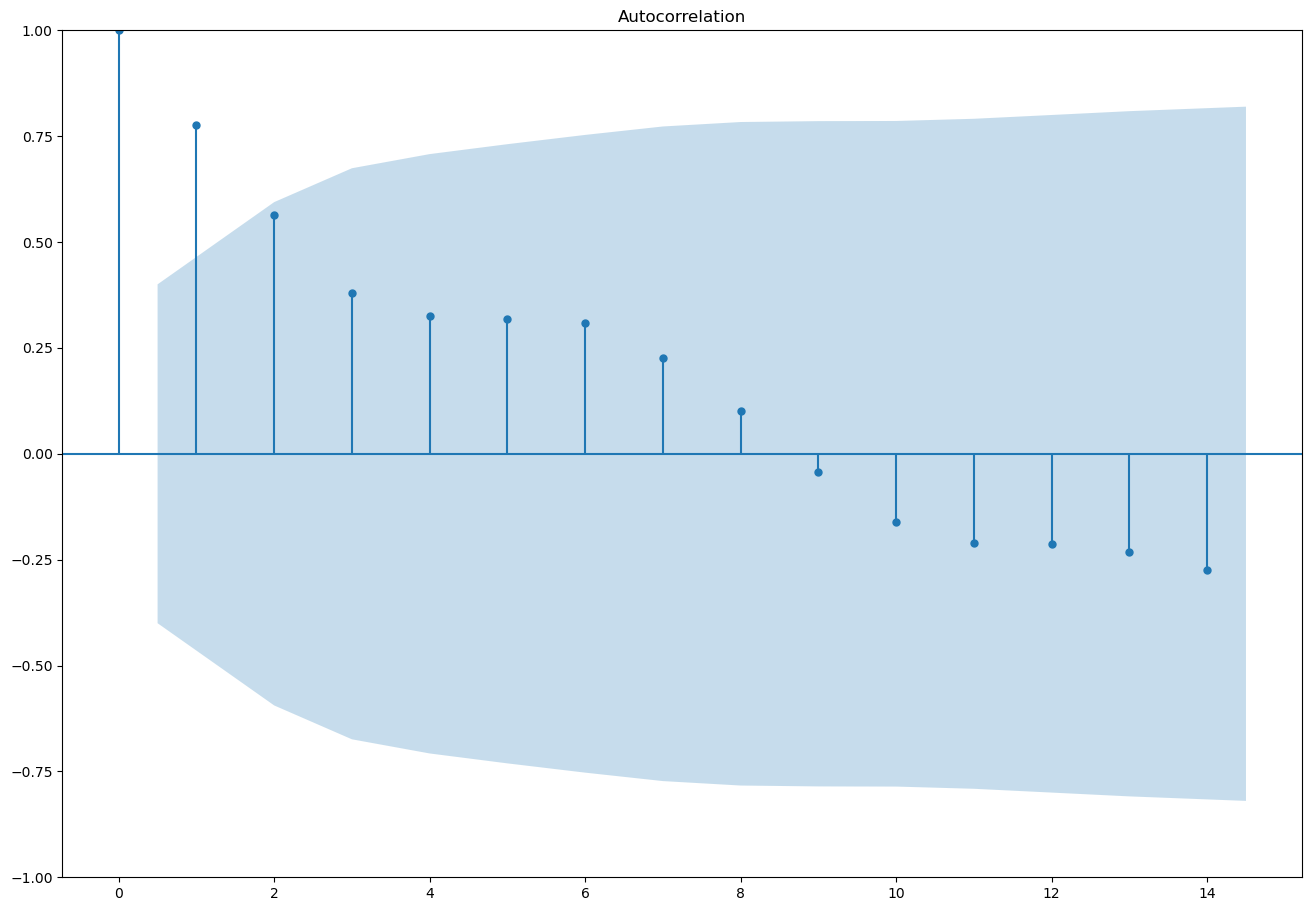

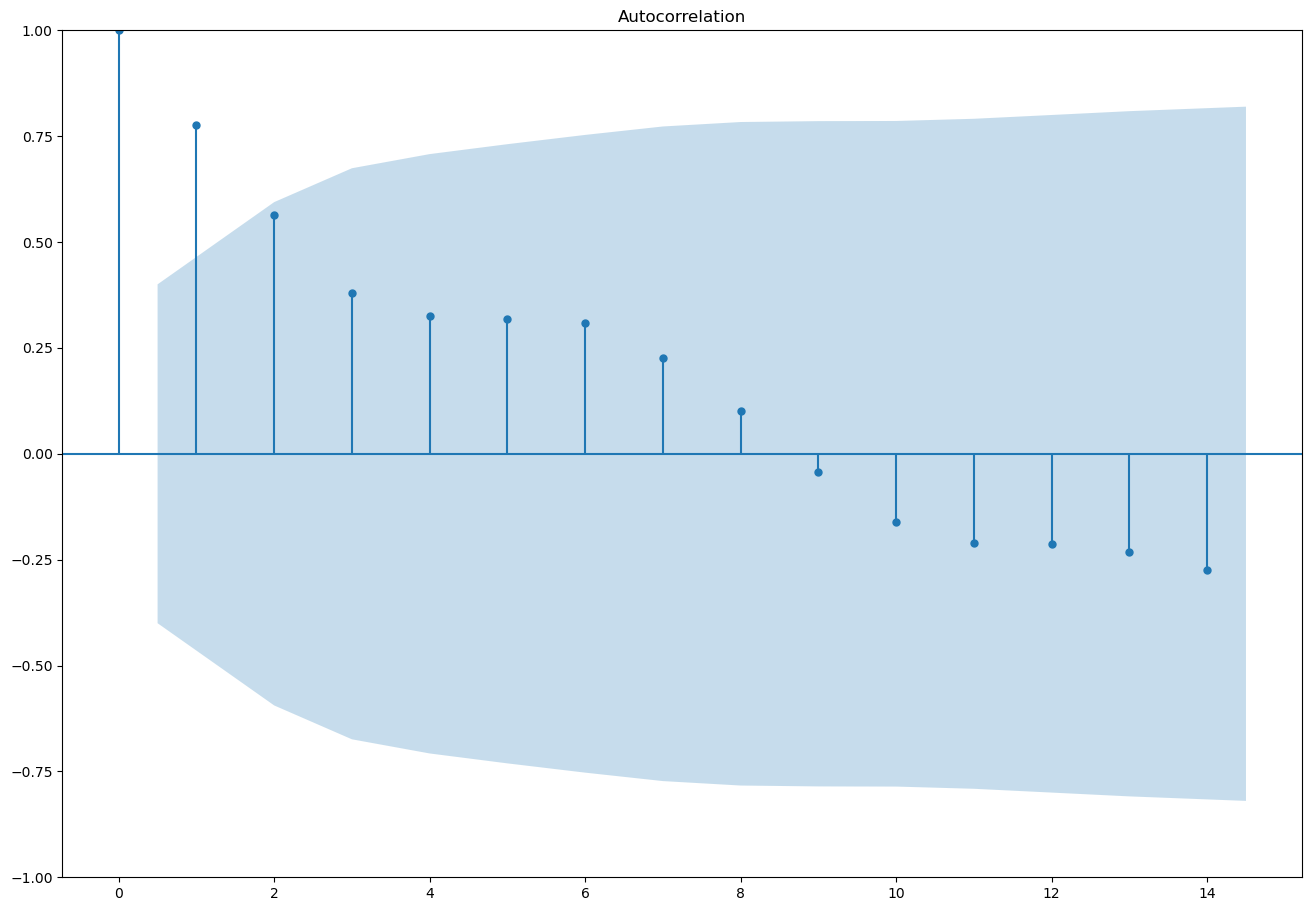

In [1255]:
plot_acf(ser_LATAM_std_train)

In [1256]:
p = 10
mod_LATAM_std_ar = sm.tsa.ARIMA(ser_LATAM_std_train, order = (p, 0, 0)).fit()
print(mod_LATAM_std_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 -37.880
Date:                Sat, 20 Apr 2024   AIC                             99.761
Time:                        23:58:40   BIC                            113.897
Sample:                    12-31-1990   HQIC                           103.511
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0117     11.102      1.172      0.241      -8.748      34.772
ar.L1          1.4371      0.435      3.305      0.001       0.585       2.289
ar.L2         -0.3932      0.647     -0.608      0.5

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


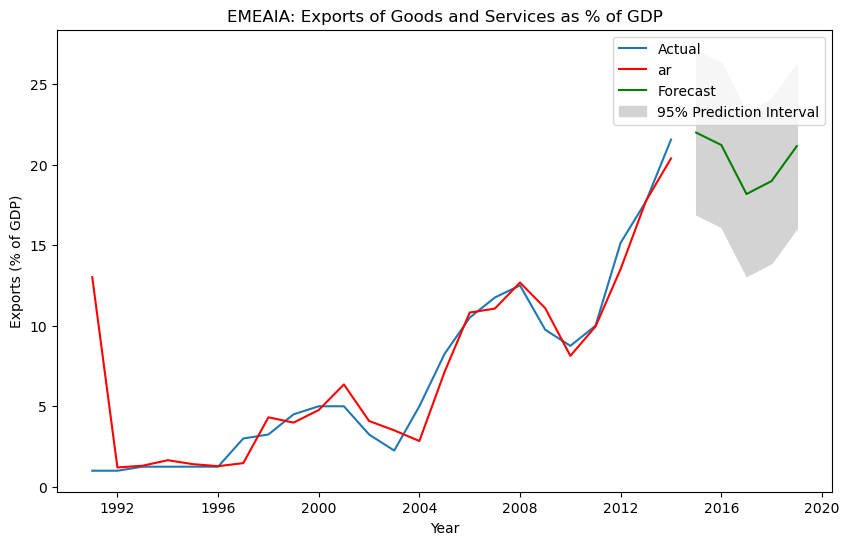

In [1257]:
plot_forecast(ser_LATAM_std_train, mod_LATAM_std_ar, 'ar', len(ser_LATAM_std_test)+2)

In [1258]:
get_metrics(ser_LATAM_std_train, ser_LATAM_std_test, mod_LATAM_std_ar, 'AR', LATAM_STD)

model  train_rmse  test_rmse       2017       2018
0   ETS    2.089847   8.890629  21.647239  21.909580
1    AR    2.623075  10.444943  18.982109  21.147439

In [1259]:
q = 5
mod_LATAM_std_ma = sm.tsa.ARIMA(ser_LATAM_std_train, order = (0, 0, q)).fit()
print(mod_LATAM_std_ma.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -44.474
Date:                Sat, 20 Apr 2024   AIC                            102.948
Time:                        23:58:41   BIC                            111.194
Sample:                    12-31-1990   HQIC                           105.136
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8128      2.384      3.277      0.001       3.140      12.486
ma.L1          1.6212     85.679      0.019      0.985    -166.306     169.548
ma.L2          2.1340    162.376      0.013      0.9

In [1260]:
get_metrics(ser_LATAM_std_train, ser_LATAM_std_test, mod_LATAM_std_ma, 'MA', LATAM_STD)

model  train_rmse  test_rmse       2017       2018
0   ETS    2.089847   8.890629  21.647239  21.909580
1    AR    2.623075  10.444943  18.982109  21.147439
2    MA    1.939999  12.521713  11.585347   9.285105

In [1261]:
kpss_level(ser_LATAM_std_train, 10)

0.38529552675471734

In [1262]:
kpss_trend(ser_LATAM_std_train, 10)

0.15978368954328842

In [1263]:
ser_LATAM_std_train = ser_LATAM_std_train.diff().dropna()

In [1264]:
mod_LATAM_std_auto_arima = pm.auto_arima(ser_LATAM_std_train, stepwise=False, seasoLATAMl=True)
mod_LATAM_std_auto_arima

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1265]:
mod_LATAM_std_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(5, 0, 0)   Log Likelihood                 -36.774
Date:                Sat, 20 Apr 2024   AIC                             87.549
Time:                        23:58:44   BIC                             95.497
Sample:                    12-31-1991   HQIC                            89.548
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5603      0.345      4.525      0.000       0.885       2.236
ar.L1          0.2027      0.258      0.786      0.432      -0.303       0.708
ar.L2         -0.2007      0.295     -0.679      0.497      -0.780       0.378
ar.L3         -0.5599      0.265     -2.115      0.034      -1.079      -0.041
ar.L4          0.0029      0.309      0.009      0.993      -0.604       0.609
ar.L5         -0.5136      0.332     -1.548      0.122      -1.164       0.137
sigma2         1.2181      0.594      2.052      0.040       0.054       2.382
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.44   Prob(JB):                         0.71
Heteroskedasticity (H):               3.45   Skew:                             0.37
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1266]:
get_metrics(ser_LATAM_std_train, ser_LATAM_std_test, mod_LATAM_std_auto_arima, 'ARIMA', LATAM_STD)

model  train_rmse  test_rmse       2017       2018
0    ETS    2.089847   8.890629  21.647239  21.909580
1     AR    2.623075  10.444943  18.982109  21.147439
2     MA    1.939999  12.521713  11.585347   9.285105
3  ARIMA    1.125858  30.824237   0.149116   1.065581

In [1267]:
fitted, conf = mod_LATAM_std_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

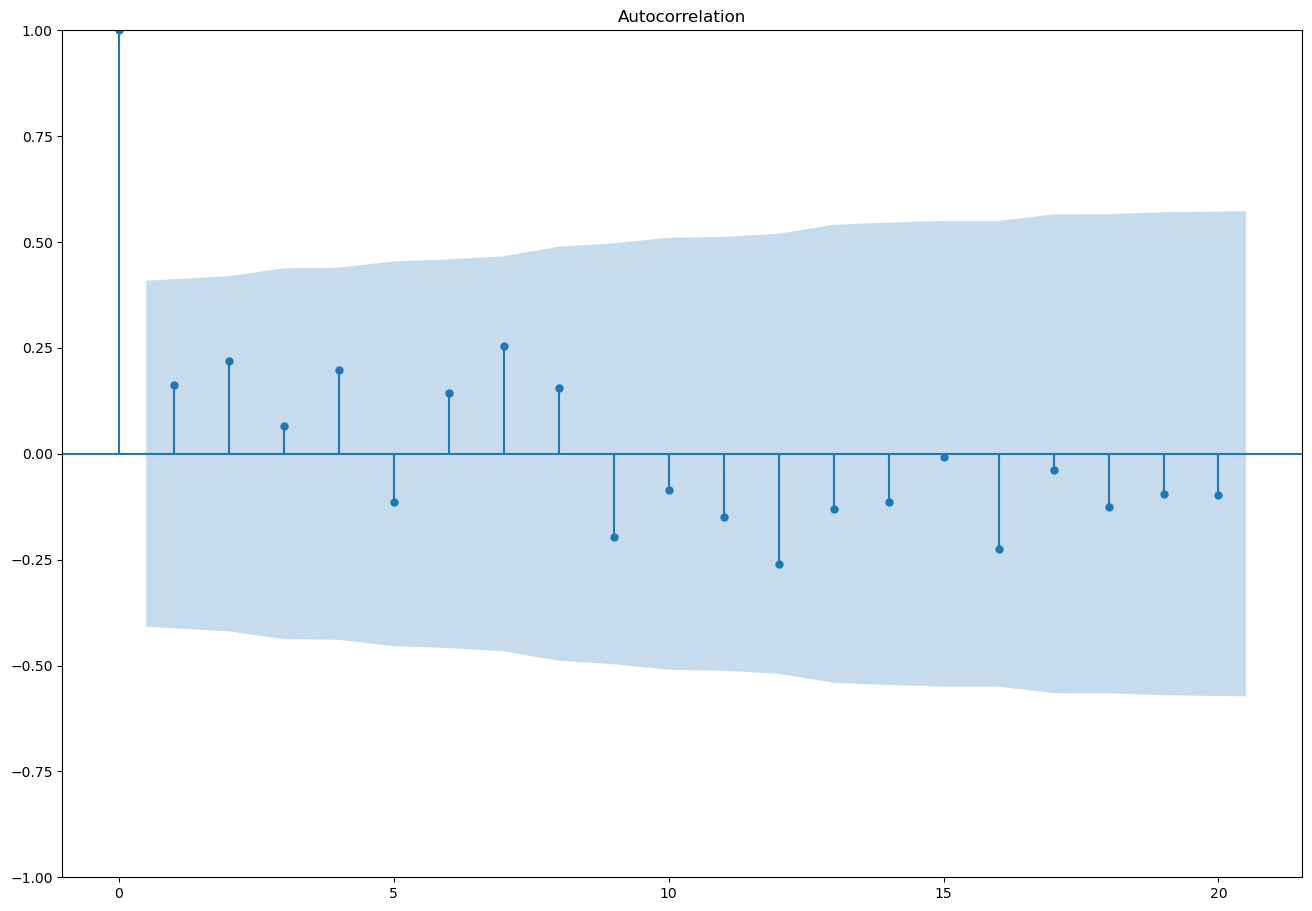

In [1268]:
residuals = ser_LATAM_std_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

# ---------------------------------------------------------------------------------

### *2. Premium*

In [1269]:
df_LATAM_p = dfs['df_LATAM_Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\823027589.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\823027589.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


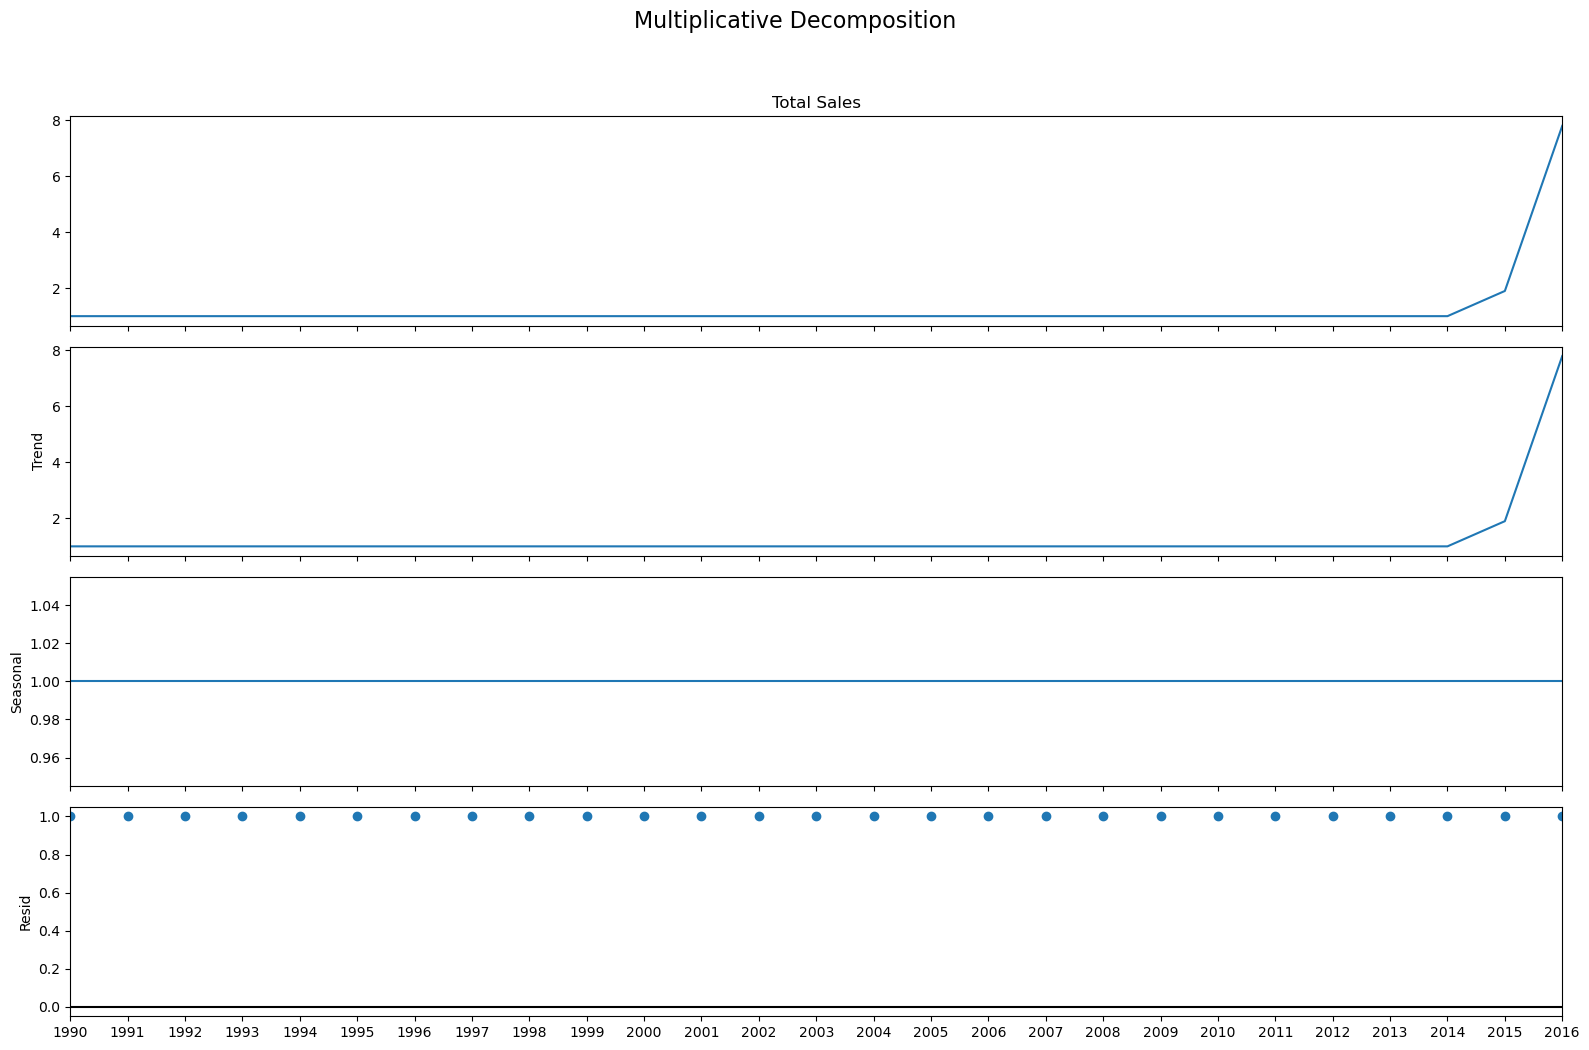

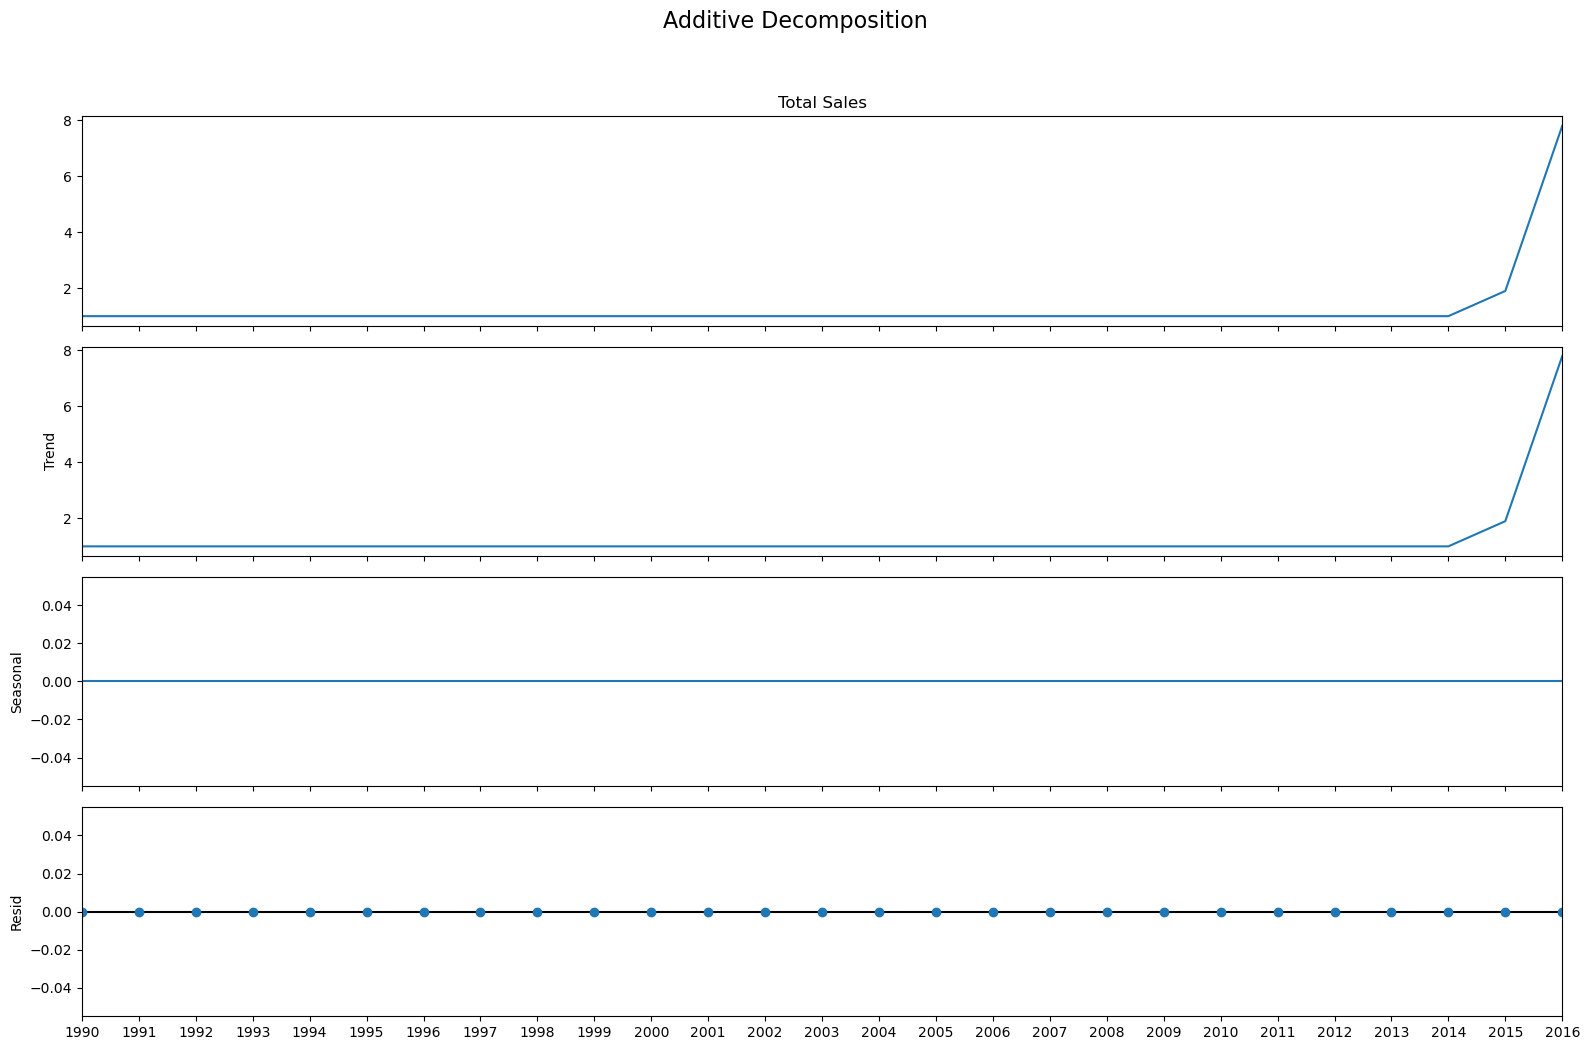

In [1270]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_LATAM_p.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_LATAM_p.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1271]:
k = np.floor(df_LATAM_p.shape[0]*.9).astype('int')
df_LATAM_p_train = df_LATAM_p.iloc[0:k,:]
df_LATAM_p_test = df_LATAM_p.iloc[k:, :]

In [1272]:
ser_LATAM_p_train = pd.Series(df_LATAM_p_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_LATAM_p_train), freq = "A"))
ser_LATAM_p_test = pd.Series(df_LATAM_p_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_LATAM_p_test), freq = "A"))

In [1273]:
LATAM_P = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1274]:
# ETS
mod_LATAM_p_ets = ETSModel(ser_LATAM_p_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_LATAM_p_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 844.951
Date:                Sat, 20 Apr 2024   AIC                          -1677.902
Time:                        23:58:47   BIC                          -1670.834
Sample:                    12-31-1990   HQIC                         -1676.027
                         - 12-31-2013   Scale                            0.000
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.1000        nan        nan        nan         nan         nan
smoothing_trend     0.0100      0.064      0.156      0.876      -0.116       0.136
damping_trend       0.9800      

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1275]:
get_metrics(ser_LATAM_p_train, ser_LATAM_p_test, mod_LATAM_p_ets, 'ETS', LATAM_P)

model    train_rmse  test_rmse  2017  2018
0   ETS  1.241267e-16   3.960219   1.0   1.0

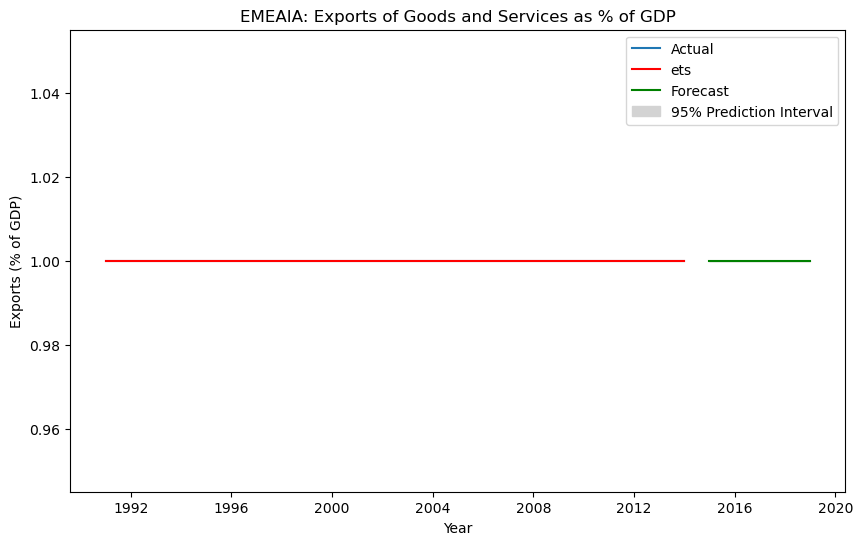

In [1276]:
plot_forecast(ser_LATAM_p_train, mod_LATAM_p_ets, 'ets', len(ser_LATAM_p_test)+2)

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\Anjali\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


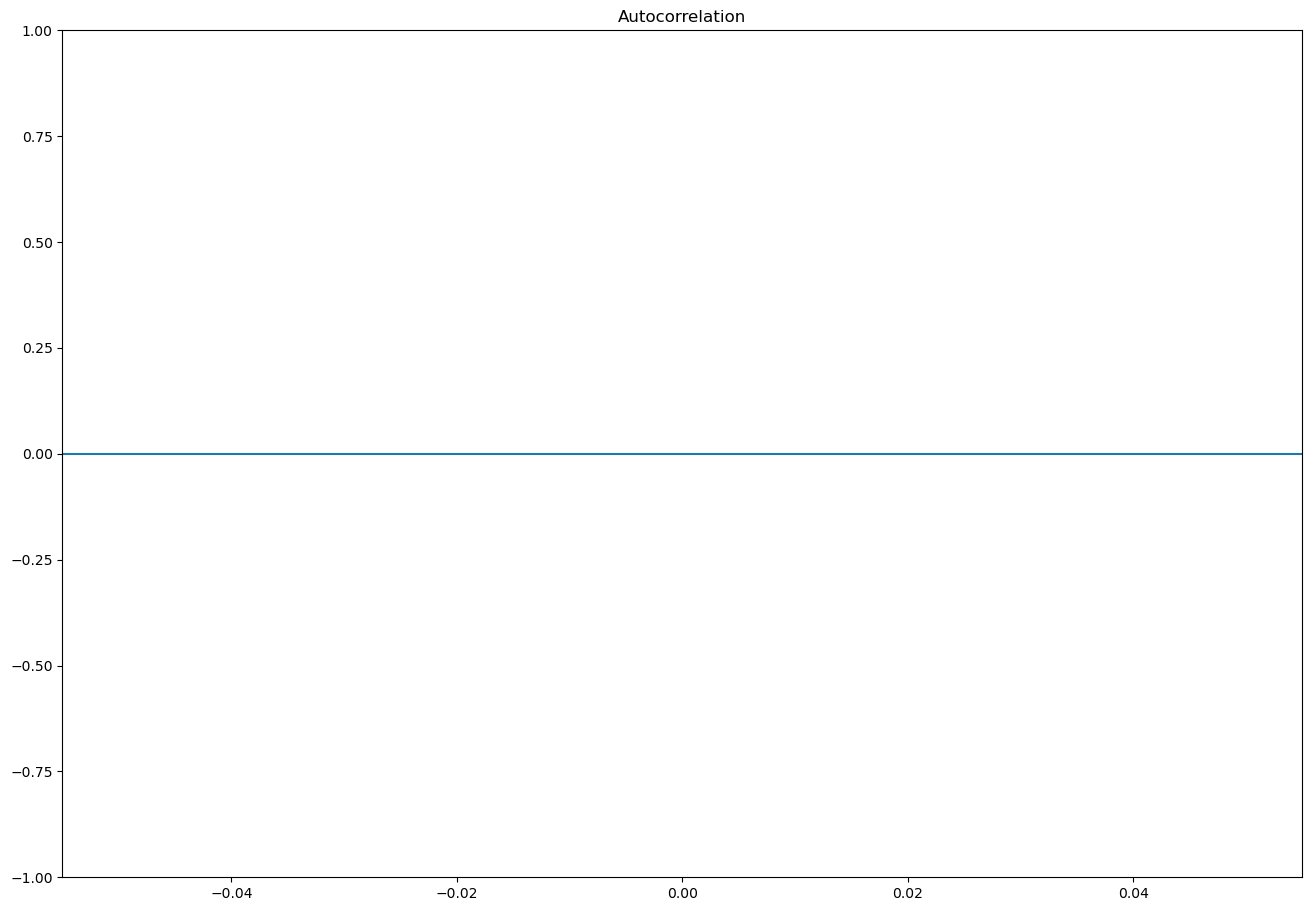

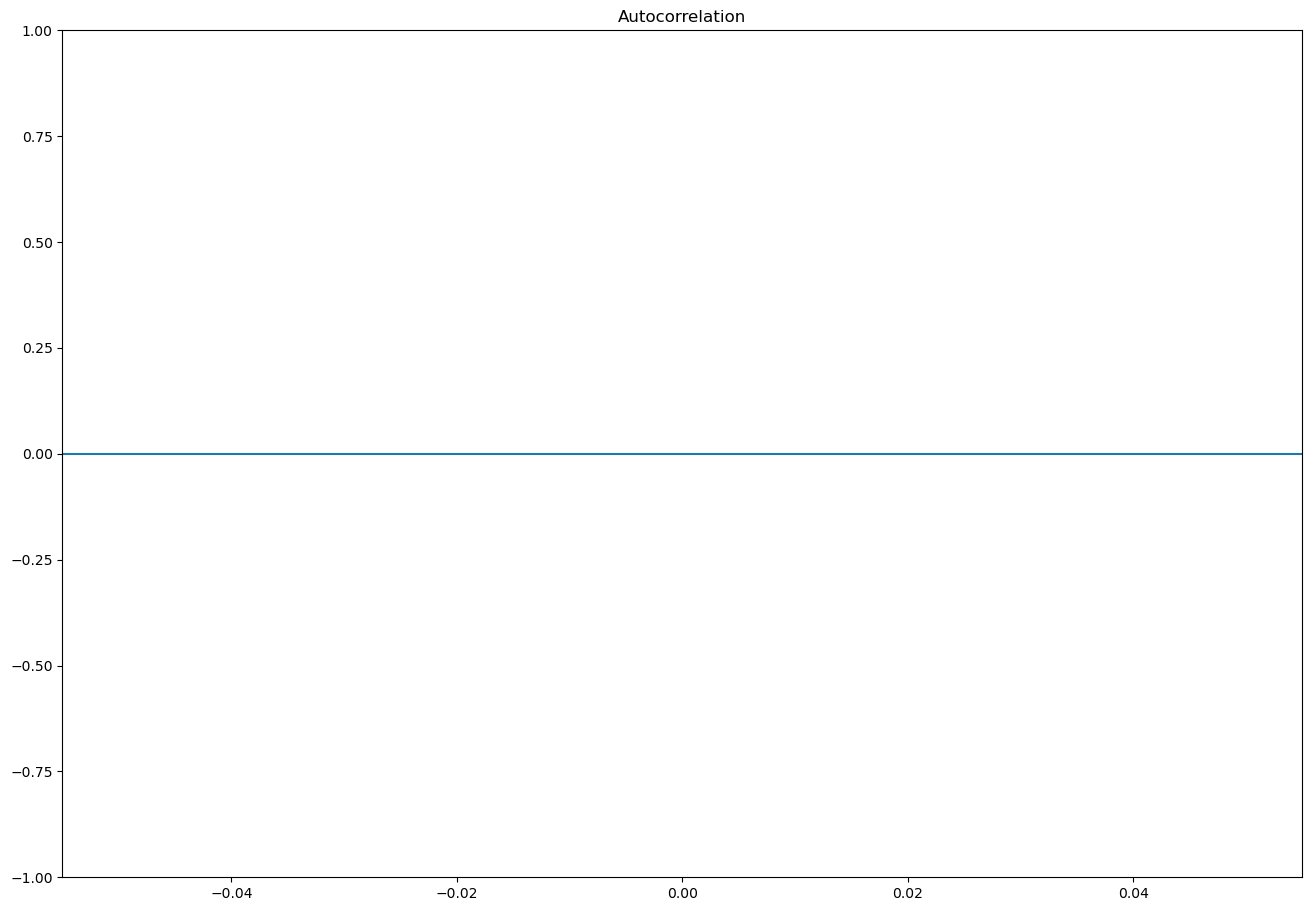

In [1277]:
plot_acf(ser_LATAM_p_train)

In [1278]:
p = 10
mod_LATAM_p_ar = sm.tsa.ARIMA(ser_LATAM_p_train, order = (p, 0, 0)).fit()
print(mod_LATAM_p_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 255.311
Date:                Sat, 20 Apr 2024   AIC                           -486.622
Time:                        23:58:48   BIC                           -472.485
Sample:                    12-31-1990   HQIC                          -482.872
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   3.33e-13      3e+12      0.000       1.000       1.000
ar.L1       2.011e-17   1.54e-18     13.063      0.000    1.71e-17    2.31e-17
ar.L2       4.019e-17   1.47e-18     27.302      0.0

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


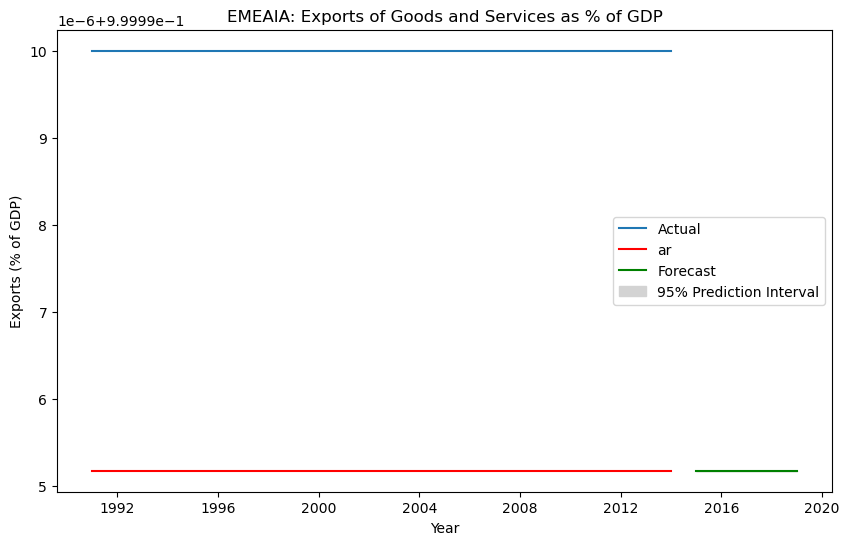

In [1279]:
plot_forecast(ser_LATAM_p_train, mod_LATAM_p_ar, 'ar', len(ser_LATAM_p_test)+2)

In [1280]:
get_metrics(ser_LATAM_p_train, ser_LATAM_p_test, mod_LATAM_p_ar, 'AR', LATAM_P)

model    train_rmse  test_rmse      2017      2018
0   ETS  1.241267e-16   3.960219  1.000000  1.000000
1    AR  4.824558e-06   3.960222  0.999995  0.999995

In [1281]:
q = 5
mod_LATAM_p_ma = sm.tsa.ARIMA(ser_LATAM_p_train, order = (0, 0, q)).fit()
print(mod_LATAM_p_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 255.311
Date:                Sat, 20 Apr 2024   AIC                           -496.622
Time:                        23:58:49   BIC                           -488.376
Sample:                    12-31-1990   HQIC                          -494.434
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   3.33e-13      3e+12      0.000       1.000       1.000
ma.L1      -2.011e-17   1.54e-18    -13.063      0.000   -2.31e-17   -1.71e-17
ma.L2      -4.019e-17   1.47e-18    -27.302      0.0

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


In [1282]:
get_metrics(ser_LATAM_p_train, ser_LATAM_p_test, mod_LATAM_p_ma, 'MA', LATAM_P)

model    train_rmse  test_rmse      2017      2018
0   ETS  1.241267e-16   3.960219  1.000000  1.000000
1    AR  4.824558e-06   3.960222  0.999995  0.999995
2    MA  4.824558e-06   3.960222  0.999995  0.999995

In [1283]:
kpss_level(ser_LATAM_p_train, 10)

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:2050: RuntimeWarning: invalid value encountered in scalar divide
  kpss_stat = eta / s_hat


nan

In [1284]:
kpss_trend(ser_LATAM_p_train, 10)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\432952205.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_trend = kpss(data, regression = 'ct', nlags=lags)


0.771645775301764

In [1285]:
ser_LATAM_p_train = ser_LATAM_p_train.diff().dropna()

In [1286]:
mod_LATAM_p_auto_arima = pm.auto_arima(ser_LATAM_p_train, stepwise=False, seasonal=True)
mod_LATAM_p_auto_arima

c:\Users\Anjali\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [1287]:
mod_LATAM_p_auto_arima.summary()

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1363: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                        SARIMAX   Log Likelihood                 243.662
Date:                Sat, 20 Apr 2024   AIC                           -485.323
Time:                        23:58:49   BIC                           -484.188
Sample:                    12-31-1991   HQIC                          -485.038
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10   4.13e-10      0.242      0.809    -7.1e-10     9.1e-10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1288]:
get_metrics(ser_LATAM_p_train, ser_LATAM_p_test, mod_LATAM_p_auto_arima, 'ARIMA', LATAM_P)

model    train_rmse  test_rmse      2017      2018
0    ETS  1.241267e-16   3.960219  1.000000  1.000000
1     AR  4.824558e-06   3.960222  0.999995  0.999995
2     MA  4.824558e-06   3.960222  0.999995  0.999995
3  ARIMA  0.000000e+00   4.670831  0.000000  0.000000

In [1289]:
fitted, conf = mod_LATAM_p_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\Anjali\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<Figure size 1200x800 with 0 Axes>

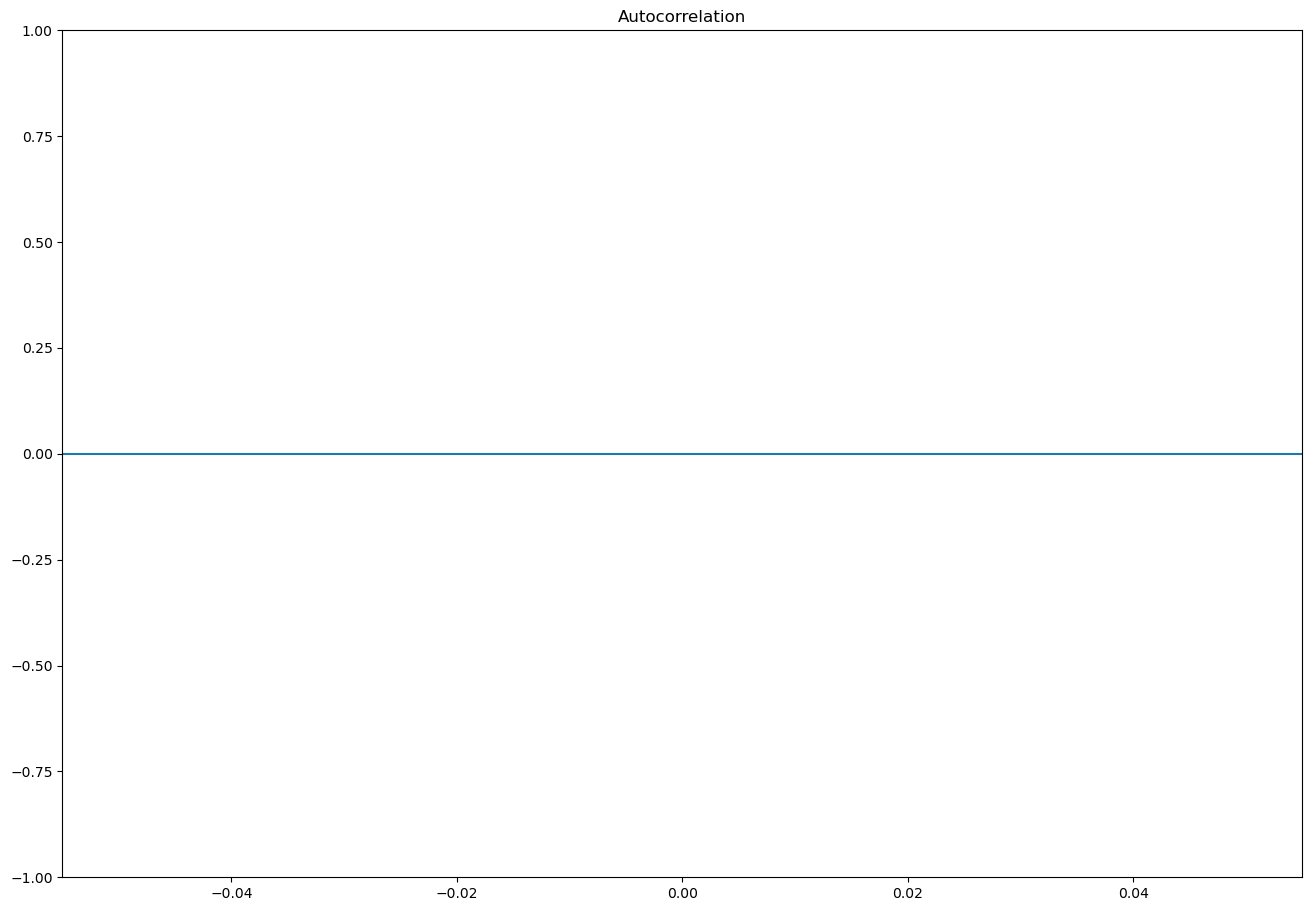

In [1290]:
residuals = ser_LATAM_p_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

# -------------------------------------------------------------------------------------------

### *3. Super Premium*

In [1291]:
df_LATAM_sp = dfs['df_LATAM_Super Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3092766948.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3092766948.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


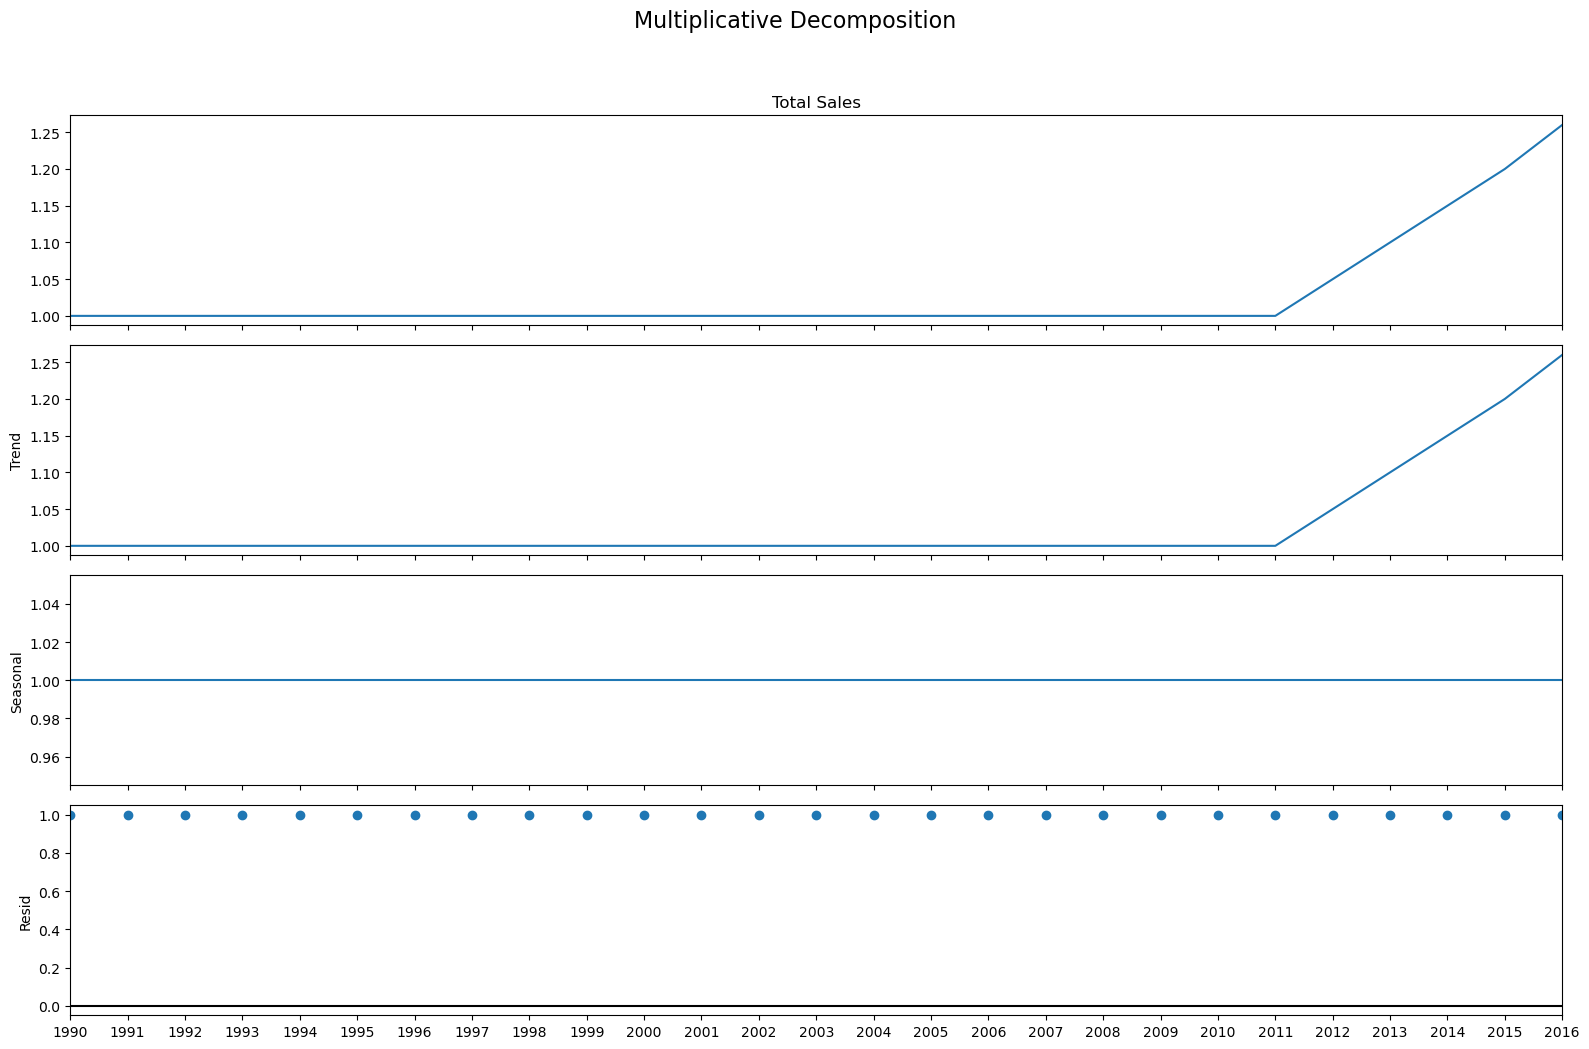

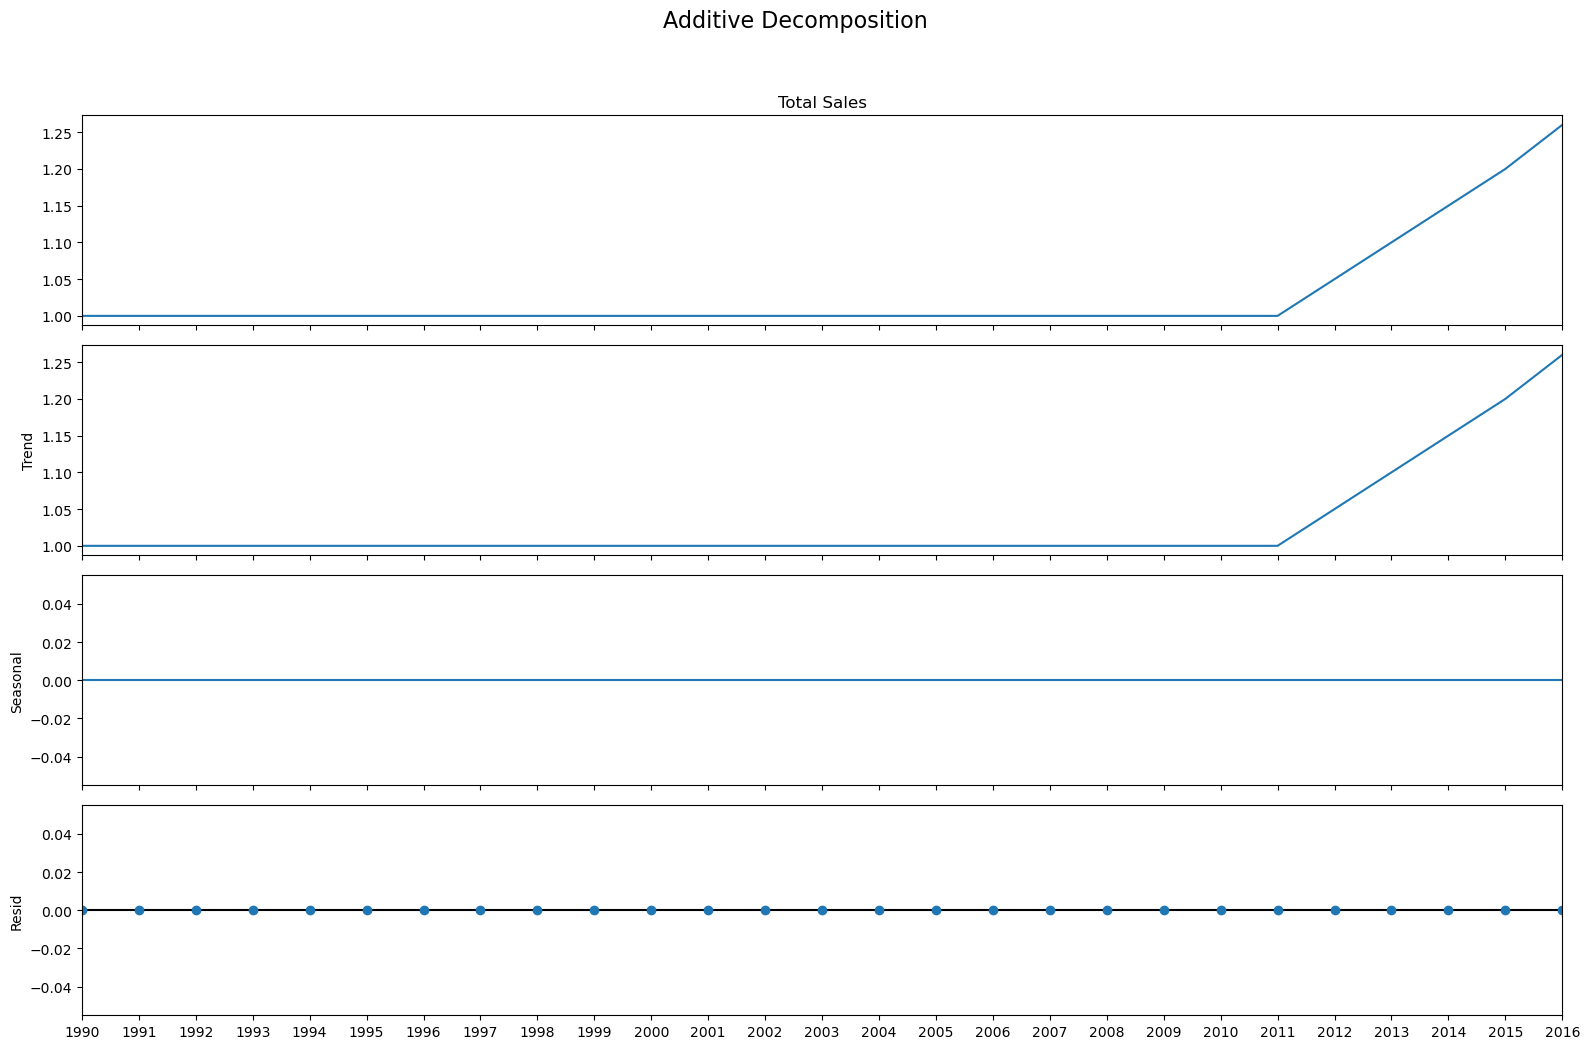

In [1292]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_LATAM_sp.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_LATAM_sp.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1293]:
k = np.floor(df_LATAM_sp.shape[0]*.9).astype('int')
df_LATAM_sp_train = df_LATAM_sp.iloc[0:k,:]
df_LATAM_sp_test = df_LATAM_sp.iloc[k:, :]

In [1294]:
ser_LATAM_sp_train = pd.Series(df_LATAM_p_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_LATAM_sp_train), freq = "A"))
ser_LATAM_sp_test = pd.Series(df_LATAM_sp_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_LATAM_sp_test), freq = "A"))

In [1295]:
LATAM_SP = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1296]:
# ETS
mod_LATAM_sp_ets = ETSModel(ser_LATAM_sp_train, error = 'add',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_LATAM_sp_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(AAdN)   Log Likelihood                 844.951
Date:                Sat, 20 Apr 2024   AIC                          -1677.902
Time:                        23:58:53   BIC                          -1670.834
Sample:                    12-31-1990   HQIC                         -1676.027
                         - 12-31-2013   Scale                            0.000
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.1000        nan        nan        nan         nan         nan
smoothing_trend     0.0100      0.064      0.156      0.876      -0.116       0.136
damping_trend       0.9800      

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1297]:
get_metrics(ser_LATAM_sp_train, ser_LATAM_sp_test, mod_LATAM_sp_ets, 'ETS', LATAM_SP)

model    train_rmse  test_rmse  2017  2018
0   ETS  1.241267e-16   0.208247   1.0   1.0

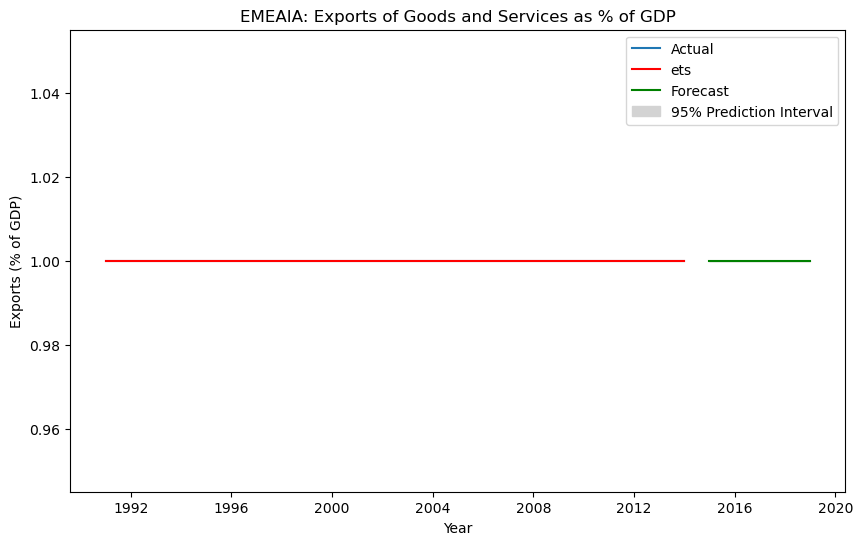

In [1298]:
plot_forecast(ser_LATAM_sp_train, mod_LATAM_sp_ets, 'ets', len(ser_LATAM_sp_test)+2)

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\Anjali\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


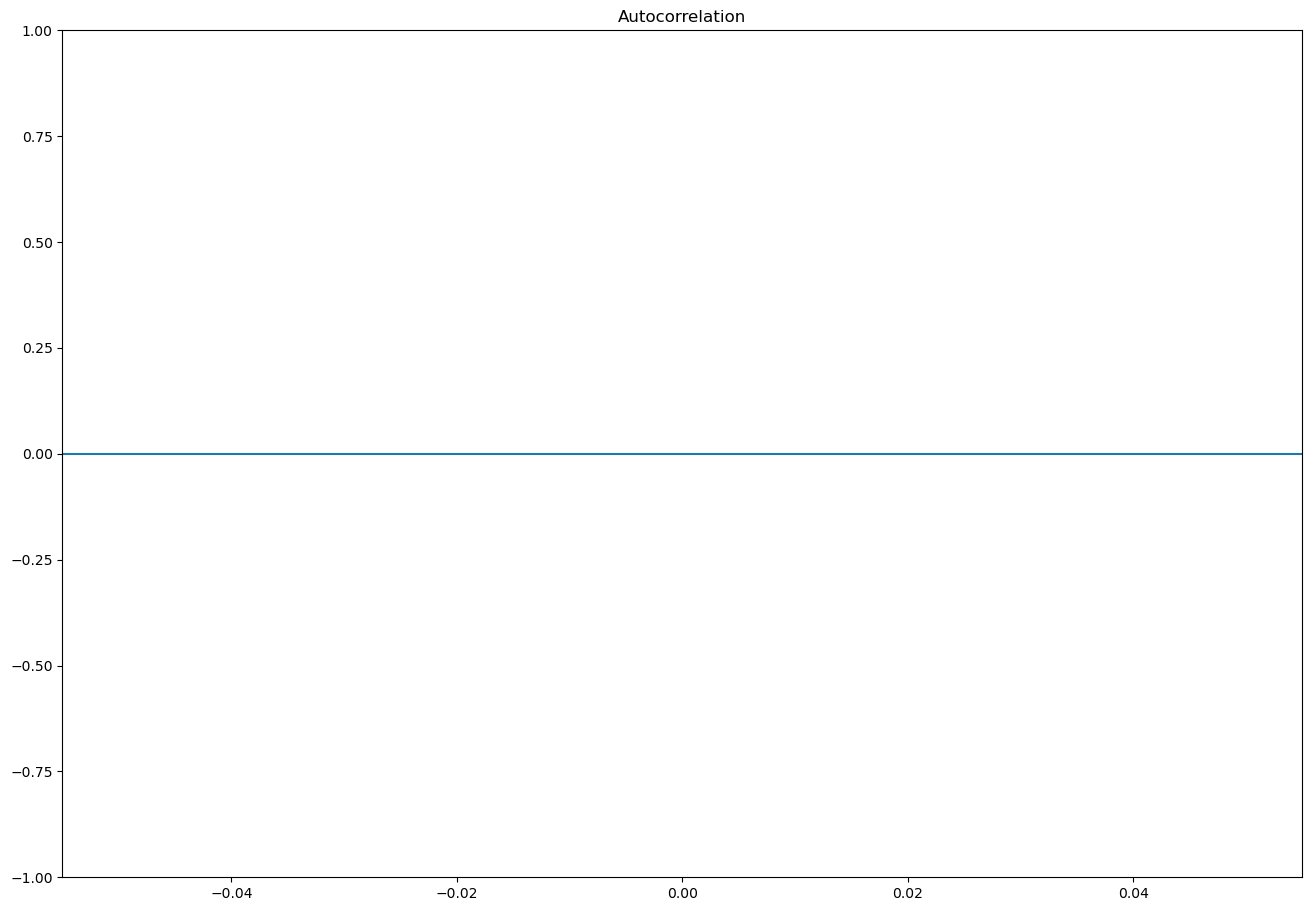

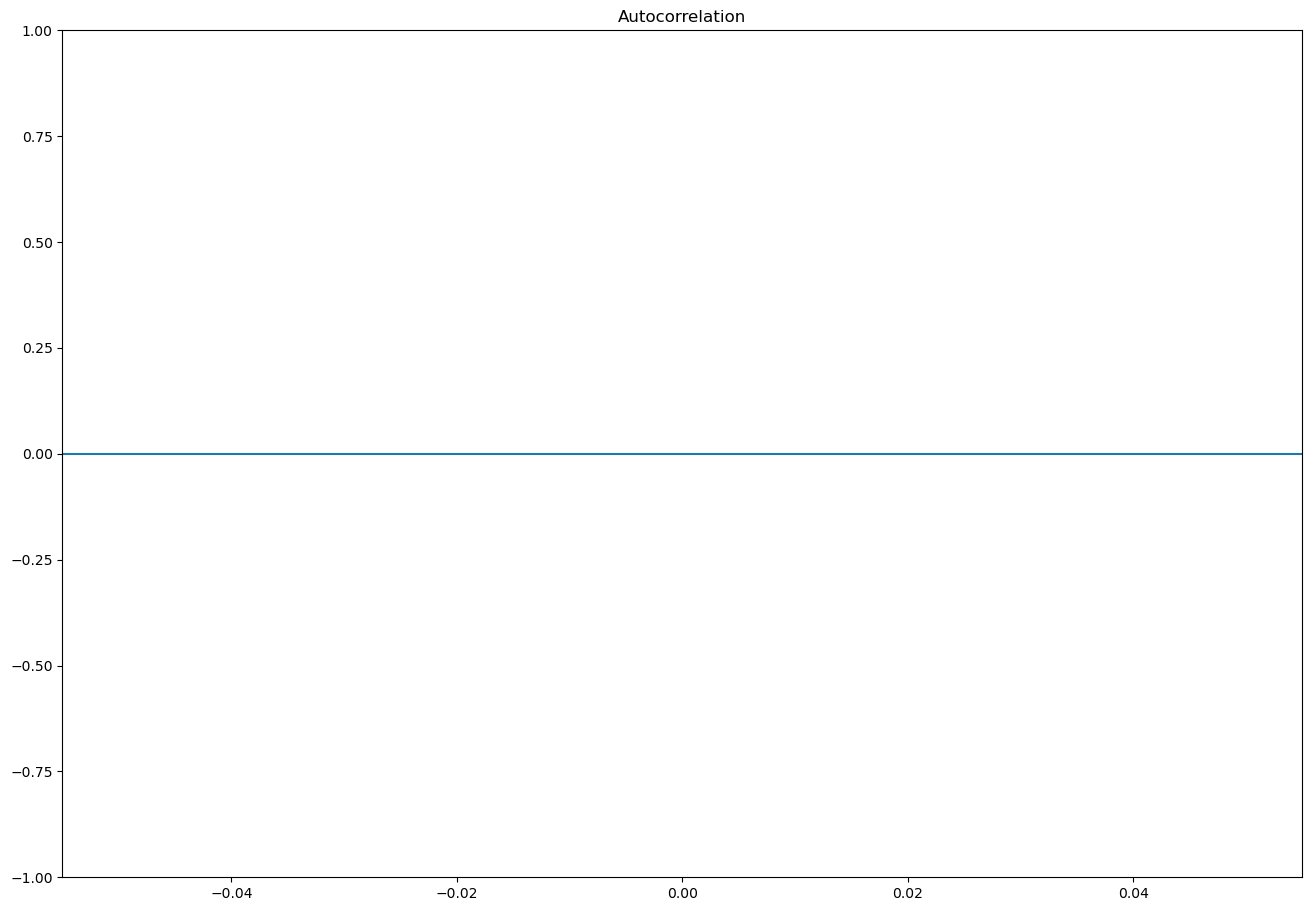

In [1299]:
plot_acf(ser_LATAM_sp_train)

In [1300]:
p = 10
mod_LATAM_sp_ar = sm.tsa.ARIMA(ser_LATAM_sp_train, order = (p, 0, 0)).fit()
print(mod_LATAM_sp_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 255.311
Date:                Sat, 20 Apr 2024   AIC                           -486.622
Time:                        23:58:54   BIC                           -472.485
Sample:                    12-31-1990   HQIC                          -482.872
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   3.33e-13      3e+12      0.000       1.000       1.000
ar.L1       2.011e-17   1.54e-18     13.063      0.000    1.71e-17    2.31e-17
ar.L2       4.019e-17   1.47e-18     27.302      0.0

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


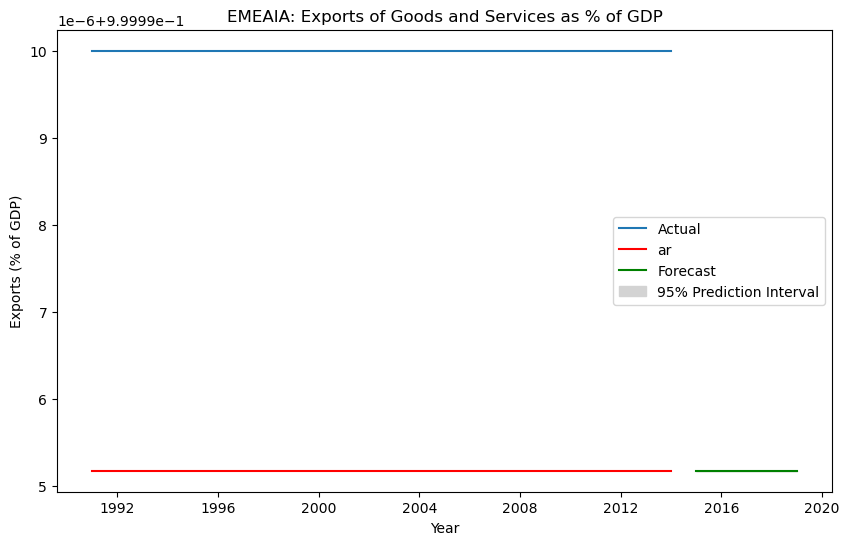

In [1301]:
plot_forecast(ser_LATAM_sp_train, mod_LATAM_sp_ar, 'ar', len(ser_LATAM_sp_test)+2)

In [1302]:
get_metrics(ser_LATAM_sp_train, ser_LATAM_sp_test, mod_LATAM_sp_ar, 'AR', LATAM_SP)

model    train_rmse  test_rmse      2017      2018
0   ETS  1.241267e-16   0.208247  1.000000  1.000000
1    AR  4.824558e-06   0.208251  0.999995  0.999995

In [1303]:
q = 5
mod_LATAM_sp_ma = sm.tsa.ARIMA(ser_LATAM_sp_train, order = (0, 0, q)).fit()
print(mod_LATAM_sp_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 255.311
Date:                Sat, 20 Apr 2024   AIC                           -496.622
Time:                        23:58:55   BIC                           -488.376
Sample:                    12-31-1990   HQIC                          -494.434
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   3.33e-13      3e+12      0.000       1.000       1.000
ma.L1      -2.011e-17   1.54e-18    -13.063      0.000   -2.31e-17   -1.71e-17
ma.L2      -4.019e-17   1.47e-18    -27.302      0.0

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


In [1304]:
get_metrics(ser_LATAM_sp_train, ser_LATAM_sp_test, mod_LATAM_sp_ma, 'MA', LATAM_SP)

model    train_rmse  test_rmse      2017      2018
0   ETS  1.241267e-16   0.208247  1.000000  1.000000
1    AR  4.824558e-06   0.208251  0.999995  0.999995
2    MA  4.824558e-06   0.208251  0.999995  0.999995

In [1305]:
kpss_level(ser_LATAM_sp_train, 10)

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:2050: RuntimeWarning: invalid value encountered in scalar divide
  kpss_stat = eta / s_hat


nan

In [1306]:
kpss_trend(ser_LATAM_sp_train, 10)

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\432952205.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_trend = kpss(data, regression = 'ct', nlags=lags)


0.771645775301764

In [1307]:
ser_LATAM_sp_train = ser_LATAM_sp_train.diff().dropna()

In [1308]:
mod_LATAM_sp_auto_arima = pm.auto_arima(ser_LATAM_sp_train, stepwise=False, seasonal=True)
mod_LATAM_sp_auto_arima

c:\Users\Anjali\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [1309]:
print(mod_LATAM_sp_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:                        SARIMAX   Log Likelihood                 243.662
Date:                Sat, 20 Apr 2024   AIC                           -485.323
Time:                        23:58:55   BIC                           -484.188
Sample:                    12-31-1991   HQIC                          -485.038
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10   4.13e-10      0.242      0.809    -7.1e-10     9.1e-10
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Pr

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1363: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [1310]:
get_metrics(ser_LATAM_sp_train, ser_LATAM_sp_test, mod_LATAM_sp_auto_arima, 'ARIMA', LATAM_SP)

model    train_rmse  test_rmse      2017      2018
0    ETS  1.241267e-16   0.208247  1.000000  1.000000
1     AR  4.824558e-06   0.208251  0.999995  0.999995
2     MA  4.824558e-06   0.208251  0.999995  0.999995
3  ARIMA  0.000000e+00   1.204173  0.000000  0.000000

In [1311]:
fitted, conf = mod_LATAM_sp_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\Anjali\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<Figure size 1200x800 with 0 Axes>

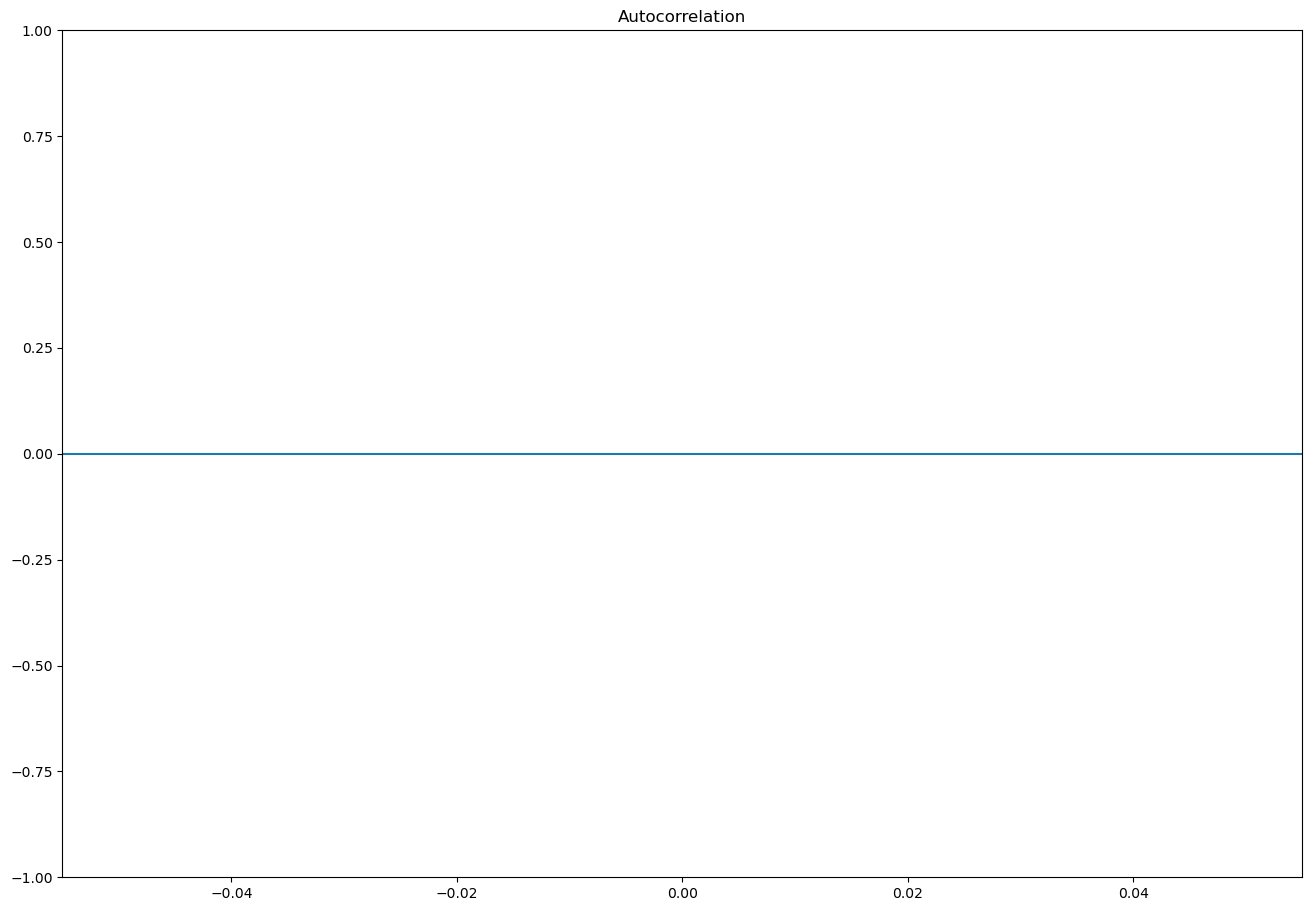

In [1312]:
residuals = ser_LATAM_sp_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

# ---------------------------------------------------------------------------------------

### NA

### *1. Standard*

In [1313]:
df_NA_std = dfs['df_NA_Standard']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3348157230.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\3348157230.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


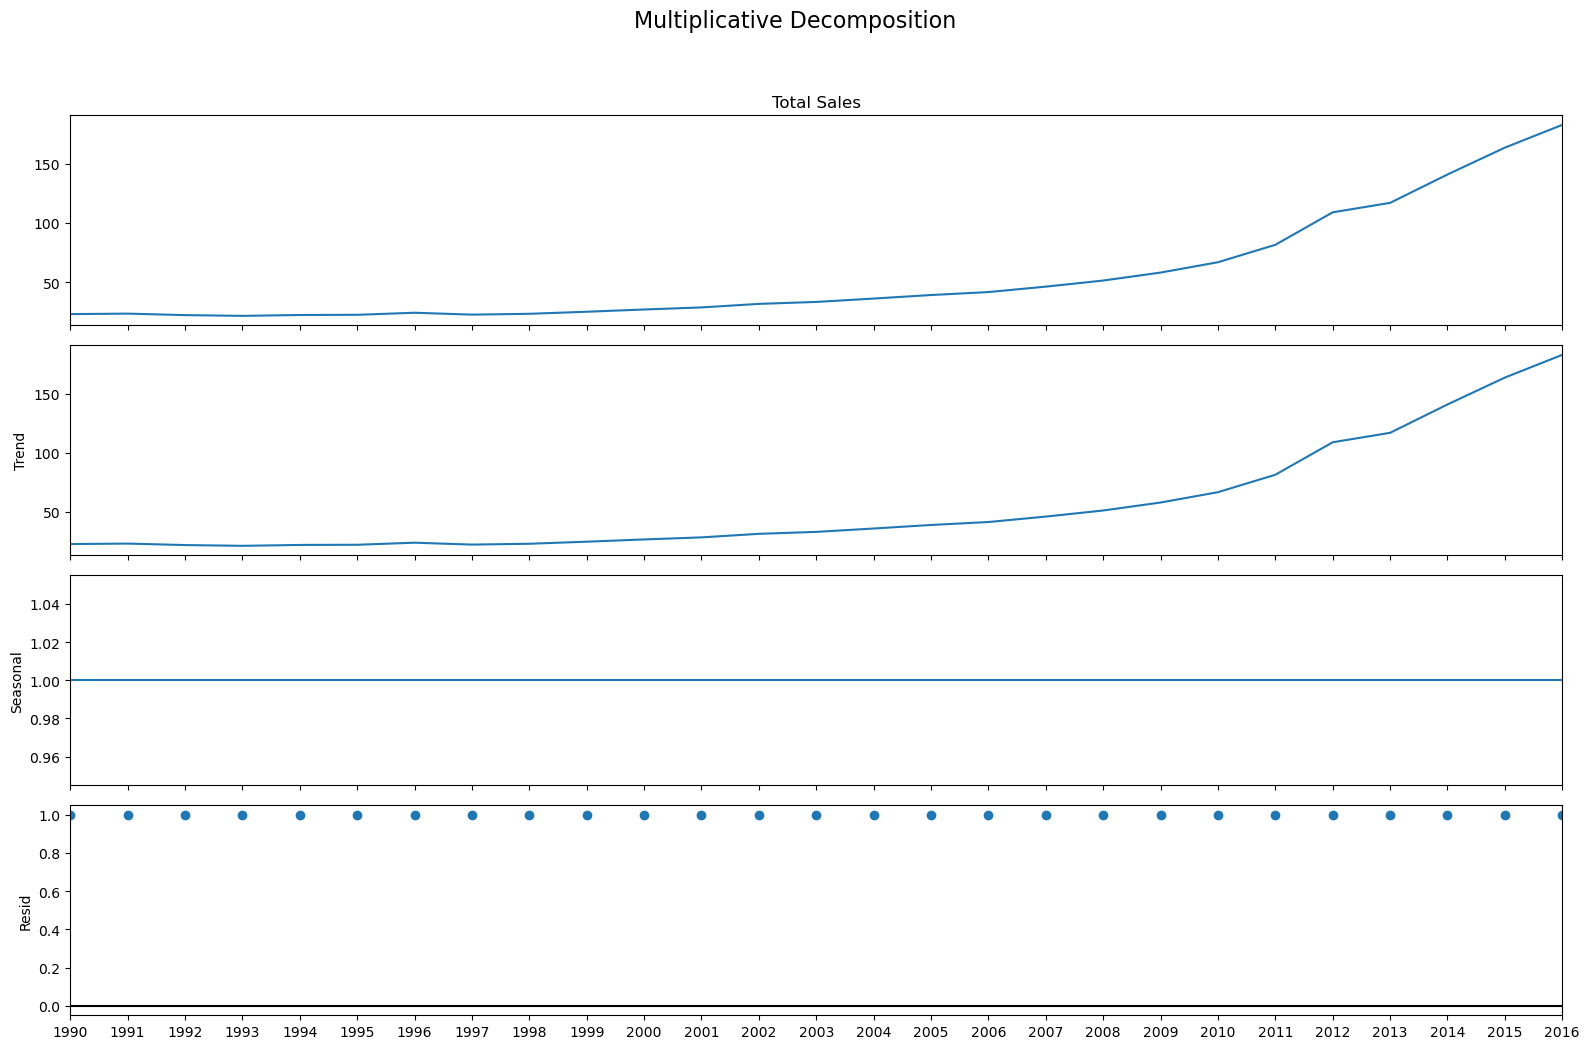

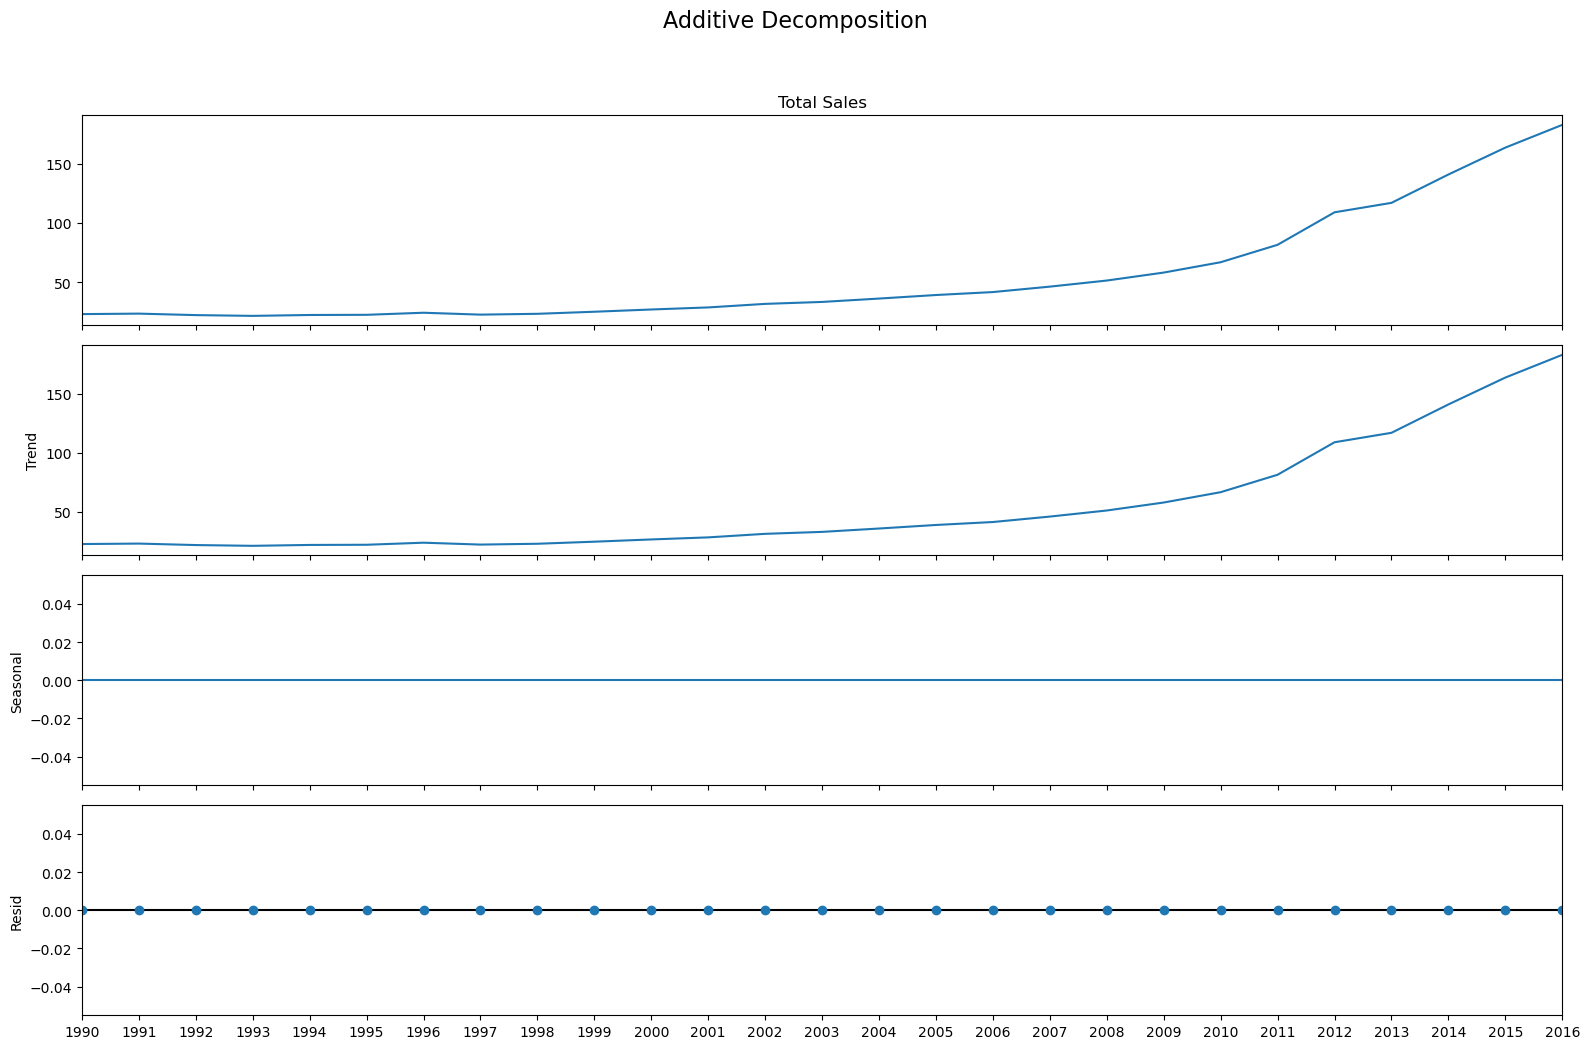

In [1314]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_NA_std.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_NA_std.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1315]:
k = np.floor(df_NA_std.shape[0]*.9).astype('int')
df_NA_std_train = df_NA_std.iloc[0:k,:]
df_NA_std_test = df_NA_std.iloc[k:, :]

In [1316]:
len(df_NA_std_train)

24

In [1317]:
ser_NA_std_train = pd.Series(df_NA_std_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_NA_std_train), freq = "A"))
ser_NA_std_test = pd.Series(df_NA_std_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_NA_std_test), freq = "A"))

In [1318]:
NA_STD = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1319]:
# ETS
mod_NA_std_ets = ETSModel(ser_NA_std_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_NA_std_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -52.402
Date:                Sat, 20 Apr 2024   AIC                            116.804
Time:                        23:58:58   BIC                            123.872
Sample:                    12-31-1990   HQIC                           118.679
                         - 12-31-2013   Scale                            0.004
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8293      0.284      2.918      0.004       0.272       1.386
smoothing_trend     0.7453        nan        nan        nan         nan         nan
damping_trend       0.9800      

In [1320]:
get_metrics(ser_NA_std_train, ser_NA_std_test, mod_NA_std_ets, 'ETS', NA_STD)

model  train_rmse  test_rmse        2017        2018
0   ETS    4.628713  17.146265  173.000087  185.755803

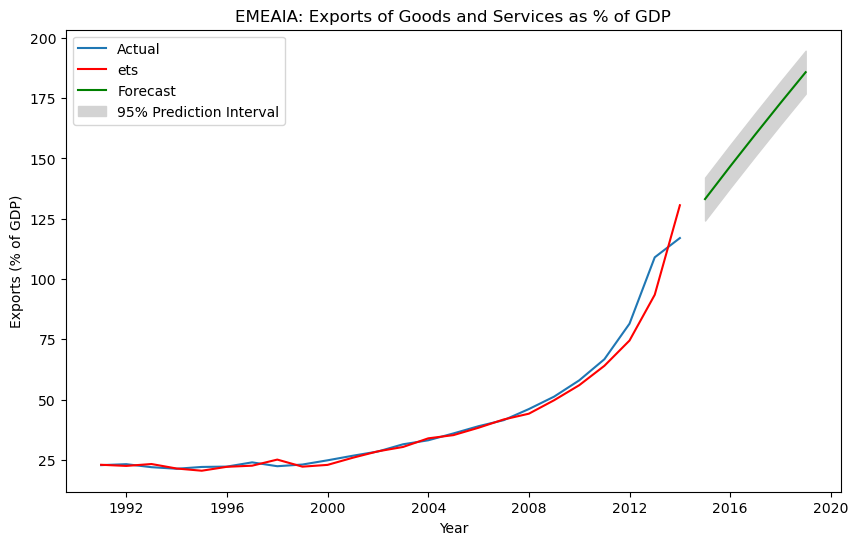

In [1321]:
plot_forecast(ser_NA_std_train, mod_NA_std_ets, 'ets', len(ser_NA_std_test)+2)

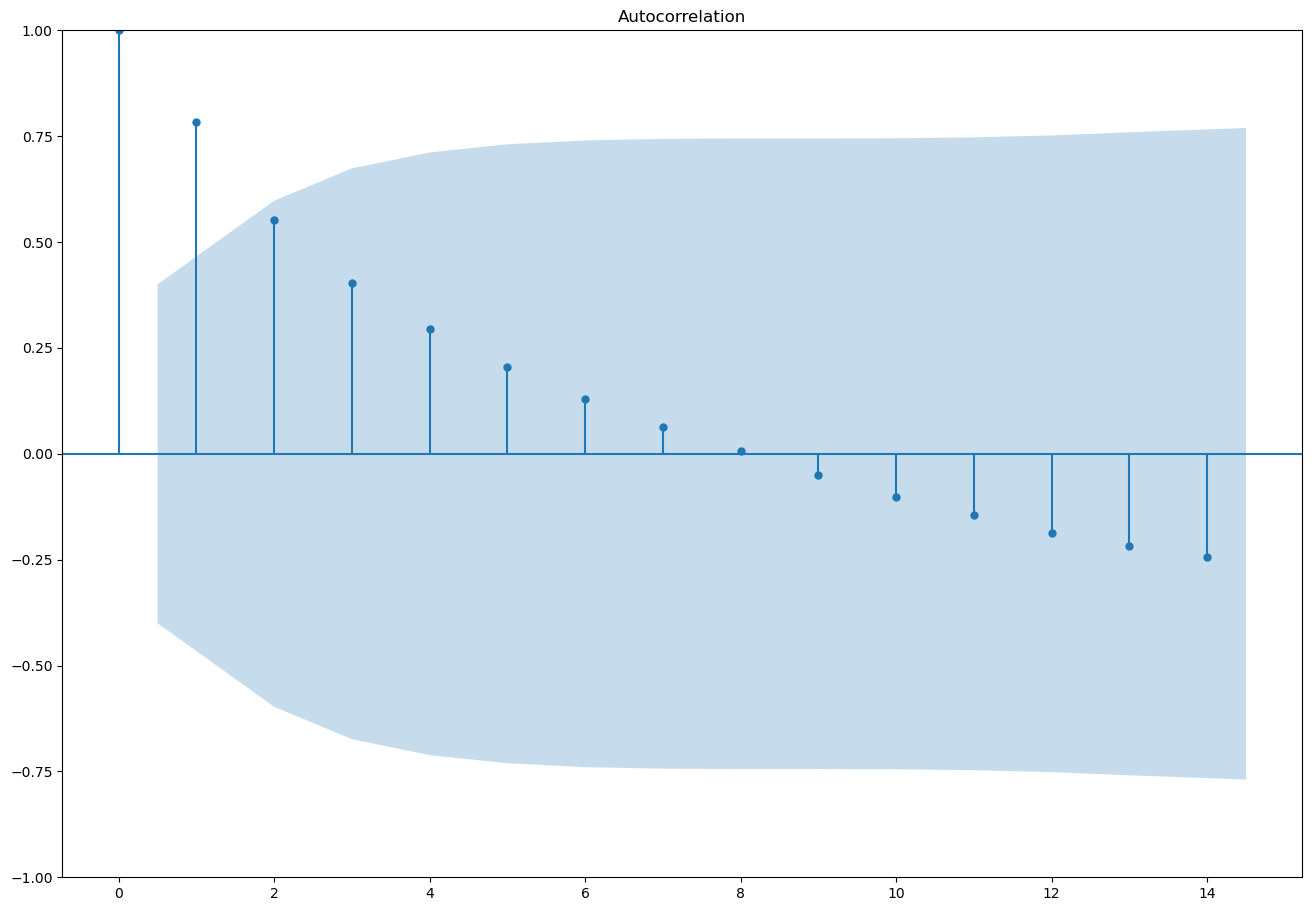

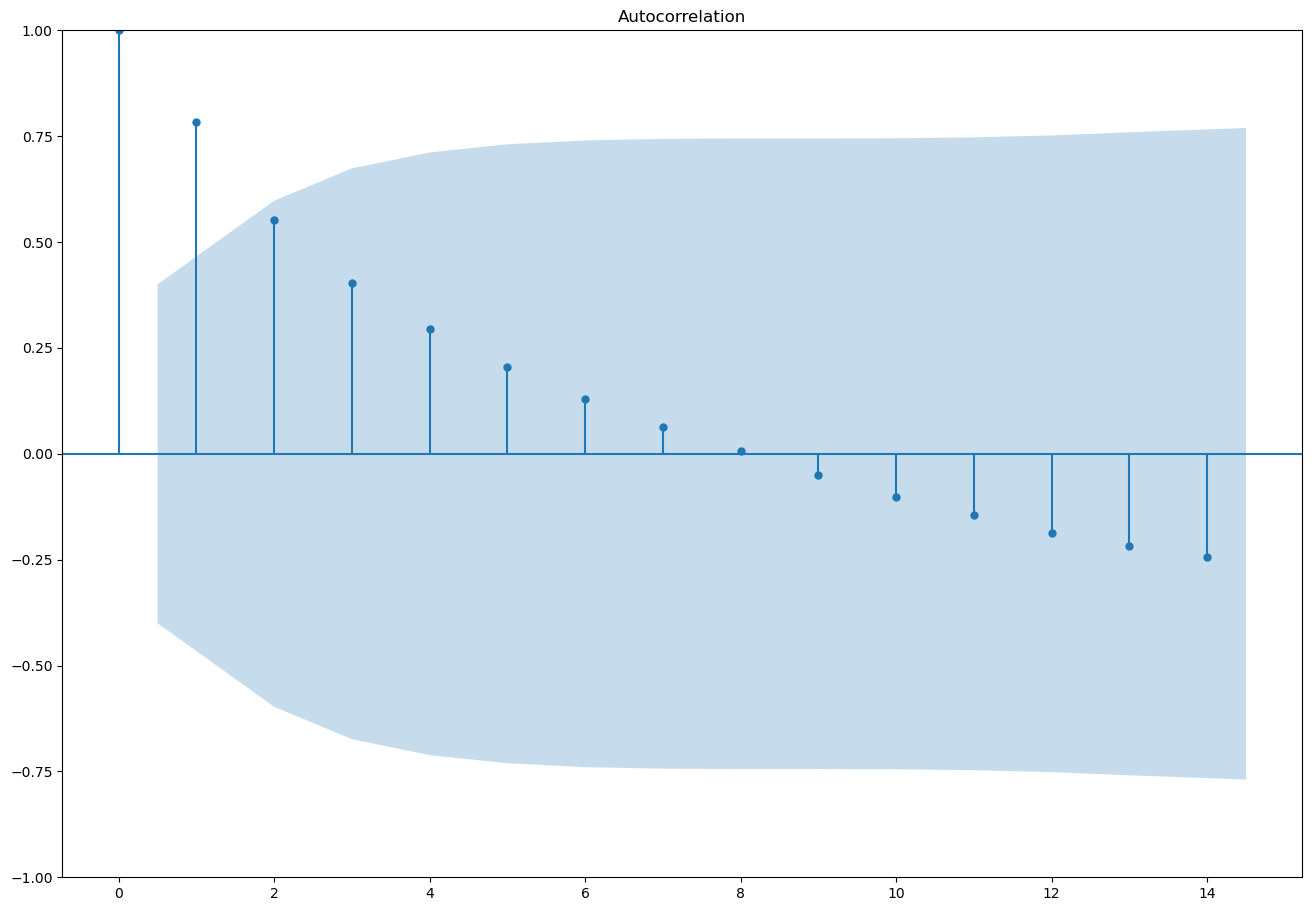

In [1322]:
plot_acf(ser_NA_std_train)

In [1323]:
p = 10
mod_NA_std_ar = sm.tsa.ARIMA(ser_NA_std_train, order = (p, 0, 0)).fit()
print(mod_NA_std_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                 -73.629
Date:                Sat, 20 Apr 2024   AIC                            171.257
Time:                        23:59:00   BIC                            185.394
Sample:                    12-31-1990   HQIC                           175.008
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.9428     57.579      1.319      0.187     -36.910     188.796
ar.L1          1.4454      1.575      0.918      0.359      -1.642       4.533
ar.L2         -0.3045      5.840     -0.052      0.9

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


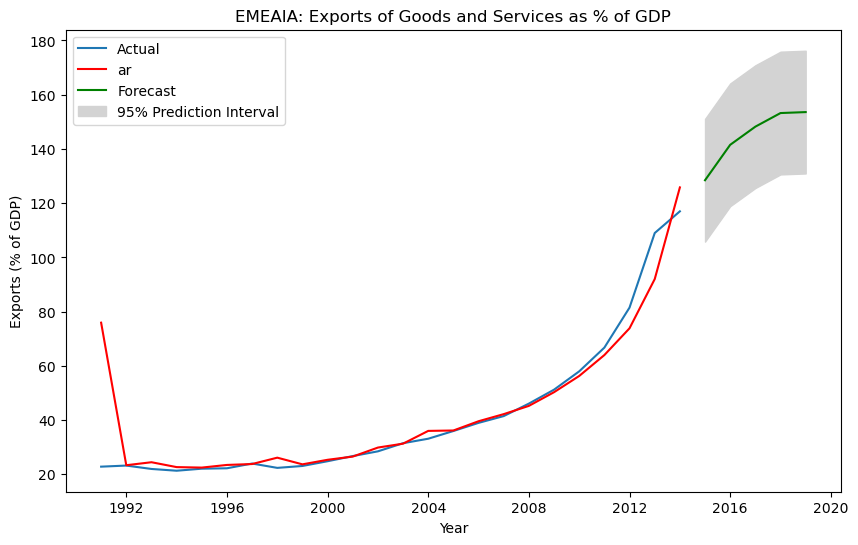

In [1324]:
plot_forecast(ser_NA_std_train, mod_NA_std_ar, 'ar', len(ser_NA_std_test)+2)

In [1325]:
get_metrics(ser_NA_std_train, ser_NA_std_test, mod_NA_std_ar, 'AR', NA_STD)

model  train_rmse  test_rmse        2017        2018
0   ETS    4.628713  17.146265  173.000087  185.755803
1    AR   11.709754  24.902708  153.239857  153.592514

In [1326]:
q = 5
mod_NA_std_ma = sm.tsa.ARIMA(ser_NA_std_train, order = (0, 0, q)).fit()
print(mod_NA_std_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -77.572
Date:                Sat, 20 Apr 2024   AIC                            169.145
Time:                        23:59:00   BIC                            177.391
Sample:                    12-31-1990   HQIC                           171.333
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.5798     16.085      2.709      0.007      12.054      75.105
ma.L1          2.3444     10.093      0.232      0.816     -17.438      22.127
ma.L2          2.8460     21.901      0.130      0.8

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [1327]:
get_metrics(ser_NA_std_train, ser_NA_std_test, mod_NA_std_ma, 'MA', NA_STD)

model  train_rmse  test_rmse        2017        2018
0   ETS    4.628713  17.146265  173.000087  185.755803
1    AR   11.709754  24.902708  153.239857  153.592514
2    MA    6.750588  96.282553   36.504178   41.819202

In [1328]:
kpss_level(ser_NA_std_train, 10)

0.3735214322154755

In [1329]:
kpss_trend(ser_NA_std_train, 10)

0.163528163107578

In [1330]:
ser_NA_std_train = ser_NA_std_train.diff().dropna()

In [1331]:
mod_NA_std_auto_arima = pm.auto_arima(ser_NA_std_train, stepwise=False, seasonal=True)
mod_NA_std_auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1332]:
mod_NA_std_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -64.469
Date:                Sat, 20 Apr 2024   AIC                            134.938
Time:                        23:59:03   BIC                            138.211
Sample:                    12-31-1991   HQIC                           135.709
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7110      0.820      0.867      0.386      -0.896       2.318
ma.L1         -0.6780      0.172     -3.948      0.000      -1.015      -0.341
sigma2        19.9848      5.070      3.942      0.000      10.048      29.921
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                56.57
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              16.31   Skew:                             2.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1333]:
get_metrics(ser_NA_std_train, ser_NA_std_test, mod_NA_std_auto_arima, 'ARIMA', NA_STD)

model  train_rmse   test_rmse        2017        2018
0    ETS    4.628713   17.146265  173.000087  185.755803
1     AR   11.709754   24.902708  153.239857  153.592514
2     MA    6.750588   96.282553   36.504178   41.819202
3  ARIMA    4.382933  147.955029   16.983027   17.694068

In [1334]:
fitted, conf = mod_NA_std_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

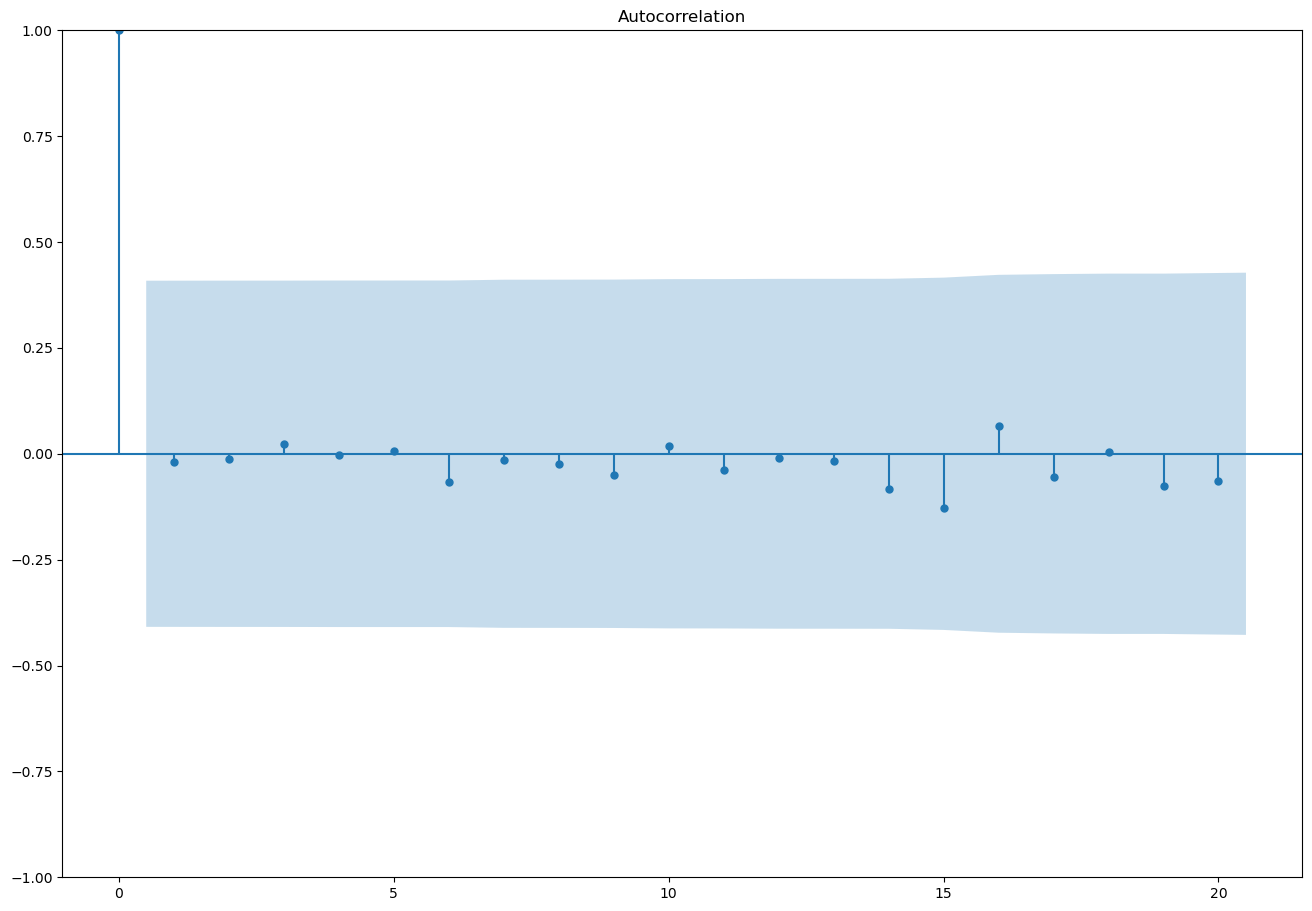

In [1335]:
residuals = ser_NA_std_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

# -------------------------------------------------------------------------------------------

### *2. Premium*

In [1336]:
df_NA_p = dfs['df_NA_Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\1295317565.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\1295317565.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


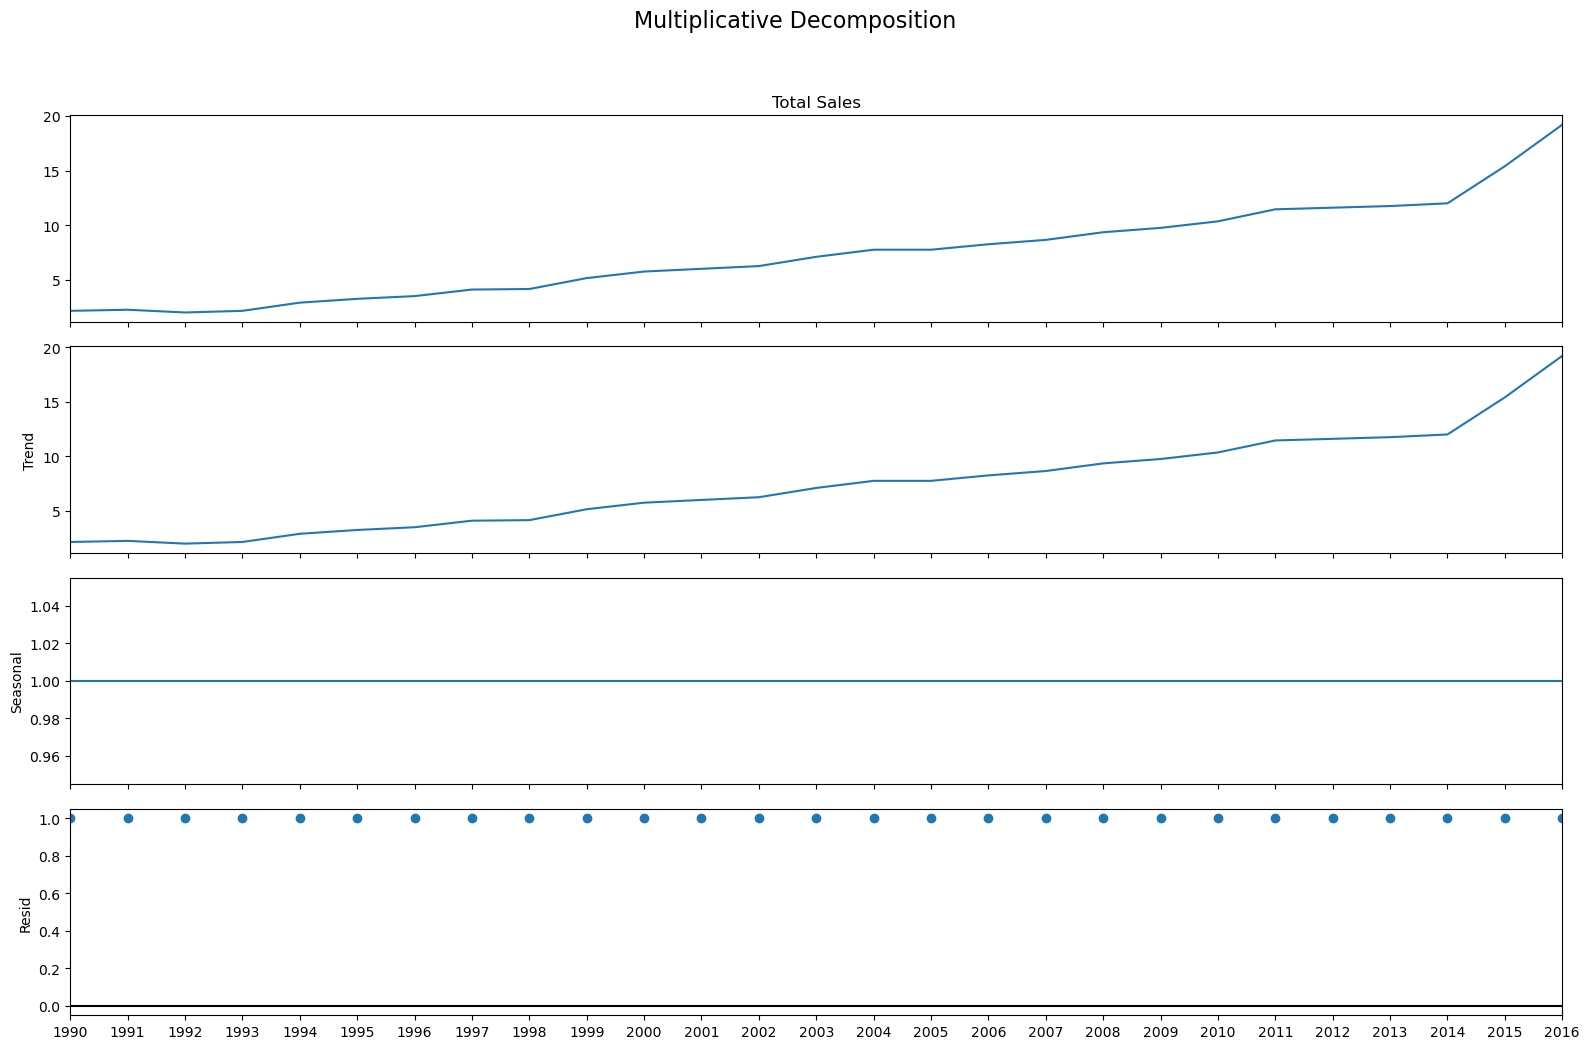

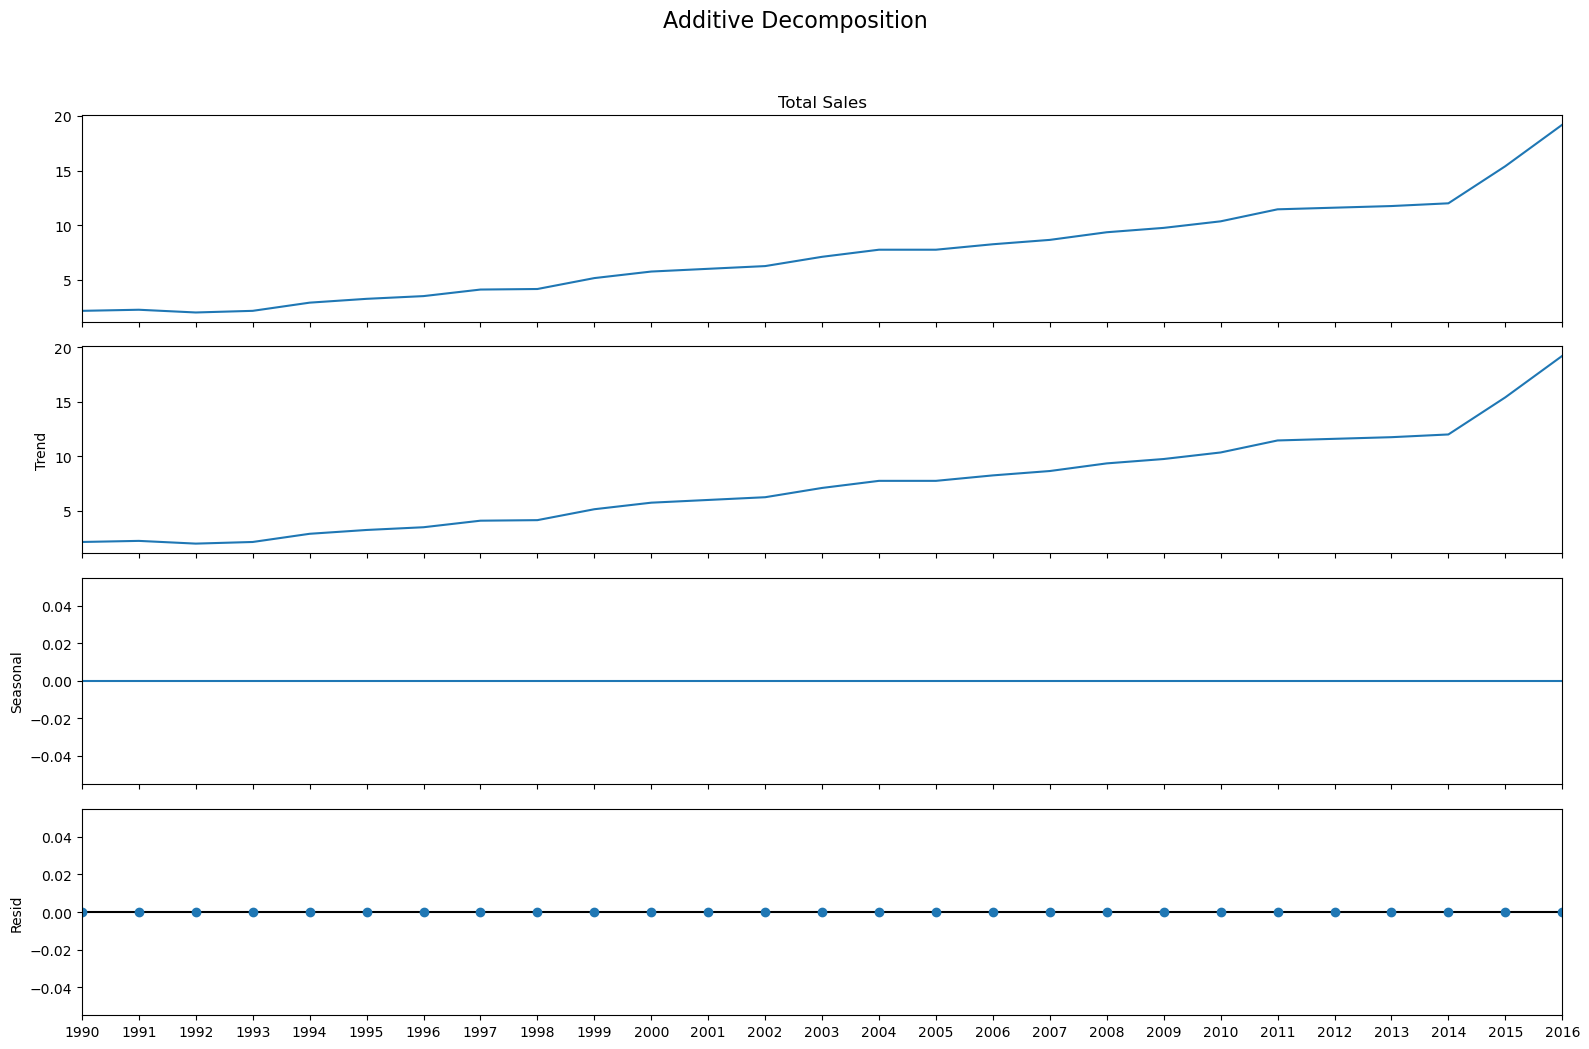

In [1337]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_NA_p.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_NA_p.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1338]:
k = np.floor(df_NA_p.shape[0]*.9).astype('int')
df_NA_p_train = df_NA_p.iloc[0:k,:]
df_NA_p_test = df_NA_p.iloc[k:, :]

In [1339]:
ser_NA_p_train = pd.Series(df_NA_p_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_NA_p_train), freq = "A"))
ser_NA_p_test = pd.Series(df_NA_p_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_NA_p_test), freq = "A"))

In [1340]:
NA_P = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1341]:
# ETS
mod_NA_p_ets = ETSModel(ser_NA_p_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_NA_p_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                 -14.520
Date:                Sat, 20 Apr 2024   AIC                             41.040
Time:                        23:59:07   BIC                             48.108
Sample:                    12-31-1990   HQIC                            42.915
                         - 12-31-2013   Scale                            0.007
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.621      1.610      0.107      -0.217       2.217
smoothing_trend  9.999e-05      0.123      0.001      0.999      -0.242       0.242
damping_trend       0.9800      

In [1342]:
get_metrics(ser_NA_p_train, ser_NA_p_test, mod_NA_p_ets, 'ETS', NA_P)

model  train_rmse  test_rmse       2017       2018
0   ETS    0.361398   4.348996  12.594711  12.795435

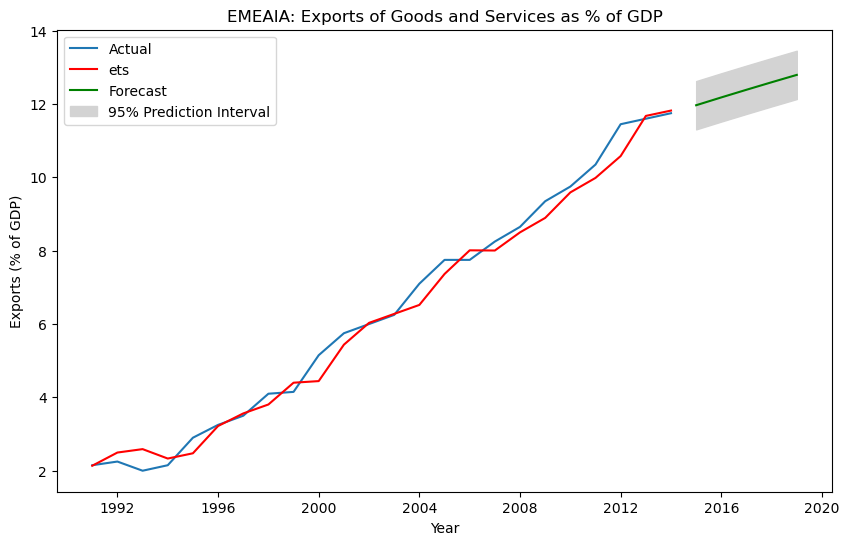

In [1343]:
plot_forecast(ser_NA_p_train, mod_NA_p_ets, 'ets', len(ser_NA_p_test)+2)

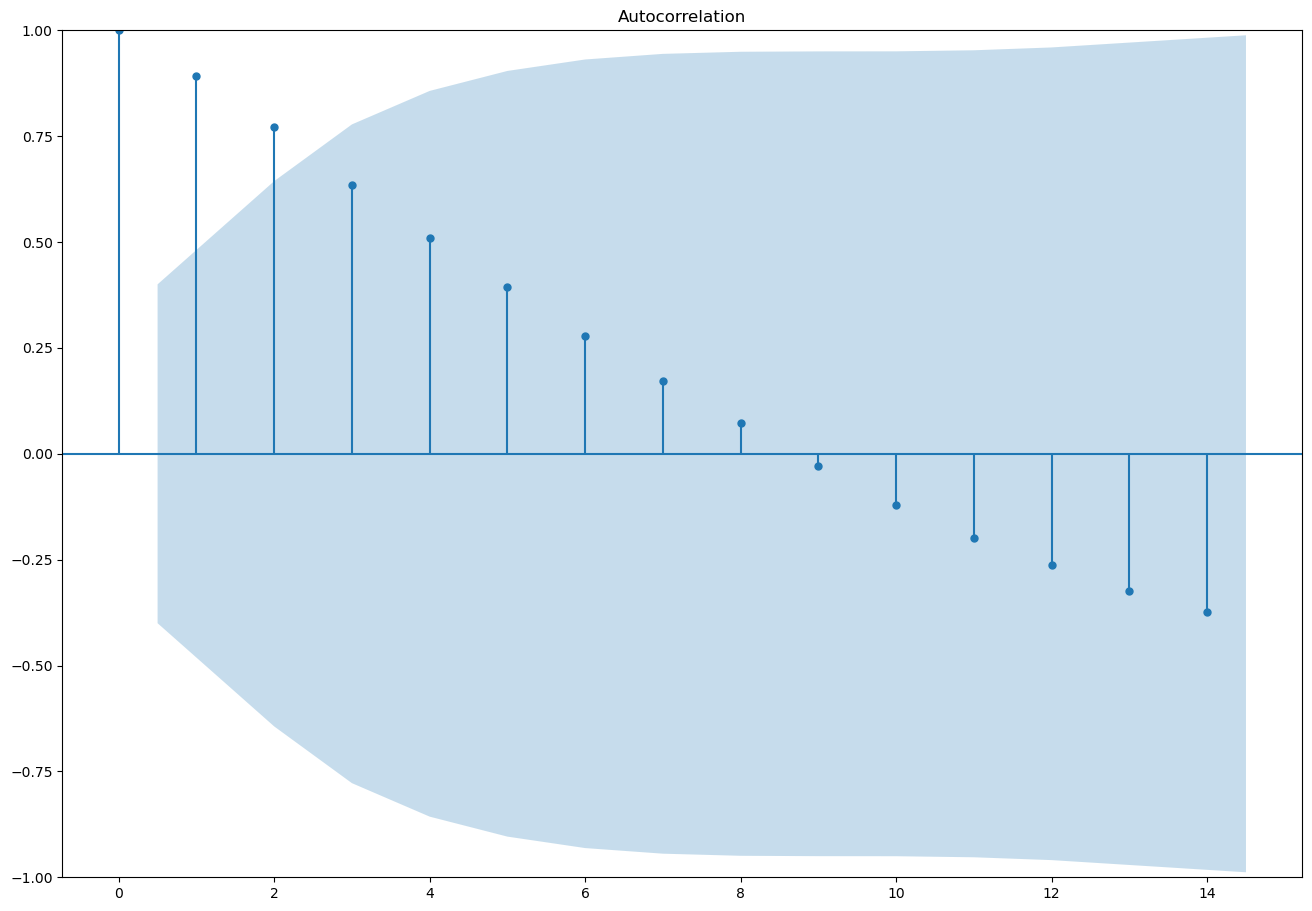

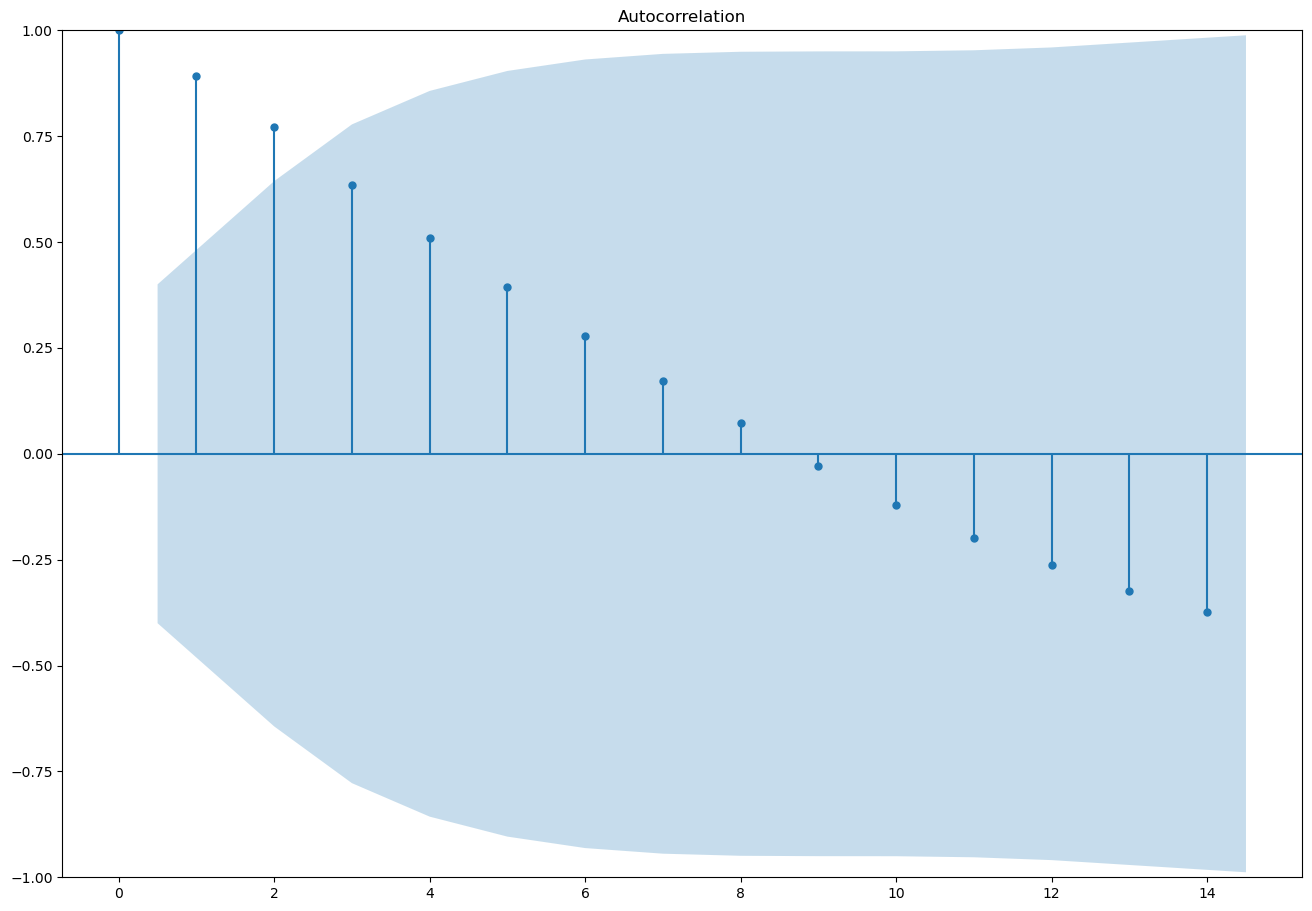

In [1344]:
plot_acf(ser_NA_p_train)

In [1345]:
p = 10
mod_NA_p_ar = sm.tsa.ARIMA(ser_NA_p_train, order = (p, 0, 0)).fit()
print(mod_NA_p_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                  -7.150
Date:                Sat, 20 Apr 2024   AIC                             38.299
Time:                        23:59:08   BIC                             52.436
Sample:                    12-31-1990   HQIC                            42.049
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9786      3.042      2.622      0.009       2.016      13.942
ar.L1          0.9927      0.395      2.513      0.012       0.218       1.767
ar.L2         -0.4063      0.494     -0.823      0.4

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


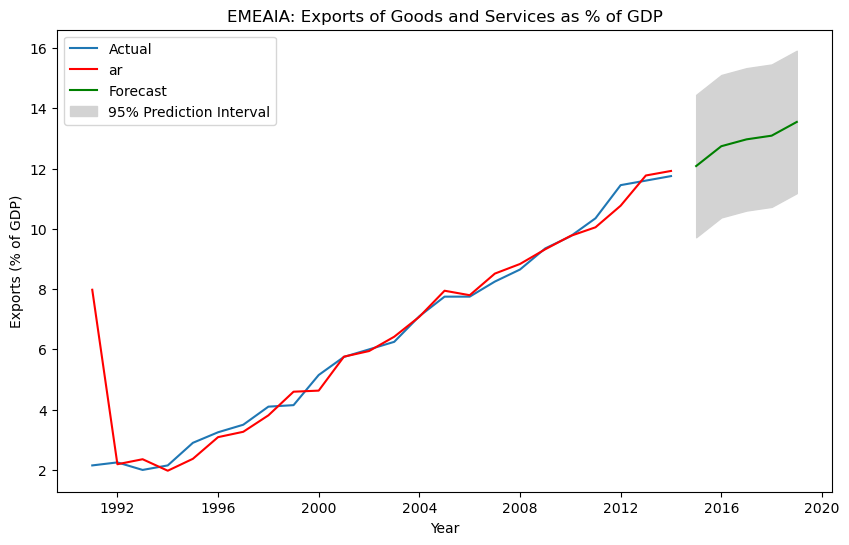

In [1346]:
plot_forecast(ser_NA_p_train, mod_NA_p_ar, 'ar', len(ser_NA_p_test)+2)

In [1347]:
get_metrics(ser_NA_p_train, ser_NA_p_test, mod_NA_p_ar, 'AR', NA_P)

model  train_rmse  test_rmse       2017       2018
0   ETS    0.361398   4.348996  12.594711  12.795435
1    AR    1.221982   3.911567  13.091329  13.547302

In [1348]:
q = 5
mod_NA_p_ma = sm.tsa.ARIMA(ser_NA_p_train, order = (0, 0, q)).fit()
print(mod_NA_p_ma.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 -23.649
Date:                Sat, 20 Apr 2024   AIC                             61.298
Time:                        23:59:09   BIC                             69.545
Sample:                    12-31-1990   HQIC                            63.486
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5694      0.866      7.582      0.000       4.871       8.267
ma.L1          1.8144     10.136      0.179      0.858     -18.051      21.680
ma.L2          2.0522     17.584      0.117      0.9

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1349]:
get_metrics(ser_NA_p_train, ser_NA_p_test, mod_NA_p_ma, 'MA', NA_P)

model  train_rmse  test_rmse       2017       2018
0   ETS    0.361398   4.348996  12.594711  12.795435
1    AR    1.221982   3.911567  13.091329  13.547302
2    MA    1.055941   6.303202   8.316760   7.397572

In [1350]:
kpss_level(ser_NA_p_train, 10)

0.382188345832814

In [1351]:
kpss_trend(ser_NA_p_train, 10)

0.17728428921744402

In [1352]:
ser_NA_p_train = ser_NA_p_train.diff().dropna()

In [1353]:
mod_NA_p_auto_arima = pm.auto_arima(ser_NA_p_train, stepwise=False, seasonal=True)
mod_NA_p_auto_arima

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1354]:
mod_NA_p_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                        SARIMAX   Log Likelihood                  -7.129
Date:                Sat, 20 Apr 2024   AIC                             18.257
Time:                        23:59:12   BIC                             20.528
Sample:                    12-31-1991   HQIC                            18.829
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4174      0.070      5.984      0.000       0.281       0.554
sigma2         0.1088      0.038      2.847      0.004       0.034       0.184
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.96   Prob(JB):                         0.80
Heteroskedasticity (H):               0.79   Skew:                             0.20
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1355]:
get_metrics(ser_NA_p_train, ser_NA_p_test, mod_NA_p_auto_arima, 'ARIMA', NA_P)

model  train_rmse  test_rmse       2017       2018
0    ETS    0.361398   4.348996  12.594711  12.795435
1     AR    1.221982   3.911567  13.091329  13.547302
2     MA    1.055941   6.303202   8.316760   7.397572
3  ARIMA    0.329891  15.399370   0.417391   0.417391

In [1356]:
fitted, conf = mod_NA_p_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

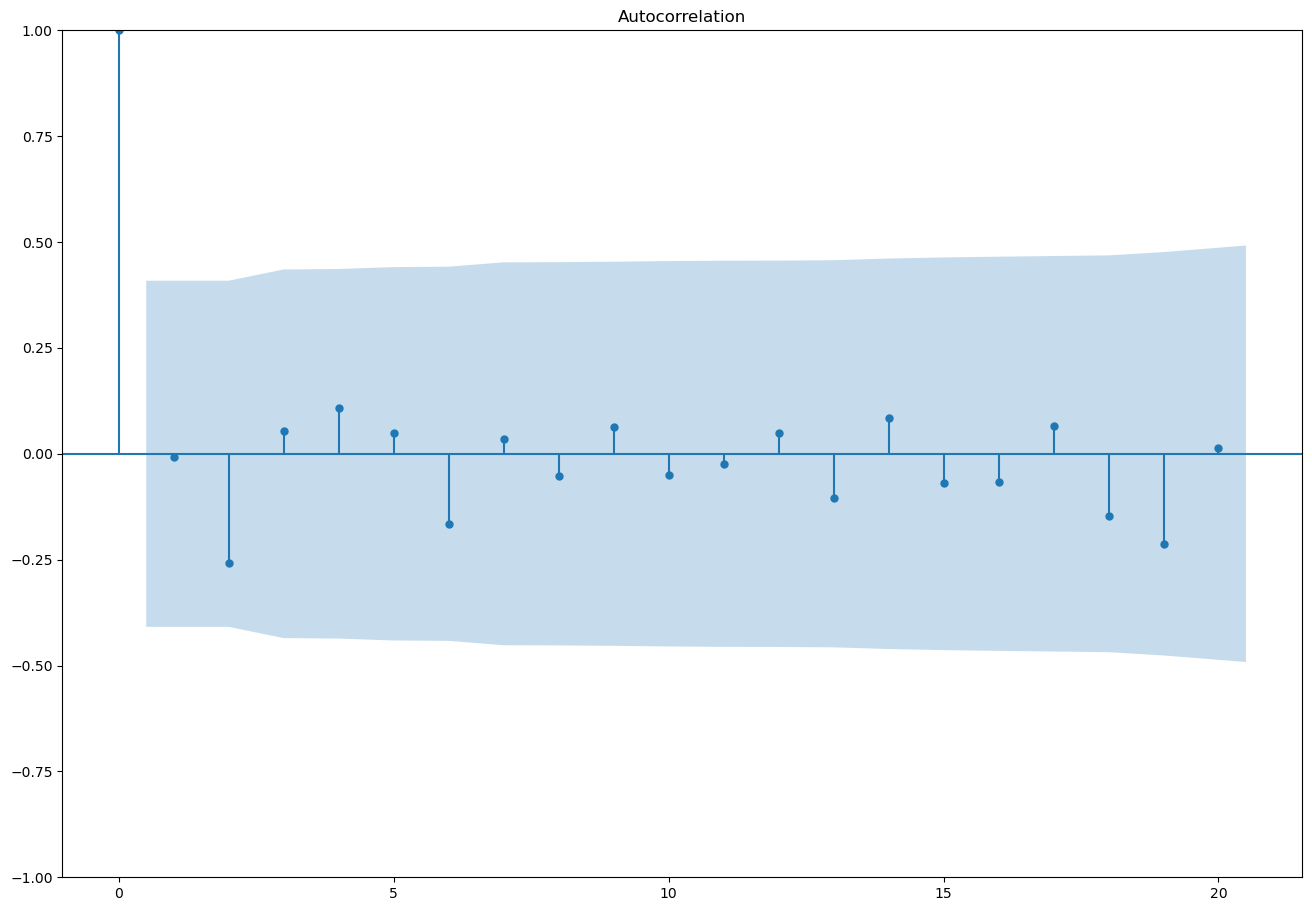

In [1357]:
residuals = ser_NA_p_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

# -----------------------------------------------------------------------------------------

### *3. Super Premium*

In [1358]:
df_NA_sp = dfs['df_NA_Super Premium']

C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\68546625.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


C:\Users\Anjali\AppData\Local\Temp\ipykernel_6756\68546625.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


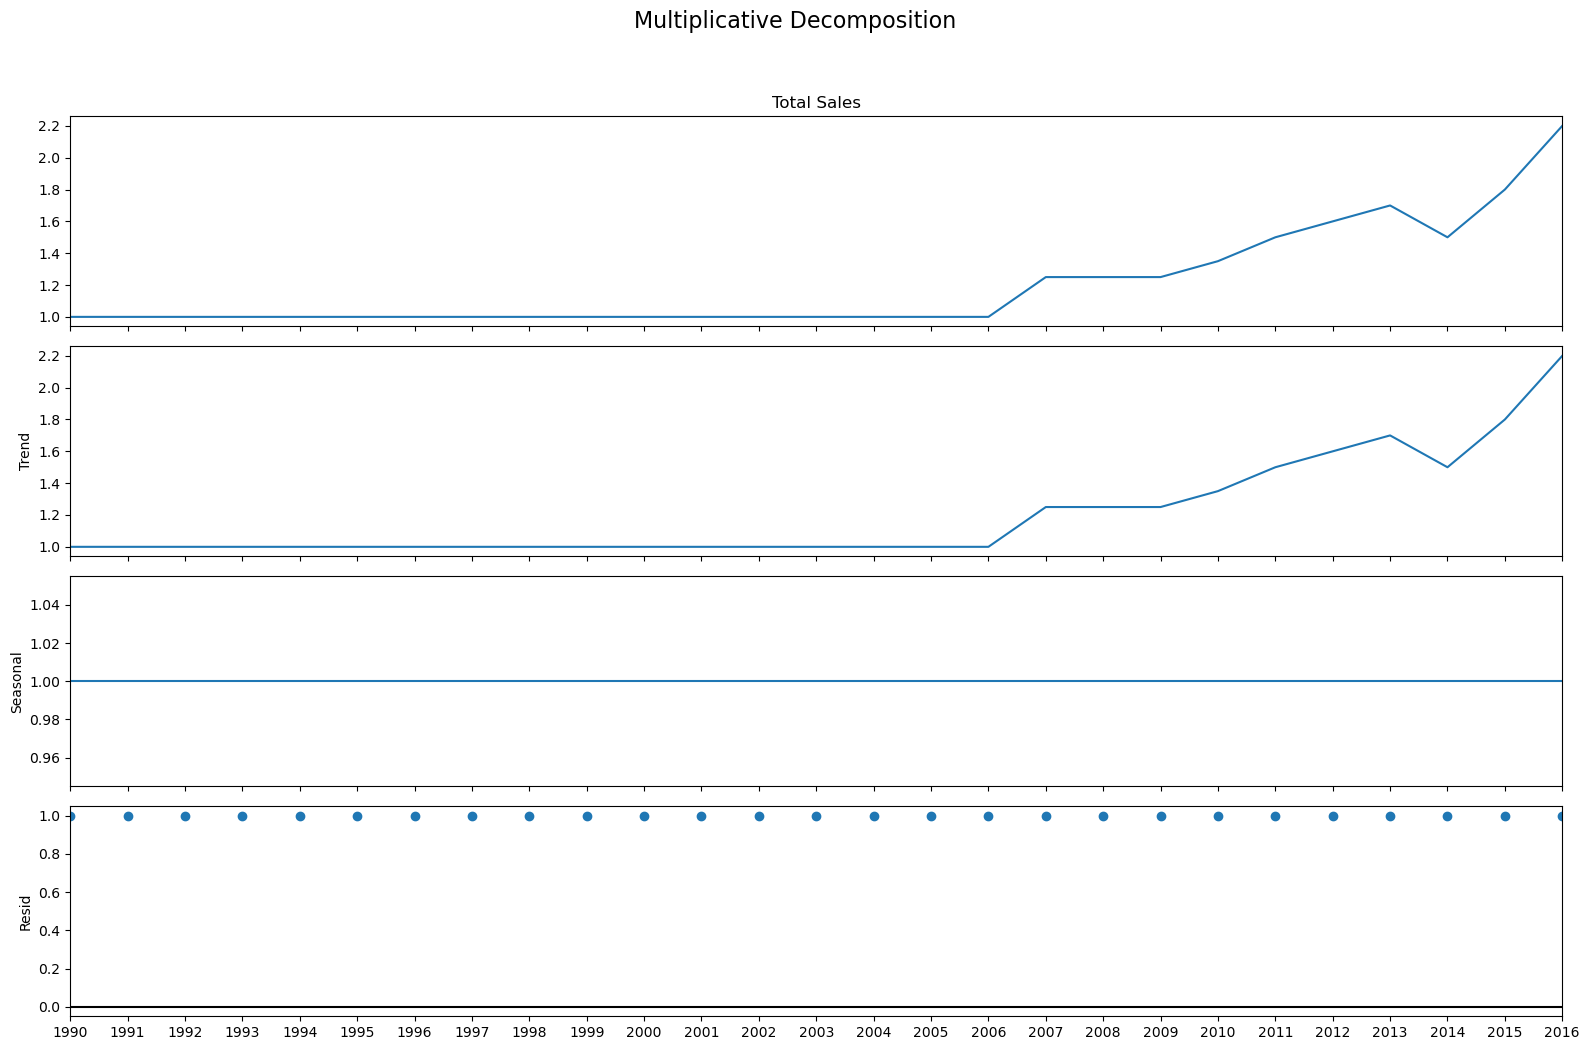

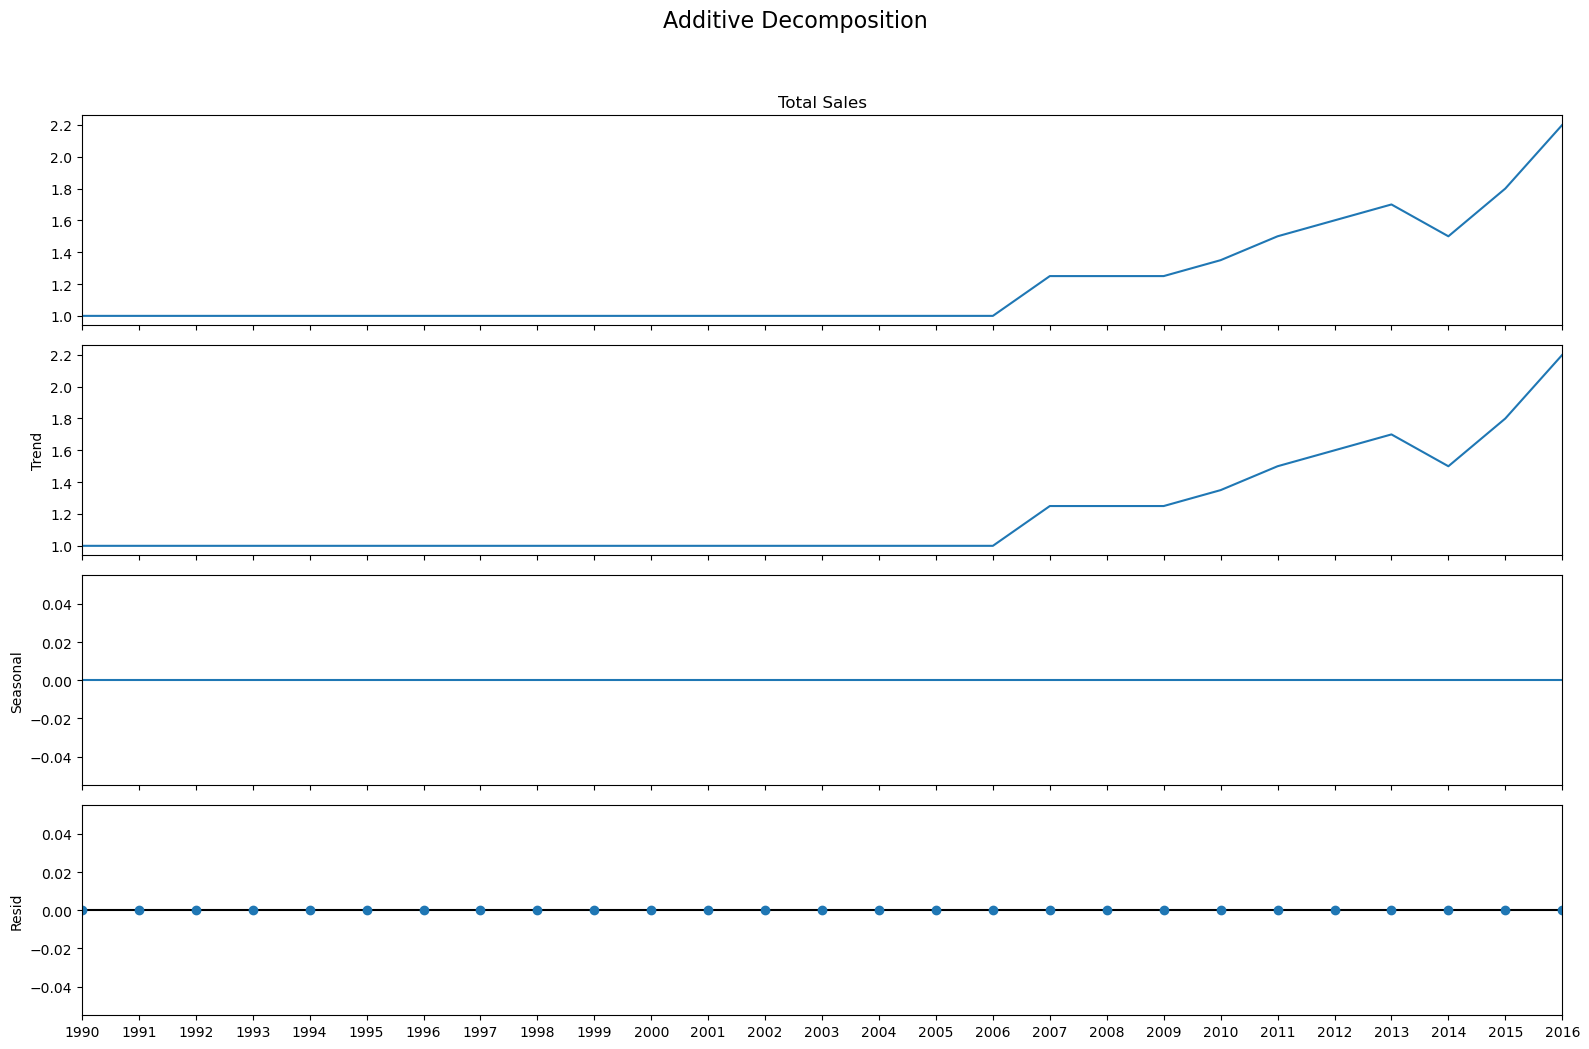

In [1359]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_NA_sp.set_index('Year')['Total Sales'], model = 'multiplicative', period = 1)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_NA_sp.set_index('Year')['Total Sales'], model = 'additive', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (16, 11)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("\n\n")
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [1360]:
k = np.floor(df_NA_sp.shape[0]*.9).astype('int')
df_NA_sp_train = df_NA_sp.iloc[0:k,:]
df_NA_sp_test = df_NA_sp.iloc[k:, :]

In [1361]:
ser_NA_sp_train = pd.Series(df_NA_sp_train['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_NA_sp_train), freq = "A"))
ser_NA_sp_test = pd.Series(df_NA_sp_test['Total Sales'].values, index = pd.date_range(start = '1990', periods = len(df_NA_sp_test), freq = "A"))

In [1362]:
NA_SP = pd.DataFrame(columns = ['model', 'train_rmse', 'test_rmse', '2017', '2018'])

In [1363]:
# ETS
mod_NA_sp_ets = ETSModel(ser_NA_sp_train, error = 'mul',
    trend = 'add',
    damped_trend = True,
    seasonal = None).fit()

print(mod_NA_sp_ets.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   24
Model:                      ETS(MAdN)   Log Likelihood                  33.716
Date:                Sat, 20 Apr 2024   AIC                            -55.432
Time:                        23:59:16   BIC                            -48.364
Sample:                    12-31-1990   HQIC                           -53.557
                         - 12-31-2013   Scale                            0.003
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4711      0.399      1.181      0.238      -0.311       1.253
smoothing_trend     0.3176      0.226      1.408      0.159      -0.124       0.760
damping_trend       0.9800      

In [1364]:
get_metrics(ser_NA_sp_train, ser_NA_sp_test, mod_NA_sp_ets, 'ETS', NA_SP)

model  train_rmse  test_rmse      2017      2018
0   ETS    0.057336   0.212811  2.114902  2.216181

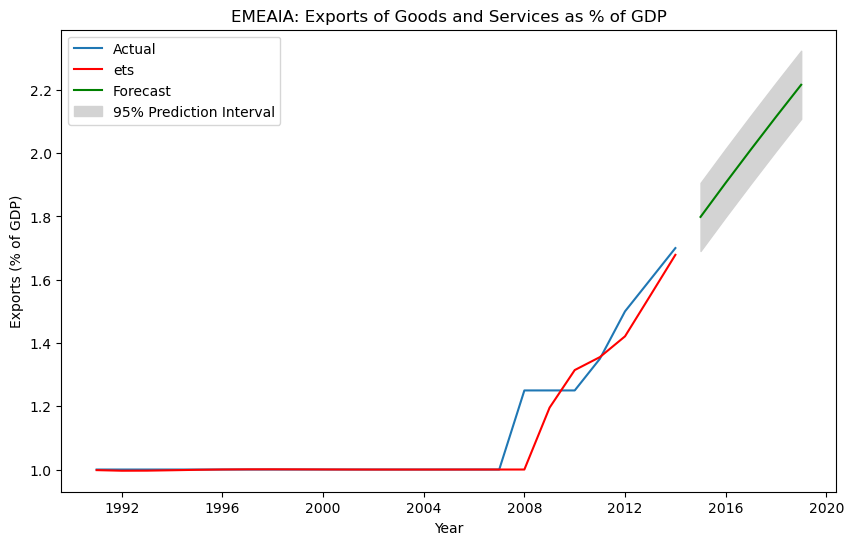

In [1365]:
plot_forecast(ser_NA_sp_train, mod_NA_sp_ets, 'ets', len(ser_NA_sp_test)+2)

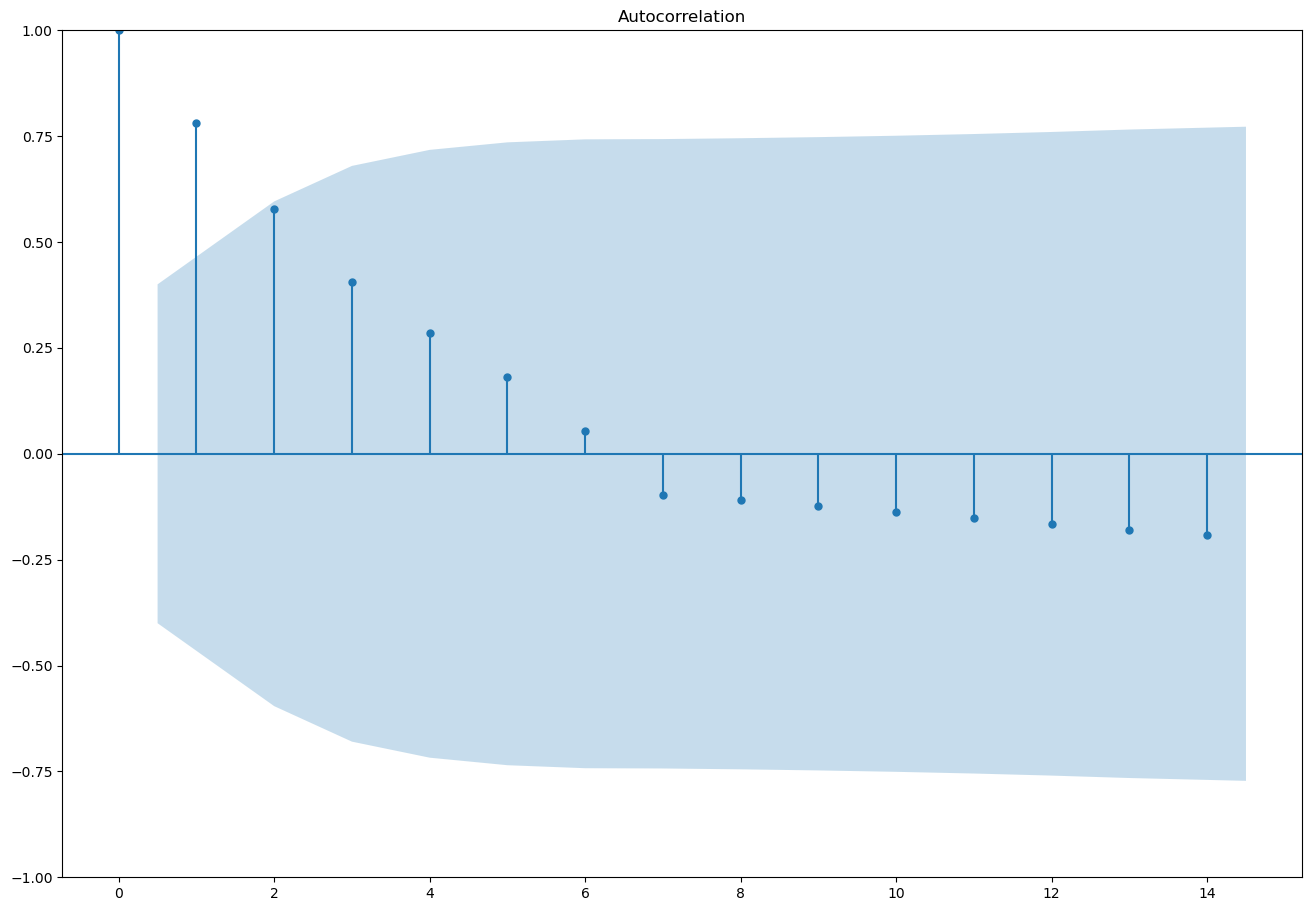

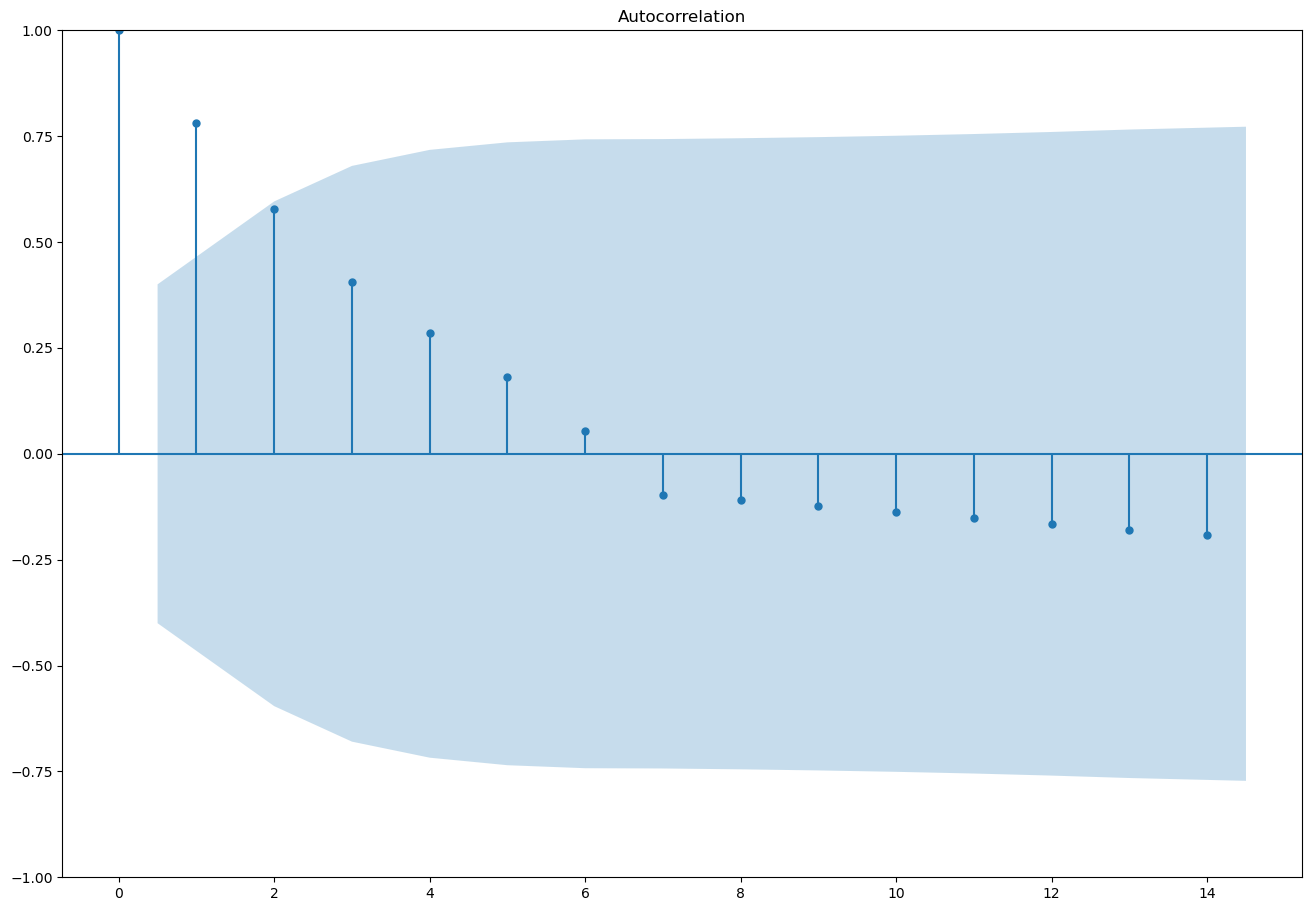

In [1366]:
plot_acf(ser_NA_sp_train)

In [1367]:
p = 10
mod_NA_sp_ar = sm.tsa.ARIMA(ser_NA_sp_train, order = (p, 0, 0)).fit()
print(mod_NA_sp_ar.summary())

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                ARIMA(10, 0, 0)   Log Likelihood                  33.545
Date:                Sat, 20 Apr 2024   AIC                            -43.091
Time:                        23:59:17   BIC                            -28.954
Sample:                    12-31-1990   HQIC                           -39.340
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3397      1.215      1.102      0.270      -1.042       3.722
ar.L1          0.9550      4.955      0.193      0.847      -8.757      10.667
ar.L2          0.0366      5.273      0.007      0.9

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


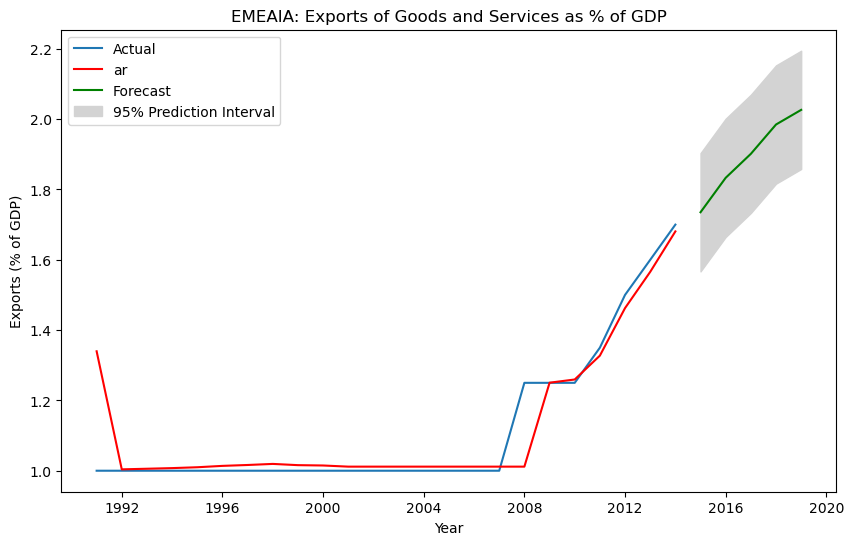

In [1368]:
plot_forecast(ser_NA_sp_train, mod_NA_sp_ar, 'ar', len(ser_NA_sp_test)+2)

In [1369]:
get_metrics(ser_NA_sp_train, ser_NA_sp_test, mod_NA_sp_ar, 'AR', NA_SP)

model  train_rmse  test_rmse      2017      2018
0   ETS    0.057336   0.212811  2.114902  2.216181
1    AR    0.086178   0.220275  1.984760  2.026408

In [1370]:
q = 5
mod_NA_sp_ma = sm.tsa.ARIMA(ser_NA_sp_train, order = (0, 0, q)).fit()
print(mod_NA_sp_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(0, 0, 5)   Log Likelihood                  27.079
Date:                Sat, 20 Apr 2024   AIC                            -40.158
Time:                        23:59:18   BIC                            -31.911
Sample:                    12-31-1990   HQIC                           -37.970
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1593      0.290      3.994      0.000       0.590       1.728
ma.L1          1.4389      0.403      3.566      0.000       0.648       2.230
ma.L2          1.4677      1.534      0.957      0.3

c:\Users\Anjali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [1371]:
get_metrics(ser_NA_sp_train, ser_NA_sp_test, mod_NA_sp_ma, 'MA', NA_SP)

model  train_rmse  test_rmse      2017      2018
0   ETS    0.057336   0.212811  2.114902  2.216181
1    AR    0.086178   0.220275  1.984760  2.026408
2    MA    0.079745   0.513242  1.244936  1.177789

In [1372]:
kpss_level(ser_NA_sp_train, 10)

0.3540779756903515

In [1373]:
kpss_trend(ser_NA_sp_train, 10)

0.1590725981053224

In [1374]:
ser_NA_sp_train = ser_NA_sp_train.diff().dropna()

In [1375]:
mod_NA_sp_auto_arima = pm.auto_arima(ser_NA_sp_train, stepwise=False, seasonal=True)
mod_NA_sp_auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [1376]:
print(mod_NA_sp_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  31.486
Date:                Sat, 20 Apr 2024   AIC                            -56.972
Time:                        23:59:22   BIC                            -53.699
Sample:                    12-31-1991   HQIC                           -56.201
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.003      1.806      0.071      -0.000       0.011
ma.L1         -0.9891      3.240     -0.305      0.760      -7.339       5.361
sigma2         0.0029      0.010      0.295      0.7

In [1377]:
get_metrics(ser_NA_sp_train, ser_NA_std_test, mod_NA_std_auto_arima, 'ARIMA', NA_SP)

model  train_rmse   test_rmse       2017       2018
0    ETS    0.057336    0.212811   2.114902   2.216181
1     AR    0.086178    0.220275   1.984760   2.026408
2     MA    0.079745    0.513242   1.244936   1.177789
3  ARIMA    5.619034  147.955029  16.983027  17.694068

In [1378]:
fitted, conf = mod_NA_std_auto_arima.predict_in_sample(return_conf_int = True, alpha = 0.05)

<Figure size 1200x800 with 0 Axes>

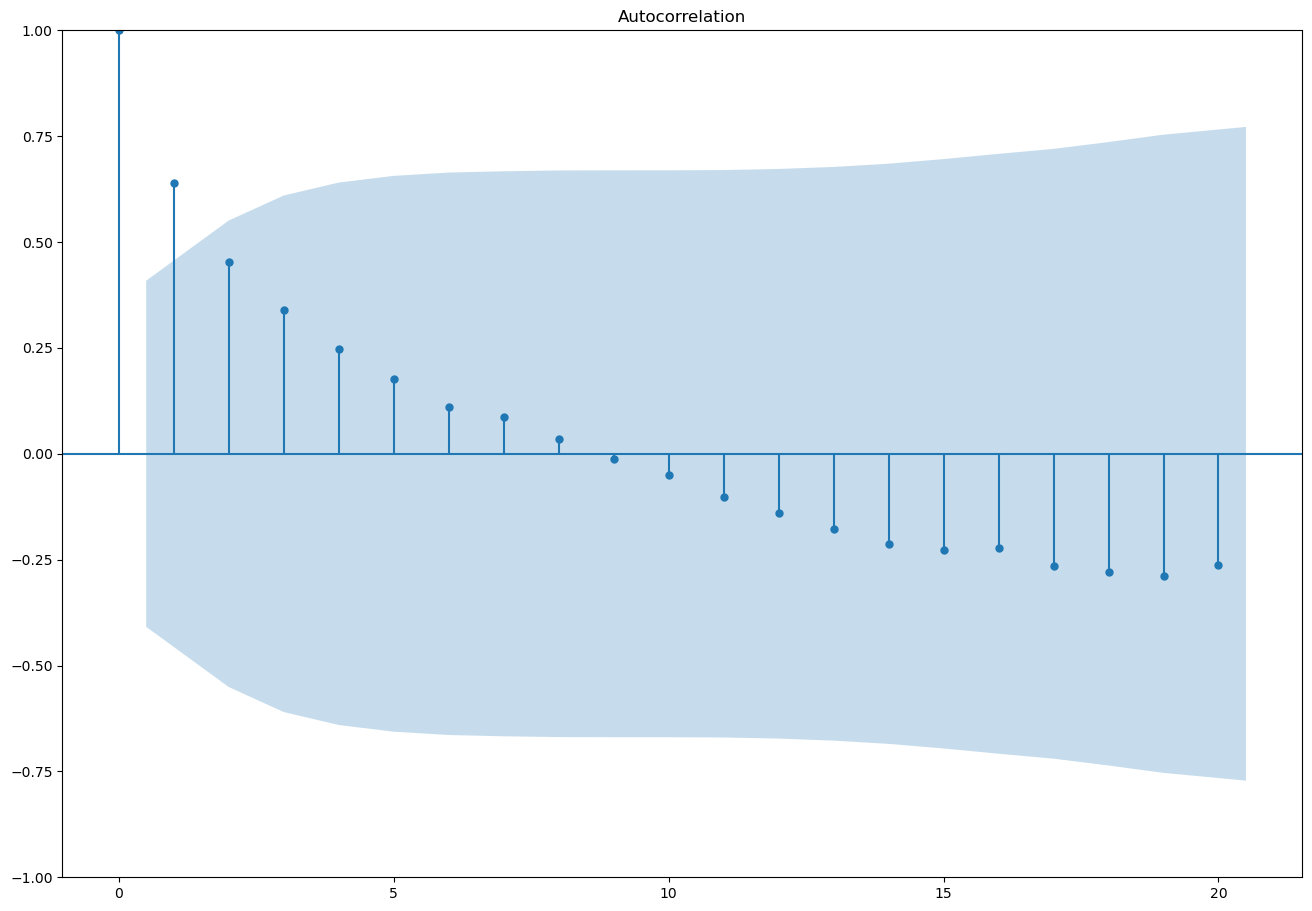

In [1379]:
residuals = ser_NA_sp_train - fitted

plt.figure(figsize = (12, 8))
plot_acf(residuals, lags = 20)
plt.show()

# ====================================================================

# ***Final Result***

In [1380]:
APAC = pd.concat({'Standard':APAC_STD, 'Premium':APAC_P, 'Super Premium':APAC_SP})
APAC

model  train_rmse  test_rmse        2017        2018
Standard      0    ETS    5.971055  45.958900  129.538952  132.696615
              1     AR   11.052920  23.806981  159.580618  157.456527
              2     MA   12.420003  55.706247   88.745681   76.685592
              3  ARIMA    4.972529  26.363071  153.382609  158.378261
Premium       0    ETS    2.210737   1.043301    9.426031    9.751110
              1     AR    1.894940   2.252337    6.166048    6.038300
              2     MA    1.969428   2.221836    6.457532    6.521787
              3  ARIMA    2.149242   8.547949    0.252174    0.252174
Super Premium 0    ETS    0.057336   0.212811    2.114902    2.216181
              1     AR    0.086178   0.220275    1.984760    2.026408
              2     MA    0.079745   0.513242    1.244936    1.177789
              3  ARIMA    0.054410   1.755042    0.112021    0.117457

In [1381]:
EMEA = pd.concat({'Standard':EMEA_STD, 'Premium':EMEA_P, 'Super Premium':EMEA_SP})
EMEA

model  train_rmse    test_rmse         2017         2018
Standard      0    ETS   55.296849    74.059390  2393.983780  2430.872574
              1     AR  145.358913   170.927847  2294.239647  2314.428915
              2     MA  157.383974   532.969438  1545.940158  1483.050569
              3  ARIMA   53.858254  2310.885007    62.460870    62.460870
Premium       0    ETS    6.388284    56.026519   128.505548   130.564979
              1     AR   10.565415    53.287167   133.359004   125.288917
              2     MA   10.212099    81.244376    80.266865    74.148351
              3  ARIMA    6.393781   172.325920     3.727826     3.727826
Super Premium 0    ETS    0.584312     1.225188    10.822956    11.422466
              1     AR    0.737018     2.140511     8.900997     8.832572
              2     MA    0.601896     5.699975     2.240598     2.645886
              3  ARIMA    0.477014     9.239287     1.490831    -0.058232

In [1382]:
LATAM = pd.concat({'Standard':LATAM_STD, 'Premium':LATAM_P, 'Super Premium':LATAM_SP})
LATAM

model    train_rmse  test_rmse       2017       2018
Standard      0    ETS  2.089847e+00   8.890629  21.647239  21.909580
              1     AR  2.623075e+00  10.444943  18.982109  21.147439
              2     MA  1.939999e+00  12.521713  11.585347   9.285105
              3  ARIMA  1.125858e+00  30.824237   0.149116   1.065581
Premium       0    ETS  1.241267e-16   3.960219   1.000000   1.000000
              1     AR  4.824558e-06   3.960222   0.999995   0.999995
              2     MA  4.824558e-06   3.960222   0.999995   0.999995
              3  ARIMA  0.000000e+00   4.670831   0.000000   0.000000
Super Premium 0    ETS  1.241267e-16   0.208247   1.000000   1.000000
              1     AR  4.824558e-06   0.208251   0.999995   0.999995
              2     MA  4.824558e-06   0.208251   0.999995   0.999995
              3  ARIMA  0.000000e+00   1.204173   0.000000   0.000000

In [1383]:
NA = pd.concat({'Standard':NA_STD, 'Premium':NA_P, 'Super Premium':NA_SP})
NA

model  train_rmse   test_rmse        2017        2018
Standard      0    ETS    4.628713   17.146265  173.000087  185.755803
              1     AR   11.709754   24.902708  153.239857  153.592514
              2     MA    6.750588   96.282553   36.504178   41.819202
              3  ARIMA    4.382933  147.955029   16.983027   17.694068
Premium       0    ETS    0.361398    4.348996   12.594711   12.795435
              1     AR    1.221982    3.911567   13.091329   13.547302
              2     MA    1.055941    6.303202    8.316760    7.397572
              3  ARIMA    0.329891   15.399370    0.417391    0.417391
Super Premium 0    ETS    0.057336    0.212811    2.114902    2.216181
              1     AR    0.086178    0.220275    1.984760    2.026408
              2     MA    0.079745    0.513242    1.244936    1.177789
              3  ARIMA    5.619034  147.955029   16.983027   17.694068

In [1384]:
results = pd.concat({'APAC':APAC, 'EMEA':EMEA, 'LATAM':LATAM, 'NA':NA})

In [1385]:
results

model    train_rmse    test_rmse         2017  \
APAC  Standard      0    ETS  5.971055e+00    45.958900   129.538952   
                    1     AR  1.105292e+01    23.806981   159.580618   
                    2     MA  1.242000e+01    55.706247    88.745681   
                    3  ARIMA  4.972529e+00    26.363071   153.382609   
      Premium       0    ETS  2.210737e+00     1.043301     9.426031   
                    1     AR  1.894940e+00     2.252337     6.166048   
                    2     MA  1.969428e+00     2.221836     6.457532   
                    3  ARIMA  2.149242e+00     8.547949     0.252174   
      Super Premium 0    ETS  5.733610e-02     0.212811     2.114902   
                    1     AR  8.617822e-02     0.220275     1.984760   
                    2     MA  7.974478e-02     0.513242     1.244936   
                    3  ARIMA  5.441045e-02     1.755042     0.112021   
EMEA  Standard      0    ETS  5.529685e+01    74.059390  2393.983780   
                    1     AR  1.453589e+02   170.927847  2294.239647   
                    2     MA  1.573840e+02   532.969438  1545.940158   
                    3  ARIMA  5.385825e+01  2310.885007    62.460870   
      Premium       0    ETS  6.388284e+00    56.026519   128.505548   
                    1     AR  1.056541e+01    53.287167   133.359004   
                    2     MA  1.021210e+01    81.244376    80.266865   
                    3  ARIMA  6.393781e+00   172.325920     3.727826   
      Super Premium 0    ETS  5.843122e-01     1.225188    10.822956   
                    1     AR  7.370175e-01     2.140511     8.900997   
                    2     MA  6.018956e-01     5.699975     2.240598   
                    3  ARIMA  4.770135e-01     9.239287     1.490831   
LATAM Standard      0    ETS  2.089847e+00     8.890629    21.647239   
                    1     AR  2.623075e+00    10.444943    18.982109   
                    2     MA  1.939999e+00    12.521713    11.585347   
                    3  ARIMA  1.125858e+00    30.824237     0.149116   
      Premium       0    ETS  1.241267e-16     3.960219     1.000000   
                    1     AR  4.824558e-06     3.960222     0.999995   
                    2     MA  4.824558e-06     3.960222     0.999995   
                    3  ARIMA  0.000000e+00     4.670831     0.000000   
      Super Premium 0    ETS  1.241267e-16     0.208247     1.000000   
                    1     AR  4.824558e-06     0.208251     0.999995   
                    2     MA  4.824558e-06     0.208251     0.999995   
                    3  ARIMA  0.000000e+00     1.204173     0.000000   
NA    Standard      0    ETS  4.628713e+00    17.146265   173.000087   
                    1     AR  1.170975e+01    24.902708   153.239857   
                    2     MA  6.750588e+00    96.282553    36.504178   
                    3  ARIMA  4.382933e+00   147.955029    16.983027   
      Premium       0    ETS  3.613976e-01     4.348996    12.594711   
                    1     AR  1.221982e+00     3.911567    13.091329   
                    2     MA  1.055941e+00     6.303202     8.316760   
                    3  ARIMA  3.298909e-01    15.399370     0.417391   
      Super Premium 0    ETS  5.733610e-02     0.212811     2.114902   
                    1     AR  8.617822e-02     0.220275     1.984760   
                    2     MA  7.974478e-02     0.513242     1.244936   
                    3  ARIMA  5.619034e+00   147.955029    16.983027   

                              2018  
APAC  Standard      0   132.696615  
                    1   157.456527  
                    2    76.685592  
                    3   158.378261  
      Premium       0     9.751110  
                    1     6.038300  
                    2     6.521787  
                    3     0.252174  
      Super Premium 0     2.216181  
                    1     2.026408  
                    2     1.177789  
                    3     0.117457  
EMEA  Standar